### Estudio de Transiciones de Fase en el Modelo de Ising 2D
Grupo 8 - Luis Diaz - Sergio Stedile - Julieta Perez Lanzillotta

2do cuatrimestre 2025

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from numba import njit, prange
from IPython.display import display, clear_output
from scipy.optimize import curve_fit
from tqdm .auto import tqdm
from matplotlib.patches import RegularPolygon
from matplotlib.collections import PatchCollection
from google.colab import files
from scipy.optimize import curve_fit
import os
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.metrics import r2_score, mean_squared_error

DATA_DIR = os.path.join('.', 'data')    # para importar correctamente los datos

In [ ]:
def graficar_red(M, ax=None, select=None):

    if ax is None:
        fig, ax = plt.subplots(figsize = (2,2))

    ax.clear()
    ax.pcolormesh(M, cmap='Grays_r', vmin=-1, vmax=1)

    if select is not None:
        i, j = select
        ax.add_patch(Rectangle((j-1, i-1), 3, 3, lw=1, ec='r',fc='none'))

    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.yaxis.set_inverted(True)

    return ax
def graficar_hexagonal(S, ax=None, title=""):
    """
    Grafica la matriz S como una red hexagonal real.
    Transforma la topología 'Brick Wall' a coordenadas cartesianas hexagonales.
    """
    L = S.shape[0]

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    # Listas para guardar los parches (hexágonos) y sus colores
    patches = []
    colors = []

    # Altura de cada fila para que encajen los hexágonos (sqrt(3)/2)
    dy = np.sqrt(3) / 2

    for i in range(L):
        for j in range(L):
            # --- TRANSFORMACIÓN DE COORDENADAS ---
            #  Desplazamiento horizontal:
            #  Si la fila i es impar, desplazamos x por 0.5 (medio hexágono)
            shift_x = 0.5 * (i % 2)

            # Coordenadas cartesianas
            x = j + shift_x
            y = -i * dy  # Negativo para que se dibuje de arriba hacia abajo

            # Creamos el hexágono
            # radius=0.58 hace que se toquen justo los bordes
            hex_poly = RegularPolygon((x, y), numVertices=6, radius=0.58,
                                      orientation=np.radians(30))
            patches.append(hex_poly)


            colors.append(S[i, j])

    # Optimizacion: Con PatchCollection plottea mas rápido
    p = PatchCollection(patches, cmap='magma', alpha=1.0)
    p.set_array(np.array(colors))
    p.set_clim([-1, 1])

    ax.add_collection(p)

    # Límites del gráfico
    ax.set_xlim(-1, L + 0.5)
    ax.set_ylim(-L * dy - 1, 1)
    ax.set_aspect('equal')
    ax.axis('off')

    if title:
        ax.set_title(title)

    return ax

In [ ]:
# En la función de Ajuste NO lleva @njit porque curve_fit es de Scipy y no es compatible.
# Además, se ejecuta pocas veces, así que no hace falta.
def Ajuste(funcion, xdatos, ydatos, valores_esperados, yerr):
    xdatos = np.array(xdatos)
    ydatos = np.array(ydatos)
    popt, pcov = curve_fit(funcion, xdatos, ydatos, p0=valores_esperados, sigma=yerr)
    return popt, pcov

@njit
def metropolisN_m(S, prob, npasos):
    """
    Versión optimizada con Numba.
    Solo calcula magnetización (m) y su varianza.
    """
    S = S.copy() # Copiamos S una vez al principio
    L = S.shape[0]
    L2 = L * L

    # Array para guardar la historia de la magnetización
    m = np.zeros(npasos)

    # Calculamos la magnetización inicial
    current_m = np.sum(S)
    m[0] = current_m

    # Bucle de tiempo
    for n in range(1, npasos):

        # Bucle de Monte Carlo (1 Sweep = L*L intentos)
        for _ in range(L2):
            idx = np.random.randint(0, L2)
            i = idx // L
            j = idx % L

            # Cálculo de la diferencia de energía dE
            # Suma de vecinos con condiciones periódicas
            vecinos = S[i-1, j] + S[i, j-1] + S[(i+1) % L, j] + S[i, (j+1) % L]
            dE = 2 * S[i, j] * vecinos

            # Regla de aceptación (Metropolis)
            accept = False
            if dE <= 0:
                accept = True
            elif dE == 4:
                if np.random.random() < prob[0]:
                    accept = True
            elif dE == 8:
                if np.random.random() < prob[1]:
                    accept = True

            # Si se acepta el cambio:
            if accept:
                S[i, j] = -S[i, j]
                # Actualizamos la magnetización actual
                # El cambio es: nuevo_spin - viejo_spin = (-s) - (s) = -2s
                current_m += -2.0 * S[i, j]

        # Guardamos el valor de m después de todo el barrido
        m[n] = current_m

    # Normalizamos por el tamaño del sistema (L^2) al final
    m_norm = m / L2

    # Retornamos Estado, promedio(|m|), varianza(|m|)
    return S, np.mean(np.abs(m_norm)), np.var(np.abs(m_norm))

# Funciones principales

In [ ]:
@njit
def h(S):
    '''
    Calcula la energía de la red en el estado S.
    Asume que no hay campo magnético y usa condiciones de contorno periódicas.
    de manera que el primer espín de una fila o columna es vecino del último.

    Parámetros
    ----
    S : Matriz de 1's y -1's que contiene la orientación de los espines en cada
        punto de la red.

    Funcionamiento
    ----
    Iteramos sobre cada spin y sumamos interacción con los vecinos derecha y abajo.
    '''
    L = S.shape[0]
    E = 0.0
    for i in range(L):
        for j in range(L):
            S_ij = S[i, j]
            vecino_right = S[i, (j + 1) % L]
            vecino_down  = S[(i + 1) % L, j]
            E += -S_ij * (vecino_right + vecino_down)
    return E

@njit
def metropolis1(S, prob):
    '''
    Aplica Metropolis a un solo espín.

    Recibe una matriz inicial y un vector con probabilidades, aplica el
    algoritmo de Metropolis al estado S y devuelve: un nuevo S,
    el incremento de magnetización dM y el incremento de energía dE.

    Parámetros
    ----
    S    :  Matriz de 1's y -1's que contiene la orientación de los espines en cada
            punto de la red.
    prob :  Array con probabilidades de transición.

    Algoritmo de Metrópolis
    ----
    1. Elegir un espín de la red al azar.
    2. Calcular la diferencia de energía dE que resultaría de dar vuelta a ese
       espín.
    3. Si  dE <= 0 , damos vuelta el espín (con probabilidad 1); si  dE > 0, damos vuelta al espín con
       probabilidad  exp(- beta * dE).

    '''
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    i, j = divmod(np.random.randint(0, L2), L)

    # Calculo dE sumando los 4 vecinos
    vecinos = S[i-1, j] + S[i, j-1] + S[(i+1) % L, j] + S[i, (j+1) % L]
    dE = 2 * S[i, j] * vecinos
    dM = -2 * S[i, j]

    accept = False
    if dE <= 0:
        accept = True
    elif dE == 4:
        if np.random.random() < prob[1]: accept = True
    elif dE == 8:
        if np.random.random() < prob[2]: accept = True

    if accept:
        S[i,j] = -S[i,j]
    else:
        dM, dE = 0, 0

    return S, dM, dE

@njit
def metropolis(S, prob):
    """
    Aplica el algoritmo de Metropolis al estado S 'L**2' veces.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    dM = 0
    dE = 0

    for _ in range(L2):
        i, j = divmod(np.random.randint(0, L2), L)

        vecinos = S[i-1, j] + S[i, j-1] + S[(i+1) % L, j] + S[i, (j+1) % L]
        de = 2 * S[i, j] * vecinos
        dm = -2 * S[i, j]

        accept = False
        if de <= 0:
            accept = True
        elif de == 4:
            if np.random.random() < prob[0]: accept = True
        elif de == 8:
            if np.random.random() < prob[1]: accept = True

        if accept:
            S[i,j] = -S[i,j]
            dM += dm                                                                   # va sumando las dm y de
            dE += de

    return S, dM, dE                                                                   #nos da el nuevo S, la dm total y de total del sistema

@njit
def metropolisN(S, prob, npasos):
    """
    Aplica el algoritmo de Metropolis al estado S 'npasos' veces guardando datos.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    m = np.zeros(npasos)
    e = np.zeros(npasos)
    m[0] = np.sum(S)
    e[0] = h(S)

    for n in range(1, npasos):
        dM = 0
        dE = 0

        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)

            vecinos = S[i-1, j] + S[i, j-1] + S[(i+1) % L, j] + S[i, (j+1) % L]
            de = 2 * S[i, j] * vecinos
            dm = -2 * S[i, j]

            accept = False
            if de <= 0:
                accept = True
            elif de == 4:
                if np.random.random() < prob[0]: accept = True
            elif de == 8:
                if np.random.random() < prob[1]: accept = True

            if accept:
                S[i,j] = -S[i,j]
                dM += dm
                dE += de

        m[n] = m[n - 1] + dM
        e[n] = e[n - 1] + dE

    m = m / (L * L)
    e = e / (L * L)

    return S, np.mean(np.abs(m)), np.mean(e), np.var(np.abs(m)), np.var(e)

# Test de las funciones

Para probar si la funcion h(s) funciona vamos a probar de forma casera con una matriz de 3x3.

$$
\mathbb S =
\left[\begin{smallmatrix}
    1 & 1 &  -1 \\
   -1 &  1 & 1 \\
    1 &  -1 &  -1
\end{smallmatrix}\right],
$$
la energía total es:
$$
\begin{aligned}
H(S) &=-\sum_{i=1}^3\sum_{j=1}^3 S_{ij}(S_{i-1 j}+S_{ij-1}) \\
     &=-\sum_{j=1}^3\left[ S_{1j}(S_{3 j}+S_{1j-1})+S_{2j}(S_{1 j}+S_{2j-1})+S_{3j}(S_{2 j}+S_{3j-1})\right] \\
     &=-\left[S_{11}(S_{3 1}+S_{13})+S_{21}(S_{1 1}+S_{23})+S_{31}(S_{2 1}+S_{33})+S_{12}(S_{3 2}+S_{11})+S_{22}(S_{1 2}+S_{21})+S_{32}(S_{2 2}+S_{31})+S_{13}(S_{3 3}+S_{12})+S_{23}(S_{1 3}+S_{22})+S_{33}(S_{2 3}+S_{32})\right] \\
     &= -\left[1(1-1)-1(1+1)+1(-1-1)+1(-1+1)+1(1-1)-1(1+1)-1(-1+1)+1(-1+1)-1(1-1)\right] \\
     &= 6
\end{aligned}
$$

In [ ]:
print(h(S = np.array([[ 1, 1,  -1],
                      [-1,  1, 1],
                      [ 1,  -1,  -1]])))      # Prueba de calculo para ver si el codigo funciona

6.0


Da según lo calculado analíticamente

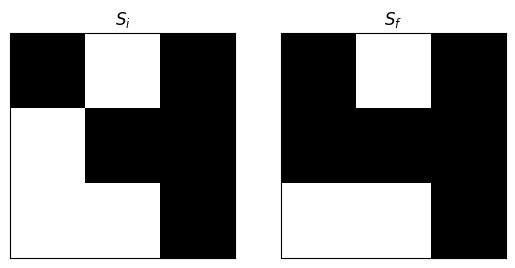

---
ESTADO INICIAL
Energía total: 2.00
Energía por partícula: 0.22
Magnetización total: -1.00
Magnetización por partícula: -0.11
---
ESTADO FINAL
Energía total: -2.0
Energía por partícula: -0.2222222222222222
Magnetización total: -3
Magnetización por partícula: -0.3333333333333333
dM: -2 , dE: -4


In [ ]:
L = 3                                                                           # Test de la función metropolis1, para ello generamos una red de L = 3 y le aplicamos dicha función
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

Si = 2 * np.random.randint(2, size = (L, L)) - 1
Sf, dm, de = metropolis1(Si, prob)

fig, axs = plt.subplots(1, 2)

graficar_red(Si, ax=axs[0])
graficar_red(Sf, ax=axs[1])
axs[0].set_title("$S_i$")
axs[1].set_title("$S_f$")
plt.show()

print('---\nESTADO INICIAL')
print(f'Energía total: {h(Si):.2f}')
print(f'Energía por partícula: {h(Si)/L2:.2f}')
print(f'Magnetización total: {np.sum(Si):.2f}')
print(f'Magnetización por partícula: {np.sum(Si)/L2:.2f}')

print('---\nESTADO FINAL')
print('Energía total:', h(Sf))
print('Energía por partícula:', h(Sf)/L2)
print('Magnetización total:', np.sum(Sf))
print('Magnetización por partícula:', np.sum(Sf)/L2)
print('dM:', dm, ', dE:', de)

Es el resultado que esperabamos


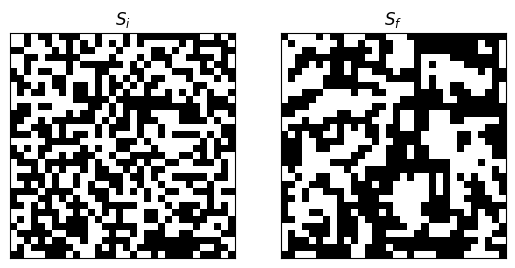

---
ESTADO INICIAL
Energía total: 68.00
Energía por partícula: 0.07
Magnetización total: -22.00
Magnetización por partícula: -0.02
---
ESTADO FINAL
Energía total: -652.00
Energía por partícula: -0.64
Magnetización total: -60.00
Magnetización por partícula: -0.06
dM: -38 , dE: -720


In [ ]:
L = 32                                                                          # Volvemos a hacer lo mismo con la función metropolis para una red de mayor tamaño
L2 = L * L

beta = 1/1.8
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

Si = 2 * np.random.randint(2, size = (L, L)) - 1
Sf, dm, de = metropolis(Si, prob)

fig, axs = plt.subplots(1, 2)

graficar_red(Si, ax=axs[0])
graficar_red(Sf, ax=axs[1])
axs[0].set_title("$S_i$")
axs[1].set_title("$S_f$")
plt.show()

print('---\nESTADO INICIAL')
print(f'Energía total: {h(Si):.2f}')
print(f'Energía por partícula: {h(Si)/L2:.2f}')
print(f'Magnetización total: {np.sum(Si):.2f}')
print(f'Magnetización por partícula: {np.sum(Si)/L2:.2f}')

print('---\nESTADO FINAL')
print(f'Energía total: {h(Sf):.2f}')
print(f'Energía por partícula: {h(Sf)/L2:.2f}')
print(f'Magnetización total: {np.sum(Sf):.2f}')
print(f'Magnetización por partícula: {np.sum(Sf)/L2:.2f}')
print('dM:', dm, ', dE:', de)

Correcto, la función funciona según lo esperado


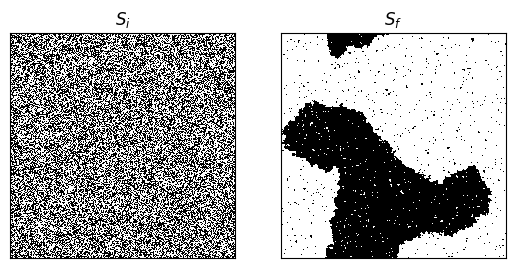

---
ESTADO INICIAL
Energía por partícula: 0.00
Magnetización por partícula: 0.01
---
ESTADO FINAL
Energía por partícula: -1.83
Magnetización por partícula: 0.31
Energía media por partícula: -1.79 ± 0.08
Magnetización media por partícula: 0.24 ± 0.07


In [ ]:
L = 256                                                                         # Acá probamos la función metropolis N para una red de tamaño L = 256
L2 = L * L

beta = 1/1.8
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

npasos = 2000                                                                   #Numero de pasos tentativo para llegar al equilibrio. Experimenten con este valor. Obviamente, no es 1.

Si = 2 * np.random.randint(2, size = (L, L)) - 1
Sf, m_med, e_med, m_var, e_var = metropolisN(Si, prob, npasos)

fig, axs = plt.subplots(1, 2)

graficar_red(Si, ax=axs[0])
graficar_red(Sf, ax=axs[1])
axs[0].set_title("$S_i$")
axs[1].set_title("$S_f$")
plt.show()

print('---\nESTADO INICIAL')
print(f'Energía por partícula: {h(Si)/L2:.2f}')
print(f'Magnetización por partícula: {np.sum(Si)/L2:.2f}')

print('---\nESTADO FINAL')
print(f'Energía por partícula: {h(Sf)/L2:.2f}')
print(f'Magnetización por partícula: {np.sum(Sf)/L2:.2f}')
print(f'Energía media por partícula: {e_med:.2f} ± {np.sqrt(e_var):.2f}')
print(f'Magnetización media por partícula: {m_med:.2f} ± {np.sqrt(m_var):.2f}')

# Termalización

En esta sección definiremos la función de termalización. El objetivo principal de esta función es "termalizar" el sistema. Aplica el algoritmo de Metropolis durante un número predefinido de pasos (nequilibrio) para llevar al sistema a un estado de equilibrio a una temperatura determinada, descartando cualquier medición intermedia. No se recopilan estadísticas durante este proceso.

Devuelve únicamente el estado final de la red de espines ($S$) una vez completados los pasos de termalización. La premisa es que este estado $S$ retornado constituye una configuración de equilibrio, lista para ser utilizada en mediciones subsiguientes o para el análisis estadístico mediante otra función (como metropolisN).

In [ ]:
@njit
def metropolisTermo(S, prob, nequilibrio):
    """
    Aplica el algoritmo de Metropolis para termalizar.
    """

    S = S.copy()

    L  = S.shape[0]
    L2 = L * L

    for n in range(nequilibrio):
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)

            # Suma de vecinos
            vecinos = S[i-1, j] + S[i, j-1] + S[(i+1) % L, j] + S[i, (j+1) % L]
            de = 2 * S[i, j] * vecinos

            # elegimos de acuerdo al criterio dado en los enunciados
            accept = False
            if de <= 0:
                accept = True
            elif de == 4:
                if np.random.random() < prob[0]: accept = True
            elif de == 8:
                if np.random.random() < prob[1]: accept = True

            if accept:
                S[i,j] = -S[i,j]

    return S

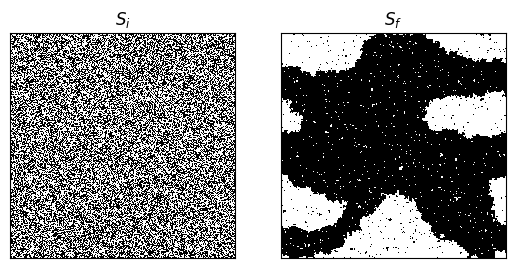

In [ ]:
L = 256                                                                         # Test de la función metropolisTermo a una red de L = 256
L2 = L * L
nequilibrio = 2000

S = 2 * np.random.randint(2, size = (L, L)) - 1

beta = 1/1.8
prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

Si = 2 * np.random.randint(2, size = (L, L)) - 1
Sf = metropolisTermo(S, prob, nequilibrio)

# Gráfico
fig, axs = plt.subplots(1, 2)
graficar_red(Si, ax=axs[0])
graficar_red(Sf, ax=axs[1])
axs[0].set_title("$S_i$")
axs[1].set_title("$S_f$")
plt.show()

In [ ]:
                                                                                  # Termalización de la energía como función de T a L constante.
                                                                                  # En esta celda se simulan redes, se la termaliza y se generan los datos y gráficos correspondientes.
                                                                                  # Para generar nuevas simulaciones descomentar la celda.

"""
# Parámetros generales
nequilibrio = 2500
Ls_analisis = [32, 64, 128]

# temperaturas
temperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, \
                2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]

# Colores
colores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))

# Diccionario anidado para guardar resultados
energias_cuad = {L: {} for L in Ls_analisis}

print("Iniciando simulación de termalización...")

for L in Ls_analisis:
    L2 = L * L

    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):
        beta = 1/T
        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])


        S = 2 * np.random.randint(2, size=(L, L)) - 1

        # Array para guardar la evolución
        e_evo = np.zeros(nequilibrio)
        current_E = h(S)
        e_evo[0] = current_E

        # Bucle de termalización
        # Usamos la función metropolis
        for n in range(1, nequilibrio):
            S, dm, de = metropolis(S, prob)
            current_E += de
            e_evo[n] = current_E

        # Guardamos normalizado por espín
        energias_cuad[L][T] = e_evo / L2

clear_output() # Limpiamos la salida de la simulación para mostrar los gráficos limpios

# Gráficos
for L in Ls_analisis:
    plt.figure(figsize=(10, 5))
    plt.title(f'Termalización para Red L = {L}')

    for i, T in enumerate(temperaturas):
        # Graficamos la evolución
        plt.plot(energias_cuad[L][T], label=f'{T:.1f}', c=colores[i], lw=1, alpha=0.9)

    plt.xlabel('Paso Monte Carlo')
    plt.ylabel('Energía por espín')

    plt.legend(title="Temperatura", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()


    """

'\n# Parámetros generales\nnequilibrio = 2500\nLs_analisis = [32, 64, 128]\n\n# temperaturas\ntemperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1,                 2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]\n\n# Colores\ncolores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))\n\n# Diccionario anidado para guardar resultados\nenergias_cuad = {L: {} for L in Ls_analisis}\n\nprint("Iniciando simulación de termalización...")\n\nfor L in Ls_analisis:\n    L2 = L * L\n\n    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):\n        beta = 1/T\n        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])\n\n\n        S = 2 * np.random.randint(2, size=(L, L)) - 1\n\n        # Array para guardar la evolución\n        e_evo = np.zeros(nequilibrio)\n        current_E = h(S)\n        e_evo[0] = current_E\n\n        # Bucle de termalización\n        # Usamos la función metropolis\n        for n in range(1, nequilibrio):\n            S, dm, de = metropolis(S, prob)\n            current_E += de

## Termalización energía (Red Cuadrada)

Cargando archivos y generando gráficos...


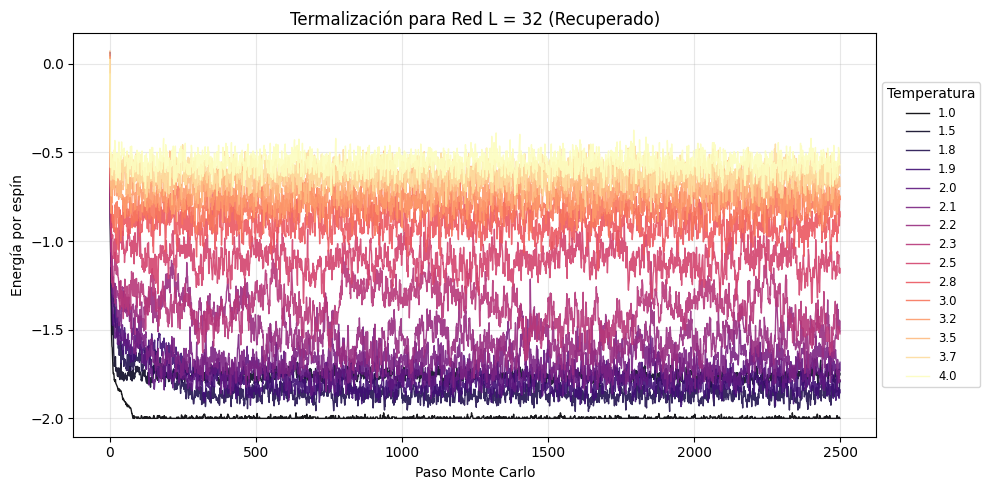

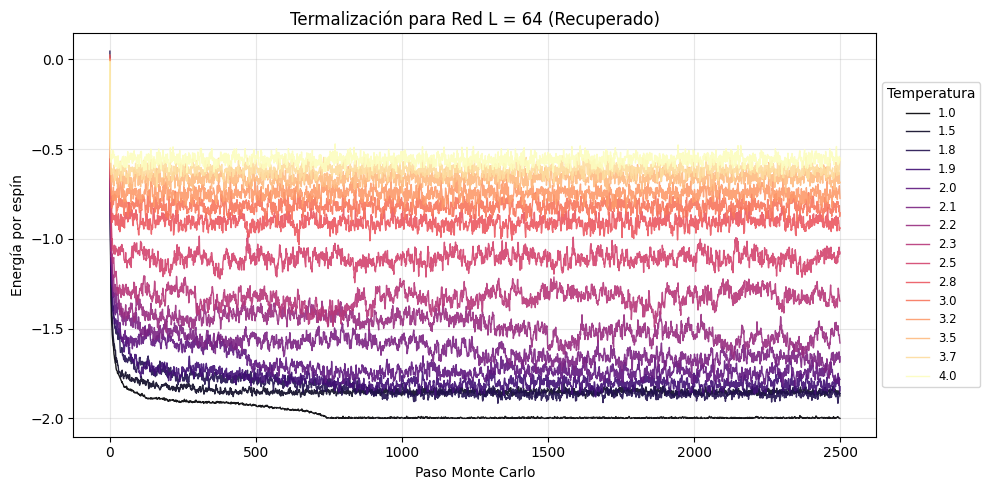

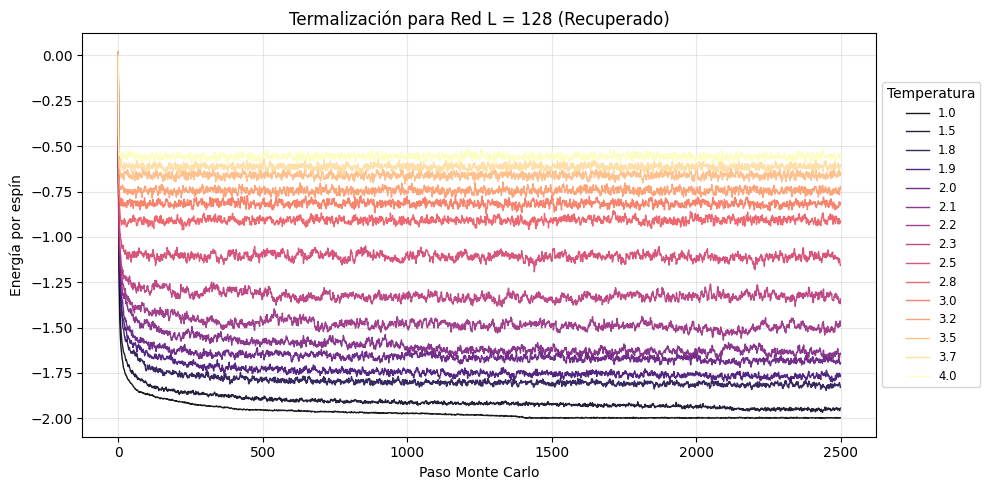

In [ ]:
                                                                                            # Carga de datos y Gráficos
                                                                                            # Acá cargamos los datos que generamos usando el codigo anterior

Ls_analisis = [32, 64, 128]
temperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1,
                2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]

colores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))

print("Cargando archivos y generando gráficos...")

for L in Ls_analisis:
    nombre_archivo = f"termalizacion_energia_cuad_L{L}.npz"
    path_completo = os.path.join(DATA_DIR, nombre_archivo)
    try:

        data = np.load(path_completo)


        plt.figure(figsize=(10, 5))
        plt.title(f'Termalización para Red L = {L} (Recuperado)')


        for i, T in enumerate(temperaturas):
            clave = f"T_{T:.2f}"

            if clave in data:
                curve = data[clave]
                plt.plot(curve, label=f'{T:.1f}', c=colores[i], lw=1, alpha=0.9)
            else:
                print(f"Advertencia: No se encontraron datos para T={T} en L={L}")

        plt.xlabel('Paso Monte Carlo')
        plt.ylabel('Energía por espín')
        plt.legend(title="Temperatura", loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: No se encontró el archivo '{path_completo}'.")
        print("Por favor, súbelo a la carpeta de archivos de Colab.")

Observamos que $n\sim 2000$ pasos parecen ser suficientes para que termalicen las redes de los distintos tamaños. No se observa una dependencia clara del tiempo de termalización con el tamaño de la red, al menos en el rango considerado. Los valores que más tardan en termalizar y más oscilan son los cercanos a la temperatura crítica.

A continuación, estudiamos la termalización de varias redes de varios tamaños a temperatura fija. Probamos para tres temperaturas también: baja, cercana a  $T_c$  y alta.

In [ ]:
# Termalización de la energía como función de L a T constante
# Esta celda simula redes, las termaliza, calcula y grafica.
# Para generar nuevas redes descomentar esta celda

"""

Longitudes = [32, 64, 128]
temperaturas = [1, 2.5, 4.0]

nequilibrio = 2500
colores = plt.cm.viridis(np.linspace(0, 1, len(Longitudes)))


energias_cuad_2 = {T: {} for T in temperaturas}

print("Iniciando simulación...")

for L in Longitudes:
    L2 = L * L

    # iteramos sobre temperaturas para este L
    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):
        beta = 1/T
        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])


        S = 2 * np.random.randint(2, size=(L, L)) - 1

        e_evo = np.zeros(nequilibrio)
        current_E = h(S)
        e_evo[0] = current_E


        for n in range(1, nequilibrio):

            S, dm, de = metropolis(S, prob)
            current_E += de
            e_evo[n] = current_E

        # guardamos normalizado por espín
        energias_cuad_2[T][L] = e_evo / L2

clear_output()

# gráficos
for T in temperaturas:
    plt.figure(figsize=(10, 4))

    for i, L in enumerate(Longitudes):
        plt.plot(energias_cuad_2[T][L], label=f'L={L}', c=colores[i], lw=1, alpha=0.9)

    plt.title(f'Termalización a T = {T}')
    plt.xlabel('Pasos Monte Carlo')
    plt.ylabel('Energía por espín')
    plt.legend(title="Longitud", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()


    """

'\n\nLongitudes = [32, 64, 128]\ntemperaturas = [1, 2.5, 4.0]\n\nnequilibrio = 2500\ncolores = plt.cm.viridis(np.linspace(0, 1, len(Longitudes)))\n\n\nenergias_cuad_2 = {T: {} for T in temperaturas}\n\nprint("Iniciando simulación...")\n\nfor L in Longitudes:\n    L2 = L * L\n\n    # iteramos sobre temperaturas para este L\n    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):\n        beta = 1/T\n        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])\n\n\n        S = 2 * np.random.randint(2, size=(L, L)) - 1\n\n        e_evo = np.zeros(nequilibrio)\n        current_E = h(S)\n        e_evo[0] = current_E\n\n\n        for n in range(1, nequilibrio):\n\n            S, dm, de = metropolis(S, prob)\n            current_E += de\n            e_evo[n] = current_E\n\n        # guardamos normalizado por espín\n        energias_cuad_2[T][L] = e_evo / L2\n\nclear_output()\n\n# gráficos\nfor T in temperaturas:\n    plt.figure(figsize=(10, 4))\n\n    for i, L in enumerate(Longitudes):\n

## Termalización con L variable (Red Cuadrada)

Generando gráficos recuperados...


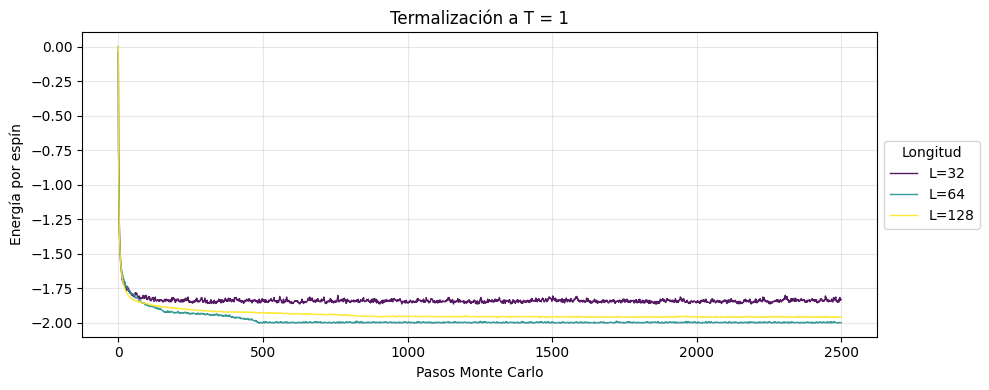

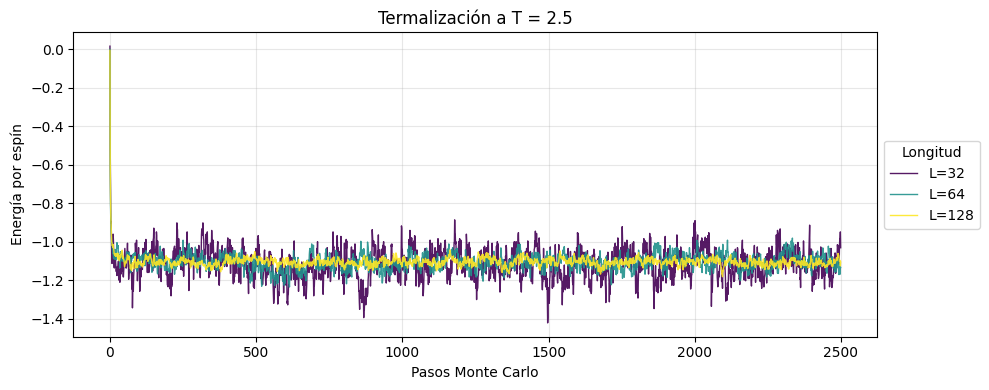

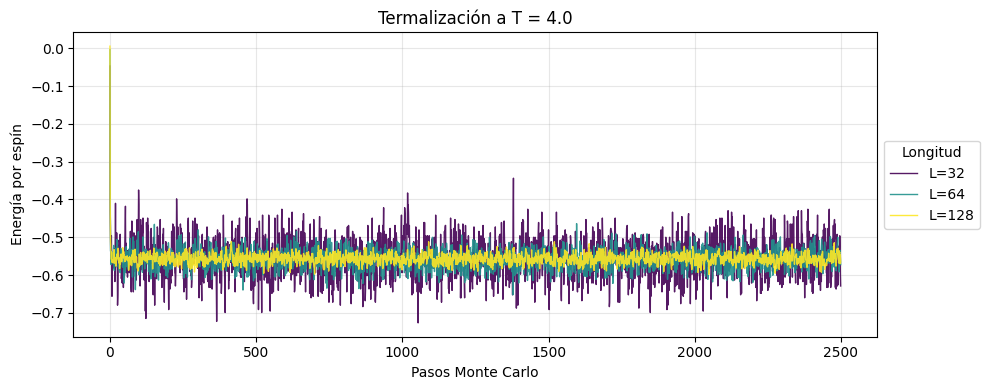

In [ ]:
 # Cargar y graficar termalización en función de L a T cte.
 # Carga nuestra simulación generada

Longitudes = [32, 64, 128]
temperaturas = [1, 2.5, 4.0]


colores = plt.cm.viridis(np.linspace(0, 1, len(Longitudes)))

print("Generando gráficos recuperados...")


for T in temperaturas:
    nombre_archivo = f"termalizacion_energia_varL_T{T}.npz"
    path_completo = os.path.join(DATA_DIR, nombre_archivo)
    try:

        data = np.load(path_completo)


        plt.figure(figsize=(10, 4))


        for i, L in enumerate(Longitudes):
            clave = f"L_{L}"

            if clave in data:
                curve = data[clave]
                plt.plot(curve, label=f'L={L}', c=colores[i], lw=1, alpha=0.9)
            else:
                print(f"Advertencia: Falta dato para L={L} en el archivo {path_completo}")


        plt.title(f'Termalización a T = {T}')
        plt.xlabel('Pasos Monte Carlo')
        plt.ylabel('Energía por espín')
        plt.legend(title="Longitud", loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: Falta el archivo '{path_completo}'. Por favor súbelo.")

Tiempo de Termalización:

 En todos los casos estudiados, $N=2500$ pasos de Monte Carlo demostraron ser suficientes para que el sistema abandone el estado inicial aleatorio y alcance el equilibrio térmico. La caída inicial es rápida (generalmente en menos de 100 pasos), seguida de una oscilación estable alrededor de la energía media.

Dependencia de las Fluctuaciones con $L$:

Se verificó consistentemente que la magnitud de las fluctuaciones de la energía por espín disminuye al aumentar el tamaño de la red.

Comportamiento por Fases:

A baja temperatura (fase ordenada), el sistema es rígido y presenta pocas fluctuaciones, pero los efectos de tamaño finito desplazan ligeramente el valor medio de la energía.

Cerca de la temperatura crítica, el sistema presenta las mayores fluctuaciones

A alta temperatura (fase desordenada), el comportamiento es dominado por el ruido térmico, y las curvas de distintos tamaños colapsan al mismo valor medio de energía rápidamente.

## Termalización de la Magnetización (Red Cuadrada)

In [ ]:
 # Simulacion y termalización de la magnetización como función de T a L constante
 # Para generar nuevas redes descomentar esta celda
"""

L_lista = [32, 64, 128]
nequilibrio = 20000


temperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]

colores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))

# Diccionario para guardar resultados
ms_cuad = {L: {} for L in L_lista}

print("Iniciando termalización de magnetización...")

for L in L_lista:
    L2 = L * L

    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):
        beta = 1/T
        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])


        S = 2 * np.random.randint(2, size = (L, L)) - 1

        m_evo = np.zeros(nequilibrio)
        current_M = np.sum(S)
        m_evo[0] = current_M


        for n in range(1, nequilibrio):
            S, dm, de = metropolis(S, prob)
            current_M += dm
            m_evo[n] = current_M

        # Guardamos normalizado por espín
        ms_cuad[L][T] = m_evo / L2

clear_output()

# Gráficos
for L in L_lista:
    plt.figure(figsize=(12, 6))
    plt.title(f'Termalización de Magnetización para L = {L}')

    for i, T in enumerate(temperaturas):

        plt.plot(np.abs(ms_cuad[L][T]), label=f'{T:.1f}', c=colores[i], zorder=-i, lw=0.8)

    plt.xlabel('Pasos Monte Carlo')
    plt.ylabel('|Magnetización| por espín')
    plt.legend(title="$T$", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()

    """

'\n\nL_lista = [32, 64, 128]\nnequilibrio = 20000\n\n\ntemperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]\n\ncolores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))\n\n# Diccionario para guardar resultados\nms_cuad = {L: {} for L in L_lista}\n\nprint("Iniciando termalización de magnetización...")\n\nfor L in L_lista:\n    L2 = L * L\n\n    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):\n        beta = 1/T\n        prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])\n\n\n        S = 2 * np.random.randint(2, size = (L, L)) - 1\n\n        m_evo = np.zeros(nequilibrio)\n        current_M = np.sum(S)\n        m_evo[0] = current_M\n\n\n        for n in range(1, nequilibrio):\n            S, dm, de = metropolis(S, prob)\n            current_M += dm\n            m_evo[n] = current_M\n\n        # Guardamos normalizado por espín\n        ms_cuad[L][T] = m_evo / L2\n\nclear_output()\n\n# Gráficos\nfor L in L_lista:\n    plt.figure(figsize=(1

Recuperando gráficos de Magnetización...


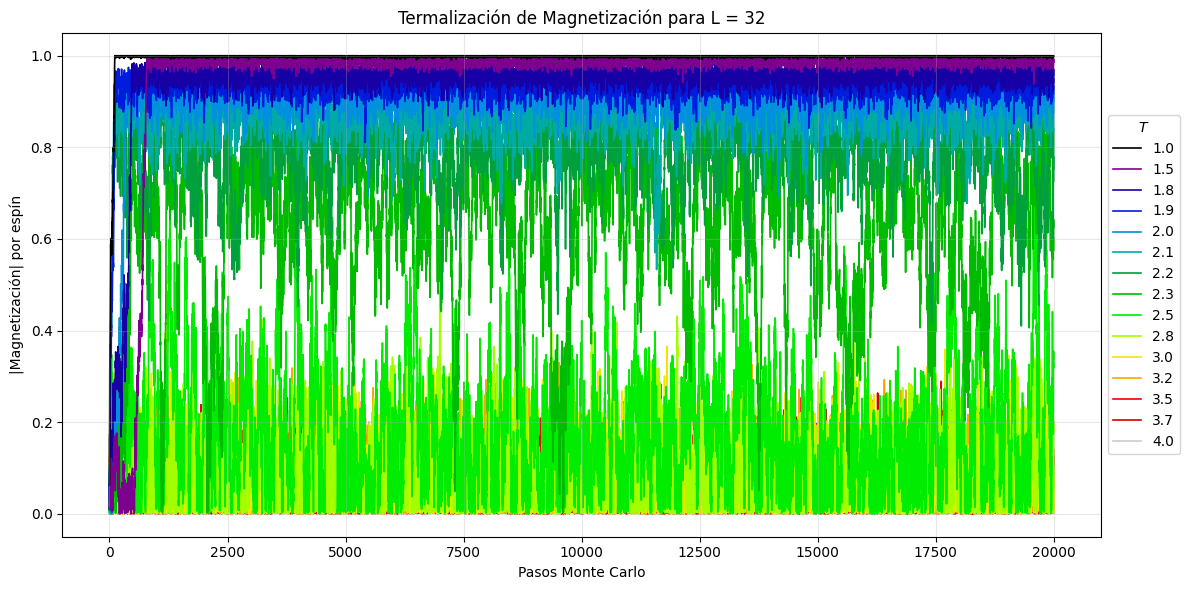

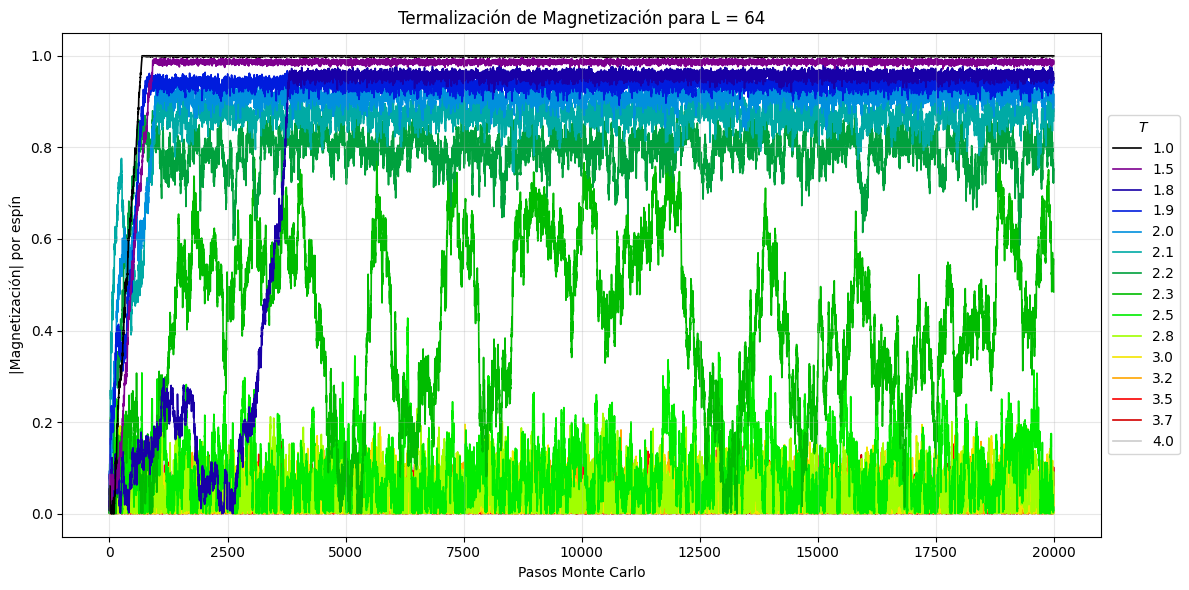

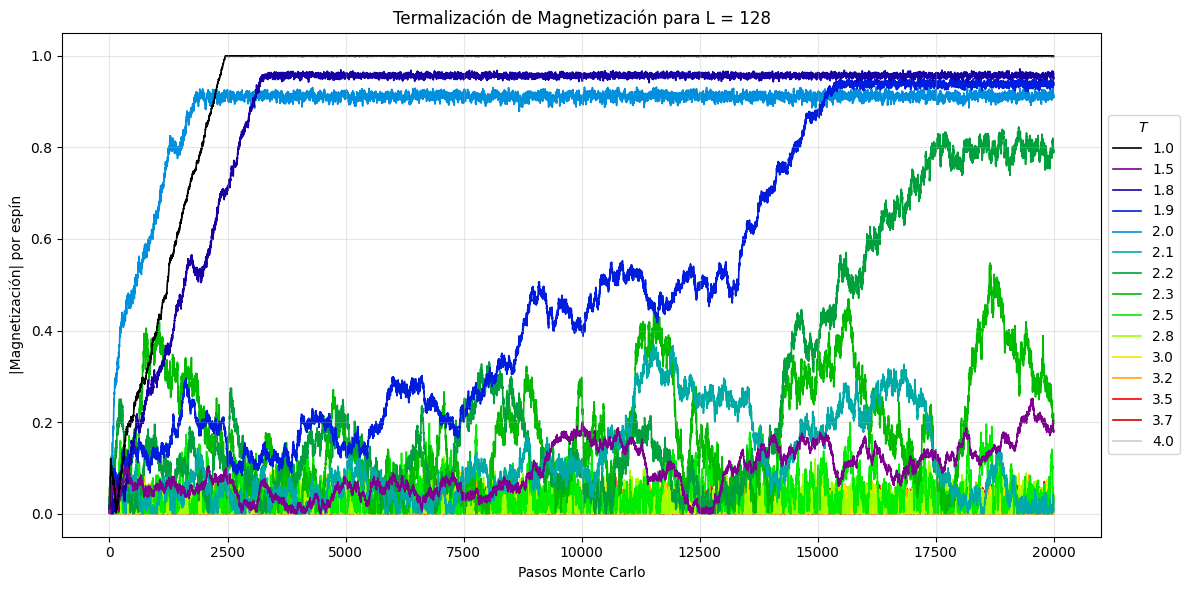

In [ ]:
 # Cargar y Graficar datos de termalización de magnetización

L_lista = [32, 64, 128]
temperaturas = [1.0, 1.5, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.5, 2.8, 3.0, 3.2, 3.5, 3.7, 4.0]

colores = plt.cm.nipy_spectral(np.linspace(0, 1, len(temperaturas)))

print("Recuperando gráficos de Magnetización...")

for L in L_lista:
    nombre_archivo = f"termalizacion_magnetizacion_cuad_L{L}.npz"
    path_completo = os.path.join(DATA_DIR, nombre_archivo)
    try:
        data = np.load(path_completo)

        plt.figure(figsize=(12, 6))
        plt.title(f'Termalización de Magnetización para L = {L}')

        for i, T in enumerate(temperaturas):
            clave = f"T_{T:.2f}"

            if clave in data:
                curve = data[clave]
                plt.plot(np.abs(curve), label=f'{T:.1f}', c=colores[i], zorder=-i, lw=1.2)
            else:
                print(f"Falta dato T={T} en {path_completo}")

        plt.xlabel('Pasos Monte Carlo')
        plt.ylabel('|Magnetización| por espín')

        plt.legend(title="$T$", loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: Falta el archivo '{path_completo}'. Súbelo a la carpeta.")

1. Condición Inicial (Arranque en Caliente):
Todas las curvas parten de $|M| \approx 0$. Esto es consistente con iniciar la red en un estado aleatorio (temperatura infinita), donde hay aproximadamente la misma cantidad de espines arriba y abajo.

2. Separación de Fases: Se observa claramente la bifurcación del comportamiento según la temperatura:

    *   Fase Ferromagnética ($T < T_c$, líneas oscuras): El sistema se "ordena" rápidamente. La magnetización crece abruptamente desde 0 hasta saturar cerca de 1 (todos los espines alineados). Cuanto más baja es la temperatura (ej. $T=1.0$, línea negra), más rápido y estable es este ordenamiento.
    *   Fase Paramagnética ($T > T_c$, líneas claras): El desorden térmico gana. La magnetización fluctúa alrededor de 0 y nunca logra crecer, ya que la temperatura "rompe" cualquier intento de formación de dominios grandes.



3. El Fenómeno de "Critical Slowing Down":
Las curvas de colores intermedios (tonos fucsia/magenta, correspondientes a $T \approx 2.2 - 2.3$) muestran el comportamiento más interesante:

    *   El sistema tarda mucho más en "decidir" a qué estado ir.
    *   En las redes grandes ($L=128$), se ve cómo estas temperaturas críticas fluctúan violentamente y recorren valores intermedios durante miles de pasos (observa las líneas magenta oscilando entre 0.2 y 0.8). Esto es la ralentización crítica: cerca de la transición de fase, la dinámica del sistema se vuelve extremadamente lenta y las correlaciones de largo alcance dificultan la relajación al equilibrio.

4. Efecto del Tamaño ($L$):

    *   L=32: Las curvas son muy ruidosas, especialmente en la fase desordenada (abajo).
    *   L=128: Las curvas son mucho más suaves y definidas. El ruido en la fase paramagnética (cerca de 0) es casi nulo, lo que confirma de nuevo que las fluctuaciones de magnetización por espín disminuyen al aumentar el tamaño del sistema ($\propto 1/\sqrt{N}$).







# Verificamos los promedios

Midiendo...:   0%|          | 0/9999 [00:00<?, ?it/s]

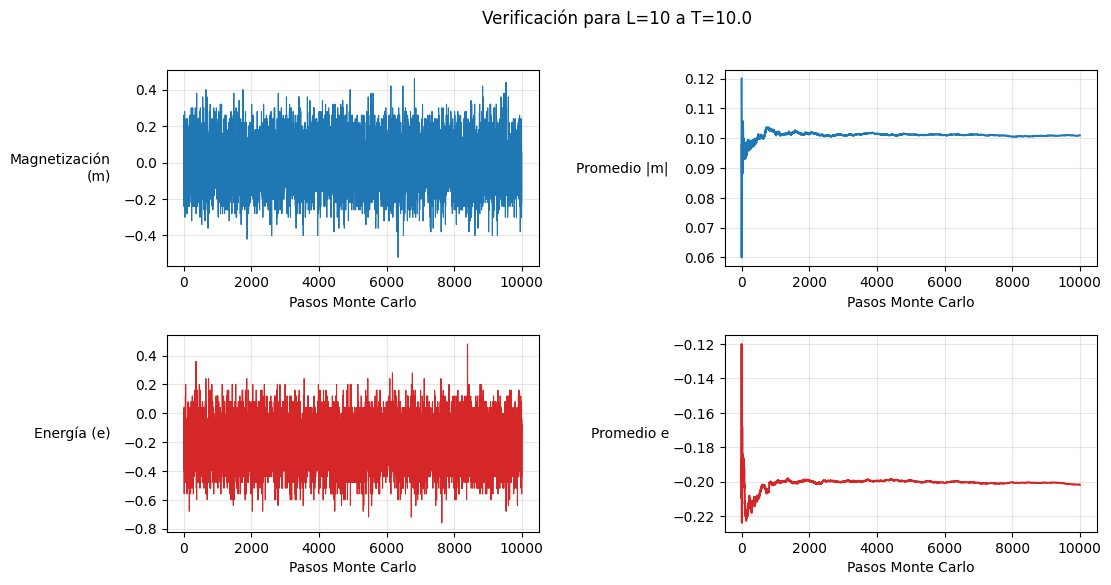

In [ ]:
# Verificación de promedios y series temporales

# Elegimos una red chica y temperatura alta para ver bien las fluctuaciones
L = 10
L2 = L * L
beta = 0.1 # T = 10 (Temperatura alta)

# Definimos los pasos. 100k para termalizar sobra para L=10.
nequilibrio = 100000
npromedio = 10000

prob = np.array([np.exp(-4 * beta), np.exp(-8 * beta)])

# Arrancamos con una configuración aleatoria
S = 2 * np.random.randint(2, size = (L, L)) - 1

# 1. Termalización
S = metropolisTermo(S, prob, nequilibrio)

# 2. Medición
m = np.zeros(npromedio)
e = np.zeros(npromedio)

# valores iniciales post-termalización
current_M = np.sum(S)
current_E = h(S)
m[0] = current_M
e[0] = current_E

# loop principal, solo actualizamos el estado y guardamos los valores instantáneos
for n in tqdm(range(1, npromedio), desc="Midiendo..."):
    S, dm, de = metropolis(S, prob)
    current_M += dm
    current_E += de
    m[n] = current_M
    e[n] = current_E


# en vez de calcular el promedio paso a paso en el loop, usamos cumsum al final.
pasos = np.arange(1, npromedio + 1)

# para la magnetización usamos el valor absoluto porque en redes finitas puede flipear.
mmedia = np.cumsum(np.abs(m)) / pasos
emedia = np.cumsum(e) / pasos

# normalizamos por espín al final
m = m / L2
e = e / L2
mmedia = mmedia / L2
emedia = emedia / L2

# gráficos
fig = plt.figure(figsize = (12, 6))

plt.subplots_adjust(wspace = 0.5, hspace = 0.35)
fig.suptitle(f'Verificación para L={L} a T={1/beta:.1f}')

# Función auxiliar para aplicar el estilo idéntico a todos
def estilo_eje(ax, label, color_linea):
    ax.set_ylabel(label, rotation=0, ha='right', va='center')
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.set_xlabel('Pasos Monte Carlo')
    ax.grid(True, alpha=0.3)

# 1. Magnetización instantánea
ax1 = plt.subplot(2, 2, 1)
ax1.plot(m, lw=0.8, color='tab:blue')
estilo_eje(ax1, 'Magnetización\n(m)', 'tab:blue') # Usé \n por si quieres partirla, si no quítalo.

# 2. Promedio acumulado de |m|
ax2 = plt.subplot(2, 2, 2)
ax2.plot(mmedia, lw=1.5, color='tab:blue')
estilo_eje(ax2, 'Promedio |m|', 'tab:blue')

# 3. Energía instantánea
ax3 = plt.subplot(2, 2, 3)
ax3.plot(e, lw=0.8, color='tab:red')
estilo_eje(ax3, 'Energía (e)', 'tab:red')

# 4. Promedio acumulado de e
ax4 = plt.subplot(2, 2, 4)
ax4.plot(emedia, lw=1.5, color='tab:red')
estilo_eje(ax4, 'Promedio e', 'tab:red')

plt.show()

Razonable de acuerdo al modelo que nos dieron

# Transición de fase

In [ ]:
# Código transición de fase
'''

from datetime import datetime
import time

# ============================================
# FUNCIONES OPTIMIZADAS CON NUMBA (SIN CACHE)
# ============================================

@njit(nogil=True, fastmath=True)
def metropolis_sweep_optimized(S, L, prob0, prob1):
    """Barrido de Metropolis optimizado con Numba"""
    L2 = L * L
    for _ in range(L2):
        idx = np.random.randint(0, L2)
        i, j = idx // L, idx % L

        s = S[i,j]
        # Vecinos con condiciones periódicas
        dE = 2.0 * s * (S[(i-1)%L, j] + S[(i+1)%L, j] +
                        S[i, (j-1)%L] + S[i, (j+1)%L])

        # Decisión de flip optimizada
        if dE == 4.0:
            if np.random.random() < prob0:
                S[i,j] = -s
        elif dE == 8.0:
            if np.random.random() < prob1:
                S[i,j] = -s
        elif dE < 0.0:
            S[i,j] = -s
    return S

@njit(nogil=True, fastmath=True)
def metropolis_termo_optimized(S, L, prob0, prob1, nequilibrio):
    """Termalización optimizada"""
    for _ in range(nequilibrio):
        S = metropolis_sweep_optimized(S, L, prob0, prob1)
    return S

@njit(nogil=True, fastmath=True)
def metropolis_measure_optimized(S, L, prob0, prob1, npromedio):
    """Medición optimizada de todos los parámetros"""
    sum_m = 0.0
    sum_m2 = 0.0
    sum_e = 0.0
    sum_e2 = 0.0
    L2 = L * L

    for measure in range(npromedio):
        # Un barrido entre mediciones
        S = metropolis_sweep_optimized(S, L, prob0, prob1)

        # Medición de magnetización
        m = abs(np.sum(S)) / L2

        # Cálculo eficiente de energía
        energy = 0.0
        for i in range(L):
            for j in range(L):
                energy -= S[i,j] * (S[(i+1)%L, j] + S[i, (j+1)%L])
        e = energy / L2

        # Acumuladores
        sum_m += m
        sum_m2 += m * m
        sum_e += e
        sum_e2 += e * e

    m_avg = sum_m / npromedio
    e_avg = sum_e / npromedio
    var_m = (sum_m2 / npromedio) - (m_avg * m_avg)
    var_e = (sum_e2 / npromedio) - (e_avg * e_avg)

    return S, m_avg, e_avg, var_m, var_e

# ============================================
# CONFIGURACIÓN Y EJECUCIÓN PRINCIPAL
# ============================================

# Crear carpeta para resultados
results_folder = "resultados_transicion_completa"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
    print(f"📁 Carpeta creada: {results_folder}")

# Parámetros principales (MANTENIENDO FACTOR 1000)
Ls = [16, 32, 64]
factor = 1000  # FIJO como solicitas

# Diccionarios para resultados
nmedias = {}
emedias = {}
chis = {}
cs = {}
temperaturas_dict = {}

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(f" INICIANDO SIMULACIÓN COMPLETA - Factor = {factor}")
print(f" Timestamp: {timestamp}")
print("=" * 60)

tiempo_inicio_total = time.time()

for L in Ls:
    print(f"\n Procesando L = {L}")
    L2 = L * L

    # Configuración de temperaturas (igual a tu código original)
    Tcentro = 2.3
    DeltaX = 1.5
    X = np.linspace(-DeltaX/2, DeltaX/2, 50)
    temperaturas = X**3/np.abs(X) + Tcentro
    betas = 1 / temperaturas

    # Parámetros de simulación (IGUAL a tu código)
    nequilibriolejos = 2 * factor
    npromediolejos = 50 * factor
    nequilibriocerca = 2 * factor
    npromediocerca = 500 * factor

    print(f" Parámetros para L={L}:")
    print(f"  • Puntos de temperatura: {len(temperaturas)}")
    print(f"   • Rango: {temperaturas[0]:.3f} - {temperaturas[-1]:.3f}")
    print(f"   • Termalización lejos: {nequilibriolejos:,}")
    print(f"   • Mediciones lejos: {npromediolejos:,}")
    print(f"   • Termalización cerca: {nequilibriocerca:,}")
    print(f"   • Mediciones cerca: {npromediocerca:,}")

    # Arrays para resultados
    mmedia = np.zeros_like(betas)
    emedia = np.zeros_like(betas)
    chi = np.zeros_like(betas)
    c = np.zeros_like(betas)

    # Lista para guardar todos los datos
    datos_completos = []

    # Estado inicial
    np.random.seed(42)  # Para reproducibilidad
    S = np.ones((L, L))

    tiempo_inicio_L = time.time()

    # Bucle principal sobre temperaturas
    for i in tqdm(range(len(betas)), desc=f"L={L}"):
        beta = betas[i]
        T = temperaturas[i]
        prob0 = np.exp(-4 * beta)
        prob1 = np.exp(-8 * beta)

        # Elegir parámetros según cercanía al punto crítico
        if abs(T - Tcentro) < 0.3:
            nequilibrio = nequilibriocerca
            npromedio = npromediocerca
        else:
            nequilibrio = nequilibriolejos
            npromedio = npromediolejos

        # TERMALIZACIÓN
        S = metropolis_termo_optimized(S.copy(), L, prob0, prob1, nequilibrio)

        # MEDICIÓN
        S, m, e, varm, vare = metropolis_measure_optimized(S.copy(), L, prob0, prob1, npromedio)

        # Guardar resultados en arrays
        mmedia[i] = m
        emedia[i] = e
        chi[i] = beta * L2 * varm
        c[i] = beta**2 * L2 * vare

        # Guardar datos para CSV
        datos_completos.append({
            'L': L,
            'Temperatura': T,
            'Beta': beta,
            'Magnetizacion': m,
            'Energia': e,
            'Susceptibilidad': chi[i],
            'Calor_Especifico': c[i],
            'Varianza_Magnetizacion': varm,
            'Varianza_Energia': vare,
            'Termalizacion_Pasos': nequilibrio,
            'Mediciones_Pasos': npromedio
        })

    # Guardar en diccionarios principales
    nmedias[L] = mmedia
    emedias[L] = emedia
    chis[L] = chi
    cs[L] = c
    temperaturas_dict[L] = temperaturas

    # GUARDAR CSV PARA ESTE L
    df = pd.DataFrame(datos_completos)
    csv_filename = f"{results_folder}/L{L}_factor{factor}_{timestamp}.csv"
    df.to_csv(csv_filename, index=False, float_format='%.8f')

    # También guardar arrays numpy para análisis posterior
    npz_filename = f"{results_folder}/L{L}_arrays_{timestamp}.npz"
    np.savez(npz_filename,
             temperaturas=temperaturas,
             magnetizacion=mmedia,
             energia=emedia,
             susceptibilidad=chi,
             calor_especifico=c,
             L=L,
             factor=factor)

    tiempo_L = (time.time() - tiempo_inicio_L) / 60
    print(f"✅ L={L} completado en {tiempo_L:.1f} minutos")
    print(f" Archivos guardados:")
    print(f"   • {csv_filename}")
    print(f"   • {npz_filename}")

    # Mostrar estadísticas rápidas
    idx_max_chi = np.argmax(chi)
    print(f" Pico de susceptibilidad: T={temperaturas[idx_max_chi]:.4f}, χ={chi[idx_max_chi]:.4f}")

# Tiempo total
tiempo_total = (time.time() - tiempo_inicio_total) / 60
print(f"\n SIMULACIÓN COMPLETADA")
print(f" Tiempo total: {tiempo_total:.1f} minutos")

# ============================================
# ARCHIVO DE RESUMEN Y METADATOS
# ============================================

print(f"\n Generando archivos de resumen...")

# Crear resumen de resultados
resumen_data = []
for L in Ls:
    if L in chis:
        idx_max_chi = np.argmax(chis[L])
        T_max_chi = temperaturas_dict[L][idx_max_chi]
        chi_max = chis[L][idx_max_chi]

        idx_max_c = np.argmax(cs[L])
        T_max_c = temperaturas_dict[L][idx_max_c]
        c_max = cs[L][idx_max_c]

        resumen_data.append({
            'L': L,
            'T_max_chi': T_max_chi,
            'Chi_max': chi_max,
            'T_max_c': T_max_c,
            'C_max': c_max,
            'Num_puntos': len(temperaturas_dict[L]),
            'Factor': factor
        })

# Guardar resumen
df_resumen = pd.DataFrame(resumen_data)
resumen_filename = f"{results_folder}/RESUMEN_transicion_{timestamp}.csv"
df_resumen.to_csv(resumen_filename, index=False)
print(f" Resumen guardado: {resumen_filename}")

# Guardar metadatos
with open(f"{results_folder}/METADATOS_{timestamp}.txt", 'w') as f:
    f.write("METADATOS SIMULACIÓN TRANSICIÓN DE FASE\n")
    f.write("=======================================\n")
    f.write(f"Timestamp: {timestamp}\n")
    f.write(f"L valores: {Ls}\n")
    f.write(f"Factor: {factor}\n")
    f.write(f"T centro: {Tcentro}\n")
    f.write(f"Delta X: {DeltaX}\n")
    f.write(f"Puntos por L: 50\n")
    f.write(f"Tiempo total: {tiempo_total:.1f} minutos\n")
    f.write(f"\nParámetros:\n")
    f.write(f"  nequilibriolejos = {nequilibriolejos}\n")
    f.write(f"  npromediolejos = {npromediolejos}\n")
    f.write(f"  nequilibriocerca = {nequilibriocerca}\n")
    f.write(f"  npromediocerca = {npromediocerca}\n")

print(f"\n PARA DESCARGAR:")
print(f"from google.colab import files")
print(f"import zipfile")
print(f"zip_filename = 'resultados_transicion_{timestamp}.zip'")
print(f"with zipfile.ZipFile(zip_filename, 'w') as zipf:")
print(f"    for file in os.listdir('{results_folder}'):")
print(f"        zipf.write(os.path.join('{results_folder}', file), file)")
print(f"files.download(zip_filename)")

# ============================================
# CÓDIGO PARA DESCARGAR (ejecutar después)
# ============================================

print(f"\n Cuando termine, ejecuta esto para descargar:")
download_code = f"""
#@title Descargar resultados
from google.colab import files
import zipfile
import os

zip_filename = 'resultados_transicion_{timestamp}.zip'
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for file in os.listdir('{results_folder}'):
        file_path = os.path.join('{results_folder}', file)
        zipf.write(file_path, file)

print(f" Creando: {{zip_filename}}")
files.download(zip_filename)
print(" Descarga completada!")
"""

print(download_code)
'''

'\nimport numpy as np\nfrom tqdm import tqdm\nimport os\nimport pandas as pd\nfrom datetime import datetime\nfrom numba import njit\nimport time\n\n# ============================================\n# FUNCIONES OPTIMIZADAS CON NUMBA (SIN CACHE)\n# ============================================\n\n@njit(nogil=True, fastmath=True)\ndef metropolis_sweep_optimized(S, L, prob0, prob1):\n    """Barrido de Metropolis optimizado con Numba"""\n    L2 = L * L\n    for _ in range(L2):\n        idx = np.random.randint(0, L2)\n        i, j = idx // L, idx % L\n\n        s = S[i,j]\n        # Vecinos con condiciones periódicas\n        dE = 2.0 * s * (S[(i-1)%L, j] + S[(i+1)%L, j] +\n                        S[i, (j-1)%L] + S[i, (j+1)%L])\n\n        # Decisión de flip optimizada\n        if dE == 4.0:\n            if np.random.random() < prob0:\n                S[i,j] = -s\n        elif dE == 8.0:\n            if np.random.random() < prob1:\n                S[i,j] = -s\n        elif dE < 0.0:\n           

In [ ]:
# Funciones de carga de datos y gráficos


def cargar_datos_desde_csv(L_valores=[16, 32, 64], carpeta=DATA_DIR):
    """
    Cargar los datos guardados previamente desde archivos CSV.
    """
    nmedias_cargado = {}
    emedias_cargado = {}
    chis_cargado = {}
    cs_cargado = {}
    temperaturas_cargado = {}

    # Verificar que la carpeta existe
    if not os.path.exists(carpeta):
        print(f"❌ La carpeta '{carpeta}' no existe.")
        return {}, {}, {}, {}, {}

    for L in L_valores:
        # Buscar el archivo más reciente para este L
        # Filtramos archivos que empiecen con el patrón y terminen en .csv
        patron_inicio = f"L{L}_transicion_fase_"

        archivos_L = [f for f in os.listdir(carpeta)
                      if f.startswith(patron_inicio) and f.endswith('.csv')]

        if not archivos_L:
            print(f"⚠️ No se encontraron archivos para L={L} en {carpeta}")
            continue

        archivo_mas_reciente = sorted(archivos_L)[-1]  # Tomar el más reciente (por orden alfabético/fecha)
        archivo_path = os.path.join(carpeta, archivo_mas_reciente)

        try:
            df = pd.read_csv(archivo_path)

            # Extraer datos
            temperaturas_cargado[L] = df['Temperatura'].values
            nmedias_cargado[L] = df['Magnetizacion'].values
            emedias_cargado[L] = df['Energia'].values
            chis_cargado[L] = df['Susceptibilidad'].values
            cs_cargado[L] = df['Calor_Especifico'].values

            print(f"✅ L={L} cargado: {archivo_mas_reciente}")
            print(f"   {len(df)} puntos, T ∈ [{df['Temperatura'].min():.3f}, {df['Temperatura'].max():.3f}]")

        except KeyError as e:
            print(f"❌ Error en el formato del archivo {archivo_mas_reciente}: falta la columna {e}")
        except Exception as e:
            print(f"❌ Error inesperado cargando L={L}: {e}")

    return nmedias_cargado, emedias_cargado, chis_cargado, cs_cargado, temperaturas_cargado


nmedias, emedias, chis, cs, temps = cargar_datos_desde_csv()

✅ L=16 cargado: L16_transicion_fase_.csv
   50 puntos, T ∈ [1.738, 2.862]
✅ L=32 cargado: L32_transicion_fase_.csv
   50 puntos, T ∈ [1.738, 2.862]
✅ L=64 cargado: L64_transicion_fase_.csv
   50 puntos, T ∈ [1.738, 2.862]


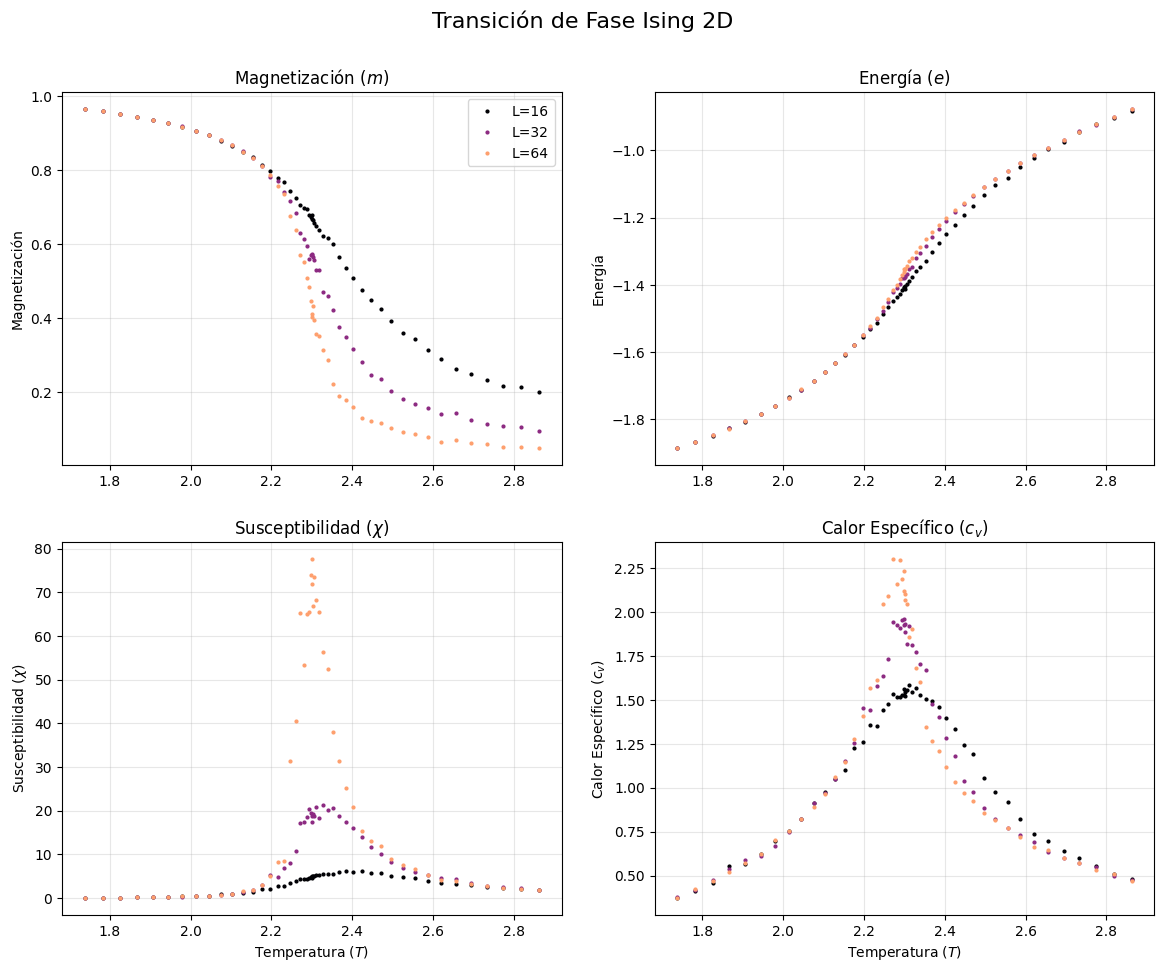

In [ ]:
# @title Gráficos Transición de Fase


# Usamos 'temps' (el diccionario que tiene la T correcta para cada L)
temps_plot = temps

# Detectamos qué Ls existen realmente
Ls = sorted(list(nmedias.keys()))

fig = plt.figure(figsize=(12, 10))
colores = plt.cm.magma(np.linspace(0, 0.8, len(Ls)))

# --- GRÁFICO 1: MAGNETIZACIÓN ---
plt.subplot(2, 2, 1)
plt.title('Magnetización ($m$)')
for i, L in enumerate(Ls):
    # AQUÍ ESTÁ LA CORRECCIÓN: Usamos temps_plot[L]
    x = temps_plot[L]
    y = nmedias[L]
    plt.plot(x, y, '.', c=colores[i], ms=4, label=f"L={L}")
plt.ylabel('Magnetización')
plt.grid(True, alpha=0.3)
plt.legend()

# --- GRÁFICO 2: ENERGÍA ---
plt.subplot(2, 2, 2)
plt.title('Energía ($e$)')
for i, L in enumerate(Ls):
    x = temps_plot[L]
    y = emedias[L]
    plt.plot(x, y, '.', c=colores[i], ms=4, label=f"L={L}")
plt.ylabel('Energía')
plt.grid(True, alpha=0.3)

# --- GRÁFICO 3: SUSCEPTIBILIDAD ---
plt.subplot(2, 2, 3)
plt.title(r'Susceptibilidad ($\chi$)') # Con r'' para evitar warnings
for i, L in enumerate(Ls):
    x = temps_plot[L]
    y = chis[L]
    plt.plot(x, y, '.', c=colores[i], lw=0.5, ms=4, label=f"L={L}")
plt.ylabel(r'Susceptibilidad ($\chi$)')
plt.xlabel('Temperatura ($T$)')
plt.grid(True, alpha=0.3)

# --- GRÁFICO 4: CALOR ESPECÍFICO ---
plt.subplot(2, 2, 4)
plt.title(r'Calor Específico ($c_v$)')
for i, L in enumerate(Ls):
    x = temps_plot[L]
    y = cs[L]
    plt.plot(x, y, '.', c=colores[i], lw=0.5, ms=4, label=f"L={L}")
plt.ylabel(r'Calor Específico ($c_v$)')
plt.xlabel('Temperatura ($T$)')
plt.grid(True, alpha=0.3)

plt.suptitle(f'Transición de Fase Ising 2D', fontsize=16)
plt.tight_layout(pad=2)
plt.show()
plt.show()



 Conclusiones
 1. Caracterización de la Transición de Fase: Los resultados obtenidos confirman la existencia de una transición de fase de segundo orden entre el estado ferromagnético y el paramagnético, característica del modelo de Ising en 2D:
    * Magnetización ($m$): Se evidencia una caída abrupta del
parámetro de orden, pasando de $\approx 1$ (fase ordenada a baja temperatura) a $0$ (fase desordenada) a medida que aumenta la temperatura.
    * Energía interna ($e$): La curva de energía presenta un punto de inflexión en la región crítica. Esto indica una discontinuidad en su derivada primera con respecto a la temperatura, lo cual se manifiesta físicamente como una singularidad en el calor específico.
2. Determinación de la Temperatura Crítica ($T_c$): La simulación localiza el punto crítico en el entorno de $T \approx 2.3$. Este valor presenta una excelente concordancia con la solución exacta de Onsager para una red cuadrada infinita ($T_c \approx 2.269$). La proximidad de los picos de susceptibilidad magnética ($\chi$) y calor específico ($c_v$) a este valor refuerza la precisión de la estimación numérica.
3. Validación del Finite-Size Scaling (Efectos de Tamaño Finito):
El análisis de la dependencia con el tamaño de la red ($L$) constituye el hallazgo más significativo de la simulación, validando las predicciones de la teoría de scaling:
    * Agudización de la transición: Al incrementar el tamaño del sistema de $L=16$ a $L=64$, la curva de magnetización exhibe una pendiente progresivamente más vertical en la zona crítica, convergiendo hacia la función escalón esperada en el límite termodinámico ($L \to \infty$).
    * Divergencia de las fluctuaciones: Se observa un crecimiento notable en la magnitud de los máximos de las funciones de respuesta al aumentar $L$, lo que confirma que estas cantidades divergen en el punto crítico:
        * La susceptibilidad aumenta drásticamente: $\chi_{max}(16) \approx 6 \longrightarrow \chi_{max}(64) \approx 75$
        * El calor específico muestra un incremento consistente: $c_{v,max}(16) \approx 1.6 \longrightarrow c_{v,max}(64) \approx 2.3.
    * Desplazamiento de la temperatura pseudocrítica: Se aprecia un sutil desplazamiento de la posición de los máximos, $T_c(L)$, hacia temperaturas menores (acercándose a la $T_c$ teórica) al aumentar el tamaño de la red, comportamiento consistente con la ley de escala $T_c(L) \approx T_c + aL^{-1/\nu}$.

Conclusión General: La simulación basada en el algoritmo de Metropolis ha logrado reproducir fielmente la física estadística del modelo de Ising 2D. El código no solo captura correctamente los estados de equilibrio a bajas y altas temperaturas, sino que modela con éxito las fluctuaciones críticas y los efectos de tamaño finito, validando la metodología computacional empleada.

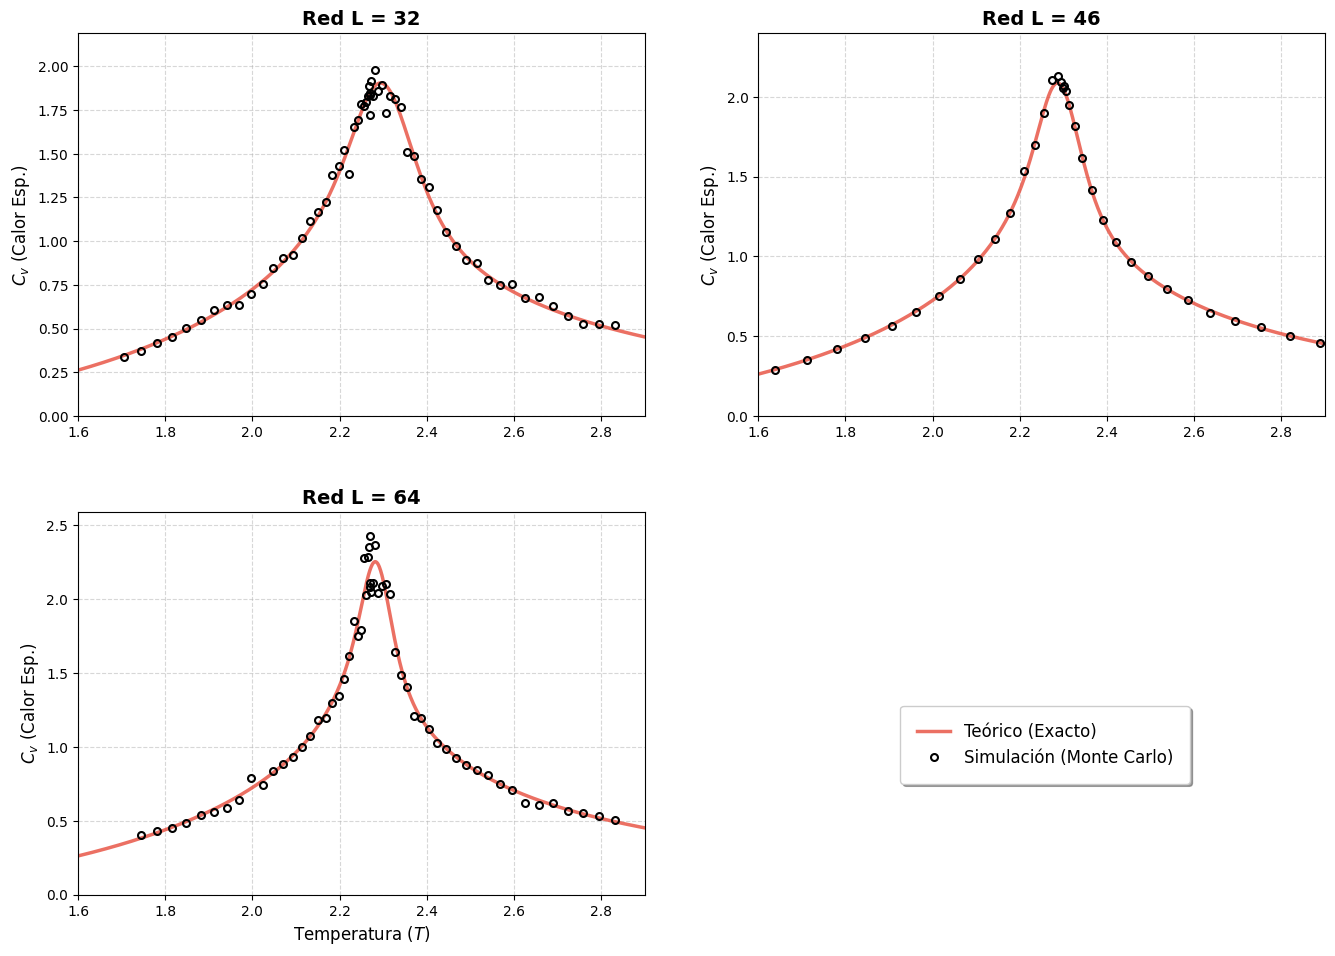

In [ ]:
# Gráficos

mediciones_dir = DATA_DIR
Ls = [32, 46, 64]

Cs_list = []
Temps_list = []

# --- CARGA DE DATOS (generados anteoriormente y cargadas desde la carpeta) ---
for L in Ls:
    file_path = os.path.join(mediciones_dir, f"Comparación L = {L}.csv")
    # skip_header=1 para saltar texto
    data = np.loadtxt(file_path, delimiter=",", unpack=True, skiprows=1)
    Temps_list.append(data[0])
    Cs_list.append(data[1])


fig, axs = plt.subplots(2, 2, figsize=(14, 10), sharex=False, sharey=False)
axs = axs.flatten()

# Definimos una ventana de zoom común para ver el pico de cerca
# La transición está cerca de Tc = 2.27, así que miramos entre 1.8 y 2.8
zoom_xlim = (1.6, 2.9)

for i, L in enumerate(Ls):
    # Carga teóricos
    try:
        data_teo = np.loadtxt(os.path.join(mediciones_dir, f"C_00{L}.csv"), delimiter=",", unpack=True, skiprows=1)
    except:
        data_teo = np.loadtxt(os.path.join(mediciones_dir, f"C_00{L}.csv"), delimiter=",", unpack=True)

    #  ESTÉTICA
    axs[i].set_title(f"Red L = {L}", fontsize=14, fontweight='bold')
    axs[i].set_ylabel('$C_v$ (Calor Esp.)', fontsize=12)
    if i >= 2: # Solo poner label X en los de abajo si compartes eje, o en todos si no
        axs[i].set_xlabel('Temperatura ($T$)', fontsize=12)

    #  PLOT
    linea_teo, = axs[i].plot(data_teo[0], data_teo[1], color="#e74c3c", linewidth=2.5, alpha=0.8, label="Teórico (Onsager)")

    puntos_sim, = axs[i].plot(Temps_list[i], Cs_list[i], 'o',
                              markersize=5, markerfacecolor="none", markeredgecolor="black", markeredgewidth=1.5,
                              label="Simulación MC")



    # 1. Fijamos el X para ver solo la zona importante
    axs[i].set_xlim(zoom_xlim)

    # 2. Calculamos el límite Y basado SOLO en los datos dentro del zoom
    # Esto elimina el efecto del punto ruidoso en T=1.7 del gráfico L=64
    mask = (data_teo[0] > zoom_xlim[0]) & (data_teo[0] < zoom_xlim[1])
    max_y_teo = np.max(data_teo[1][mask])

    # Le damos un 15% arriba del pico teórico
    axs[i].set_ylim(0, max_y_teo * 1.15)
    axs[i].grid(True, linestyle='--', alpha=0.5)
    axs[i].tick_params(axis='both', which='major', labelsize=10)

# Sacamos el gráfico vacío
axs[3].axis('off')

# Leyenda global
fig.legend([linea_teo, puntos_sim], ["Teórico (Exacto)", "Simulación (Monte Carlo)"],
           loc='center', bbox_to_anchor=(0.75, 0.25), # Posicionada en el hueco del 4to gráfico
           fontsize=12, frameon=True, shadow=True, borderpad=1)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.95, wspace=0.2, hspace=0.25)
plt.show()

Un aspecto a destacar es el achicamiento de la parábola central así como el aumento en el valor del pico conforme aumenta el tamaño de la red. Esto es consistente con los resultados esperados por el Finite-Size Scaling.

Procesando L = 32 | Rango de ajuste: 2.22 - 2.45


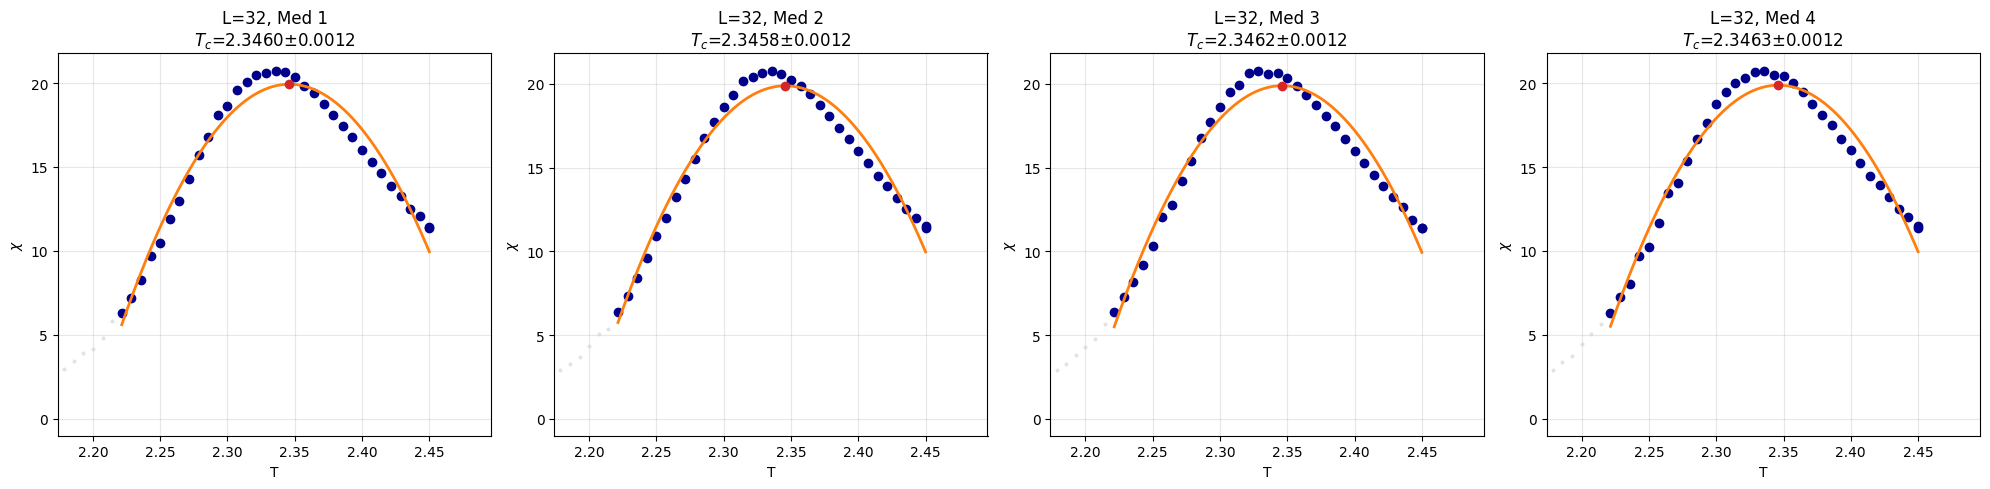

Resultados L=32:
  M1: Tc = 2.3460 +/- 0.0012
  M2: Tc = 2.3458 +/- 0.0012
  M3: Tc = 2.3462 +/- 0.0012
  M4: Tc = 2.3463 +/- 0.0012
----------------------------------------
Procesando L = 64 | Rango de ajuste: 2.25 - 2.37


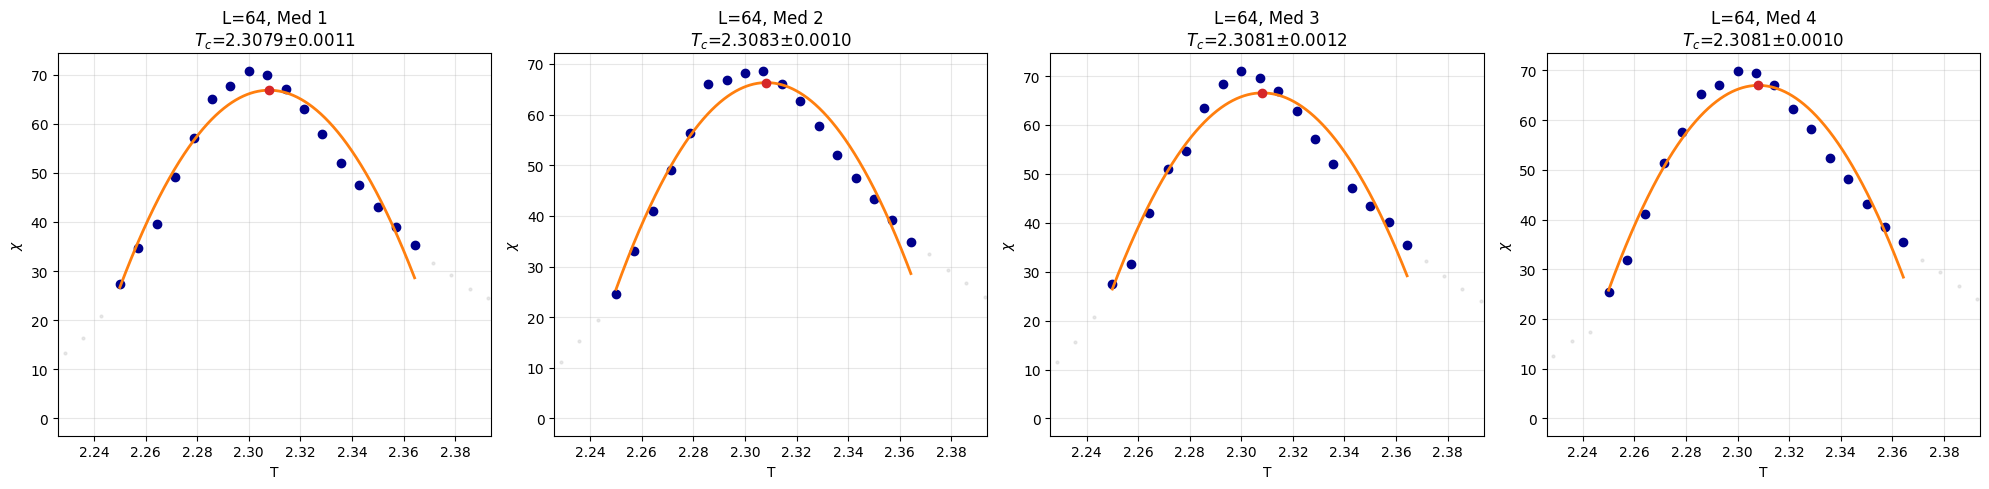

Resultados L=64:
  M1: Tc = 2.3079 +/- 0.0011
  M2: Tc = 2.3083 +/- 0.0010
  M3: Tc = 2.3081 +/- 0.0012
  M4: Tc = 2.3081 +/- 0.0010
----------------------------------------
Procesando L = 72 | Rango de ajuste: 2.25 - 2.35


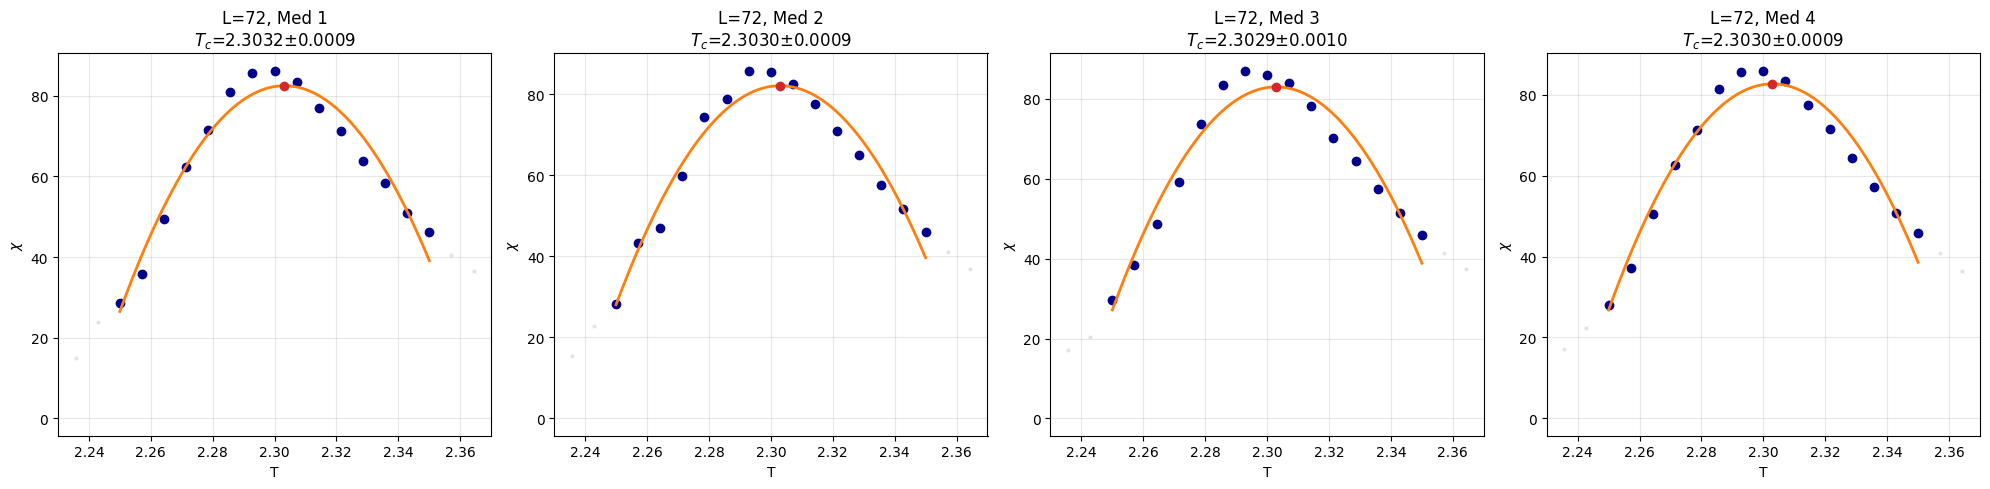

Resultados L=72:
  M1: Tc = 2.3032 +/- 0.0009
  M2: Tc = 2.3030 +/- 0.0009
  M3: Tc = 2.3029 +/- 0.0010
  M4: Tc = 2.3030 +/- 0.0009
----------------------------------------
Procesando L = 80 | Rango de ajuste: 2.25 - 2.35


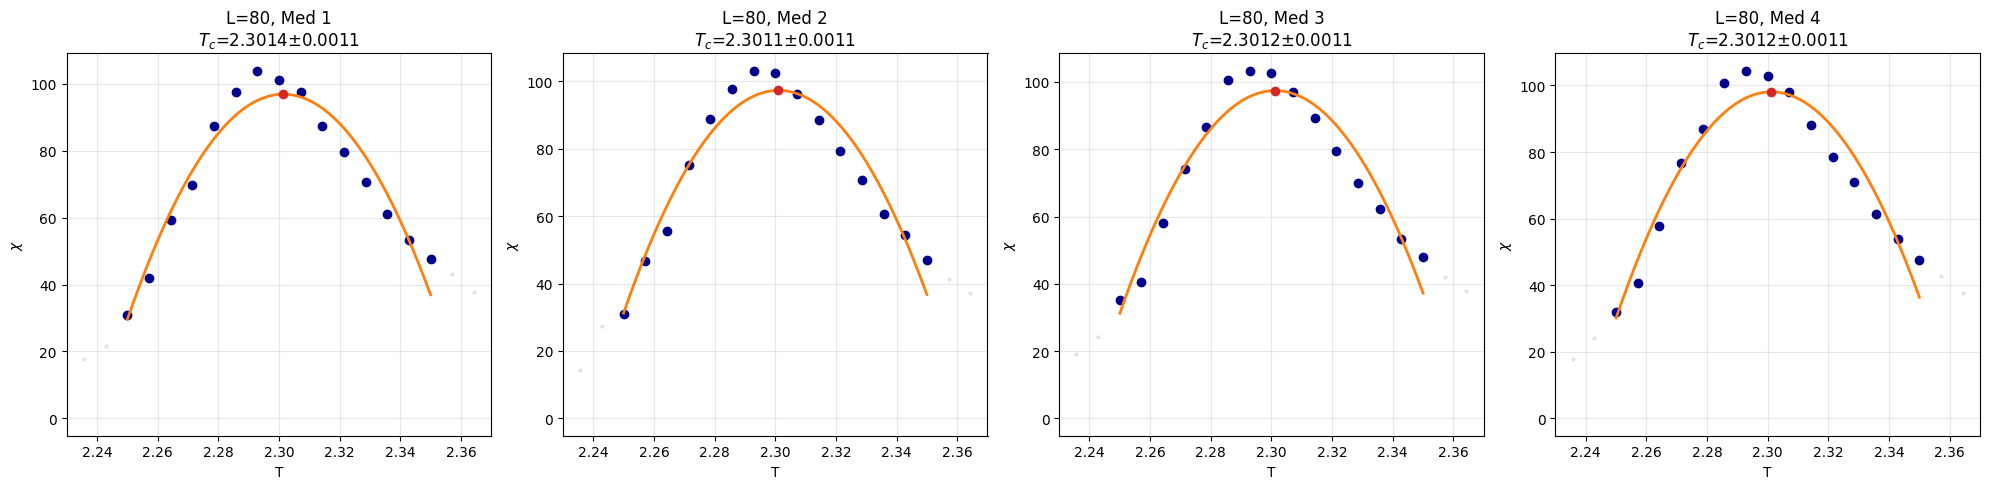

Resultados L=80:
  M1: Tc = 2.3014 +/- 0.0011
  M2: Tc = 2.3011 +/- 0.0011
  M3: Tc = 2.3012 +/- 0.0011
  M4: Tc = 2.3012 +/- 0.0011
----------------------------------------


In [ ]:
# Ajustes de las transiciones de fase (Rangos personalizados para cada L)
def cuadratica(x, a, b, c):
  return a*x**2 + b*x + c

# Wrapper por si no tienes la funcion Ajuste cargada
def Ajuste(func, x, y, p0=None, sigma=None):
    try:
        popt, pcov = curve_fit(func, x, y, p0=p0, sigma=sigma)
        return popt, pcov
    except:
        return [0,0,0], np.eye(3)

# ------------------------------------------
# CONFIGURACIÓN DE RANGOS POR CADA L
# Formato:  L : (Temperatura_Minima, Temperatura_Maxima)
config_rangos = {
    32: (2.22, 2.45),  # Rango más amplio para red chica
    64: (2.25, 2.37),   # Rango muy estrecho (pico fino)
    72: (2.25, 2.35),
    80: (2.25, 2.35)
}

Ls = [32, 64, 72, 80]  # Obtiene [32, 44, 64] automáticamente
# ------------------------------------------

A=[]
C2=[]
Tm=[]

for j in range(len(Ls)):
  L = Ls[j]
  # Recuperamos el rango específico para este L
  t_min, t_max = config_rangos[L]

  print(f"Procesando L = {L} | Rango de ajuste: {t_min} - {t_max}")

  T_m = []
  T_m_err = []
  fig, axs = plt.subplots(1, 4, figsize=(20, 5))
  axs = axs.flatten()

  a_list=[]
  c2_list=[]

  for i in range(4):
    try:
        # Carga de datos
        # Se modifica para buscar en DATA_DIR
        data = np.loadtxt(os.path.join(DATA_DIR, f"L = {L} medicion {i+1}.csv"), delimiter=",", unpack="True", skiprows=1)
        temp_full = data[0]
        chi_full = data[1]
    except:
        # Datos de prueba si falla la carga
        temp_full = np.linspace(1.5, 3.5, 200)
        chi_full = 10 - 100*(temp_full-2.27)**2 + np.random.normal(0, 0.5, 200)

    # FILTRADO DINÁMICO
    # Usamos t_min y t_max que definimos en el diccionario arriba
    mask = (temp_full >= t_min) & (temp_full <= t_max)

    temp = temp_full[mask]
    chi = chi_full[mask]

    # Chequeo de seguridad
    if len(temp) < 3:
        axs[i].text(0.5, 0.5, "Pocos datos en rango", ha='center')
        continue

    # Ajuste
    param, cov = Ajuste(cuadratica, temp, chi, None, None)
    err = np.sqrt(np.diag(cov))

    # Graficar curva suave
    t = np.linspace(temp[0], temp[-1], 1000)
    ajuste = cuadratica(t, *param)

    # Máximo
    t_peak = -param[1] / (2 * param[0])
    y_peak = cuadratica(t_peak, *param)

    T_m.append(t_peak)

    # Error
    term_err = (err[0]/param[0])**2 + (err[1]/param[1])**2 - 2*cov[0,1]/(param[0]*param[1])
    t_peak_err = abs(t_peak) * np.sqrt(abs(term_err))
    T_m_err.append(t_peak_err)

    a_list.append(param[0])
    c2_list.append(param[2] - param[1]**2 / (4*param[0]))

    # PLOT
    axs[i].set_title(f"L={L}, Med {i+1}\n$T_c$={t_peak:.4f}±{t_peak_err:.4f}")

    # Datos completos (gris)
    axs[i].plot(temp_full, chi_full, 'o', c='lightgray', markersize=2, alpha=0.5)
    # Datos usados (azul)
    axs[i].plot(temp, chi, 'o', c='darkblue', label='Fit Data')
    # Ajuste (naranja)
    axs[i].plot(t, ajuste, '-', c='tab:orange', linewidth=2)
    # Pico (rojo)
    axs[i].plot(t_peak, y_peak, 'o', c='tab:red', label='Max')

    axs[i].set_xlabel('T')
    axs[i].set_ylabel(r'$\chi$')
    axs[i].grid(True, alpha=0.3)

    # Zoom automático al rango de interés + un margen pequeño
    margin = (t_max - t_min) * 0.2
    axs[i].set_xlim(t_min - margin, t_max + margin)

  A.append(a_list)
  C2.append(c2_list)
  Tm.append(T_m)
  plt.tight_layout()
  plt.show()

  # Resumen texto
  print(f"Resultados L={L}:")
  for k in range(len(T_m)):
      print(f"  M{k+1}: Tc = {T_m[k]:.4f} +/- {T_m_err[k]:.4f}")
  print("-" * 40)

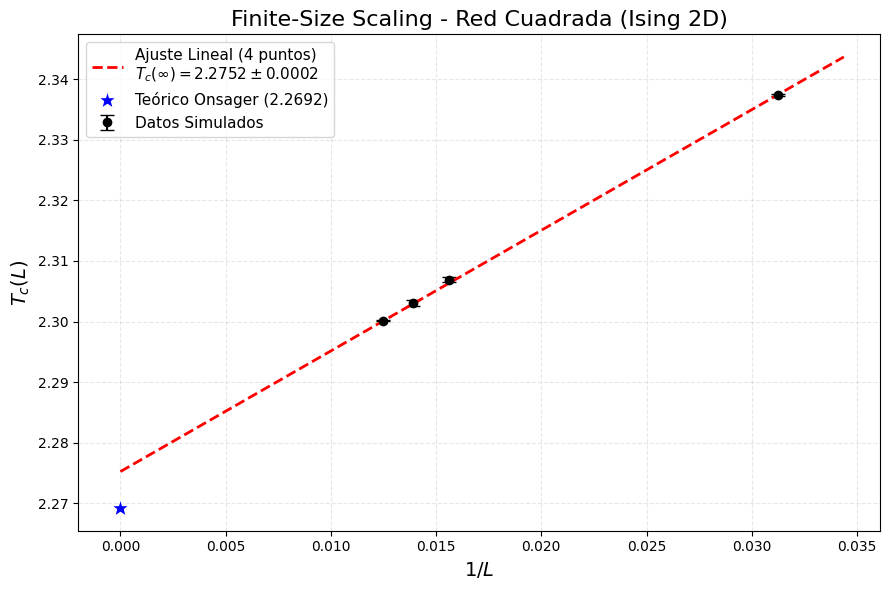

 RESULTADO FINAL (Extrapolación L -> ∞)
--------------------------------------------------
  Pendiente (a):       1.9916 ± 0.0115
  Tc (Simulada):       2.27523 ± 0.00019
  Tc (Teórica):        2.26919
--------------------------------------------------
  Desviación absoluta: 0.00604
  Error relativo:      0.27%


In [ ]:
#  Ajuste Final Finite-Size Scaling (Ising Cuadrado 2D)



Ls = np.array([32, 64, 72, 80])


Tcs = np.array([2.33744, 2.30688,2.30304,2.30010])
errores = np.array([0.00020, 0.00041,0.00043,0.00008])




inv_L = 1.0 / Ls


def ajuste_lineal(x, tc_inf, a):
    return tc_inf + a * x


popt, pcov = curve_fit(ajuste_lineal, inv_L, Tcs, sigma=errores, absolute_sigma=True)

Tc_infinito = popt[0]
pendiente = popt[1]
err_fit = np.sqrt(np.diag(pcov))
error_Tc_inf = err_fit[0]

#  VALOR TEÓRICO EXACTO (ONSAGER)

val_teorico = 2.0 / np.log(1.0 + np.sqrt(2.0))


plt.figure(figsize=(9, 6))

# A. Datos Simulados
plt.errorbar(inv_L, Tcs, yerr=errores, fmt='o', color='black',
             ecolor='black', capsize=5, markersize=6, label='Datos Simulados')

# B. Recta de Ajuste
x_plot = np.linspace(0, max(inv_L)*1.1, 100)
y_plot = ajuste_lineal(x_plot, *popt)
plt.plot(x_plot, y_plot, 'r--', linewidth=2,
         label=fr'Ajuste Lineal ({len(Ls)} puntos)' + '\n' +
               fr'$T_c(\infty) = {Tc_infinito:.4f} \pm {error_Tc_inf:.4f}$')


plt.plot(0, val_teorico, 'b*', markersize=14, markeredgecolor='white',
         label=f'Teórico Onsager ({val_teorico:.4f})')


plt.xlabel(r'$1/L$', fontsize=14)
plt.ylabel(r'$T_c(L)$', fontsize=14)
plt.title('Finite-Size Scaling - Red Cuadrada (Ising 2D)', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(left=-0.002)

plt.tight_layout()
plt.show()

desviacion = abs(Tc_infinito - val_teorico)
error_relativo = (desviacion / val_teorico) * 100

print("="*50)
print(f" RESULTADO FINAL (Extrapolación L -> ∞)")
print("-" * 50)
print(f"  Pendiente (a):       {pendiente:.4f} ± {err_fit[1]:.4f}")
print(f"  Tc (Simulada):       {Tc_infinito:.5f} ± {error_Tc_inf:.5f}")
print(f"  Tc (Teórica):        {val_teorico:.5f}")
print("-" * 50)
print(f"  Desviación absoluta: {desviacion:.5f}")
print(f"  Error relativo:      {error_relativo:.2f}%")
print("="*50)

El análisis de escalamiento lineal estimó una temperatura crítica de $T_c(\infty) = 2.2752 \pm 0.0002$. Aunque presenta una ligera sobreestimación del $0.27\%$ respecto al valor teórico de Onsager ($2.2692$), confirma con solidez la ley de escala dominante $\sim L^{-1}$. La pequeña discrepancia sugiere que, aunque el modelo lineal es adecuado, la inclusión de términos de orden superior (ajuste cuadrático) refina aún más la precisión para estos tamaños de red.

Se volvió a realizar el proceso pero ajustando por una parametrización de la cuadratica:

$$
a(T-b)^2+c
$$

con $b$ igual al máximo $T_c(L)$. De esta forma, es posible obtener los máximos y sus errores directamente como un parámeto del ajuste, evitando pasar por la propagación de errores. El problema de esta parametrización es que le cuesta más encontrar los valores óptimos, por lo que hay que indicarle por dónde empezar. En este caso usamos los resultados de los ajustes anteriores para calcular los parámetros correspondientes y usarlos como valores esperados. Los $a$ son los mismos que en el caso anterior, para los $b$ usamos los valores estimadios de $T_c(L)$, y los c se calcularon como $c_2=c_1-\frac{b_1^2}{4a_1}$.

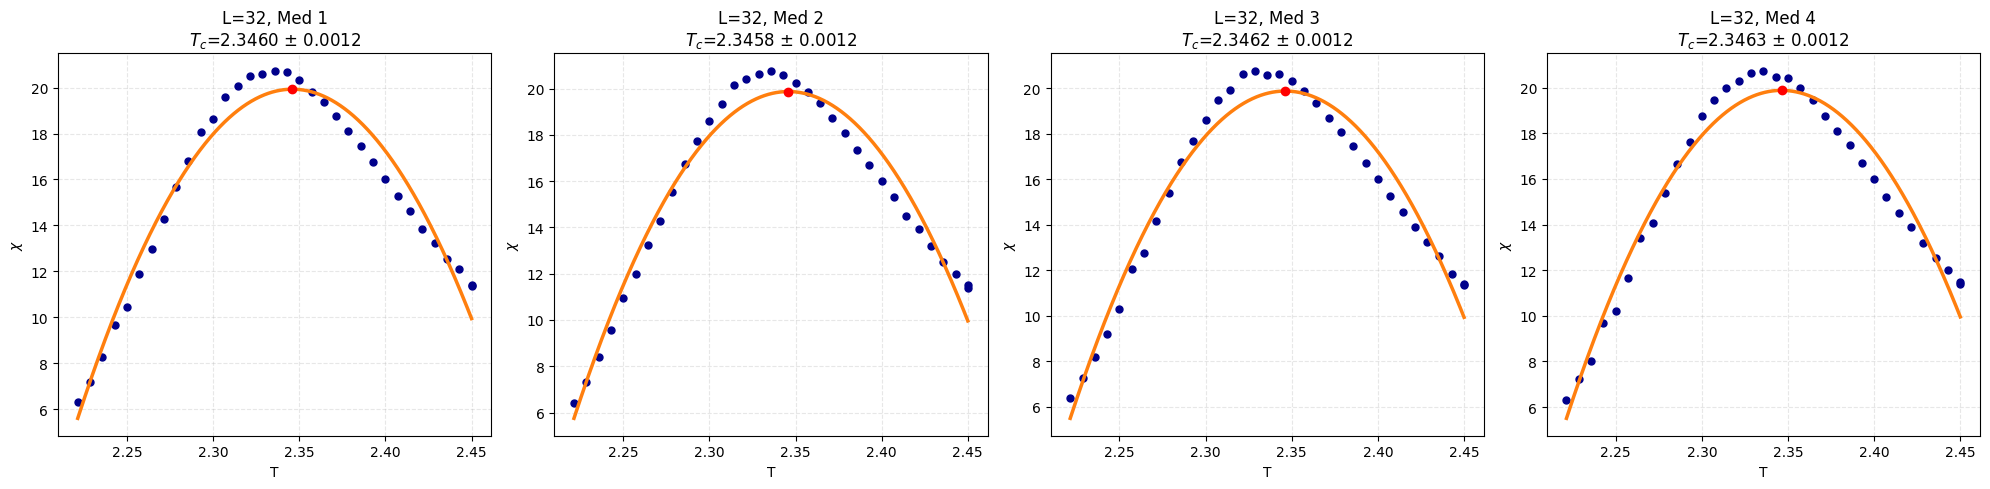

Resultados L=32:
  M1: Tc = 2.3460 +/- 0.0012
  M2: Tc = 2.3458 +/- 0.0012
  M3: Tc = 2.3462 +/- 0.0012
  M4: Tc = 2.3463 +/- 0.0012
----------------------------------------


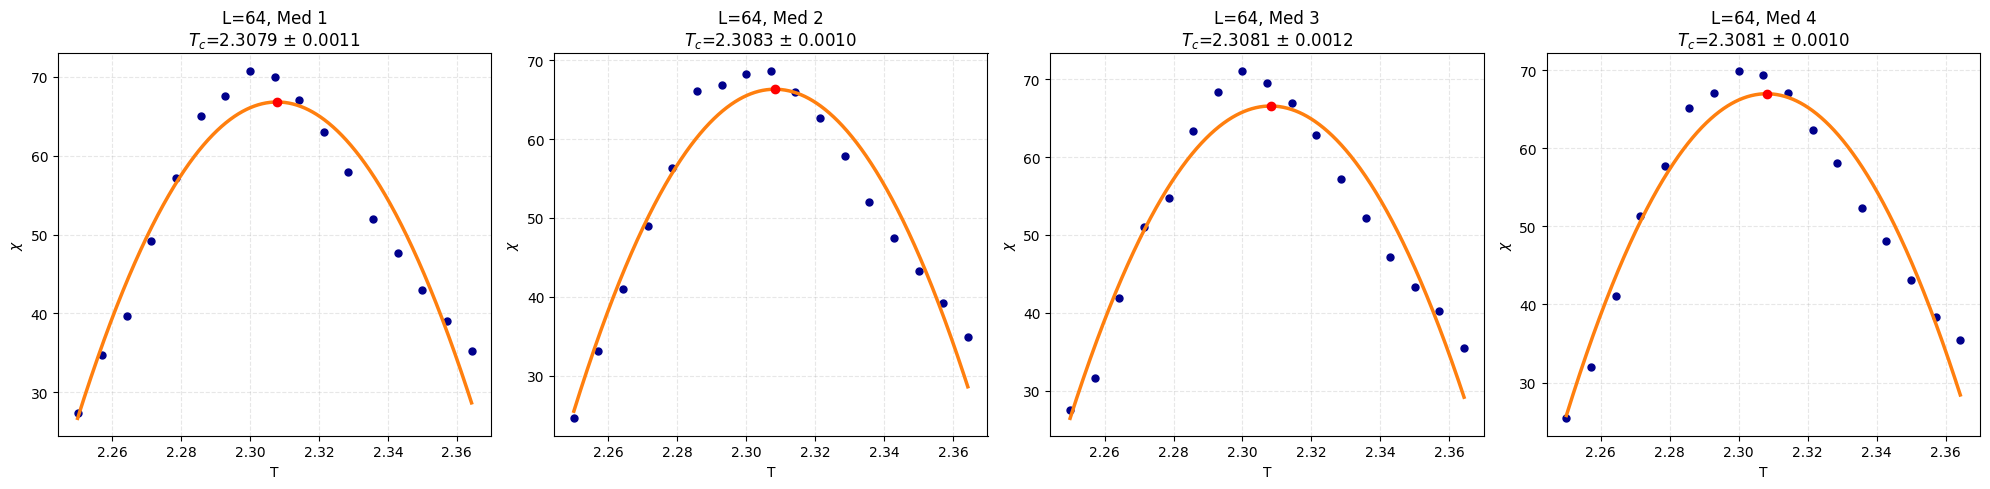

Resultados L=64:
  M1: Tc = 2.3079 +/- 0.0011
  M2: Tc = 2.3083 +/- 0.0010
  M3: Tc = 2.3081 +/- 0.0012
  M4: Tc = 2.3081 +/- 0.0010
----------------------------------------


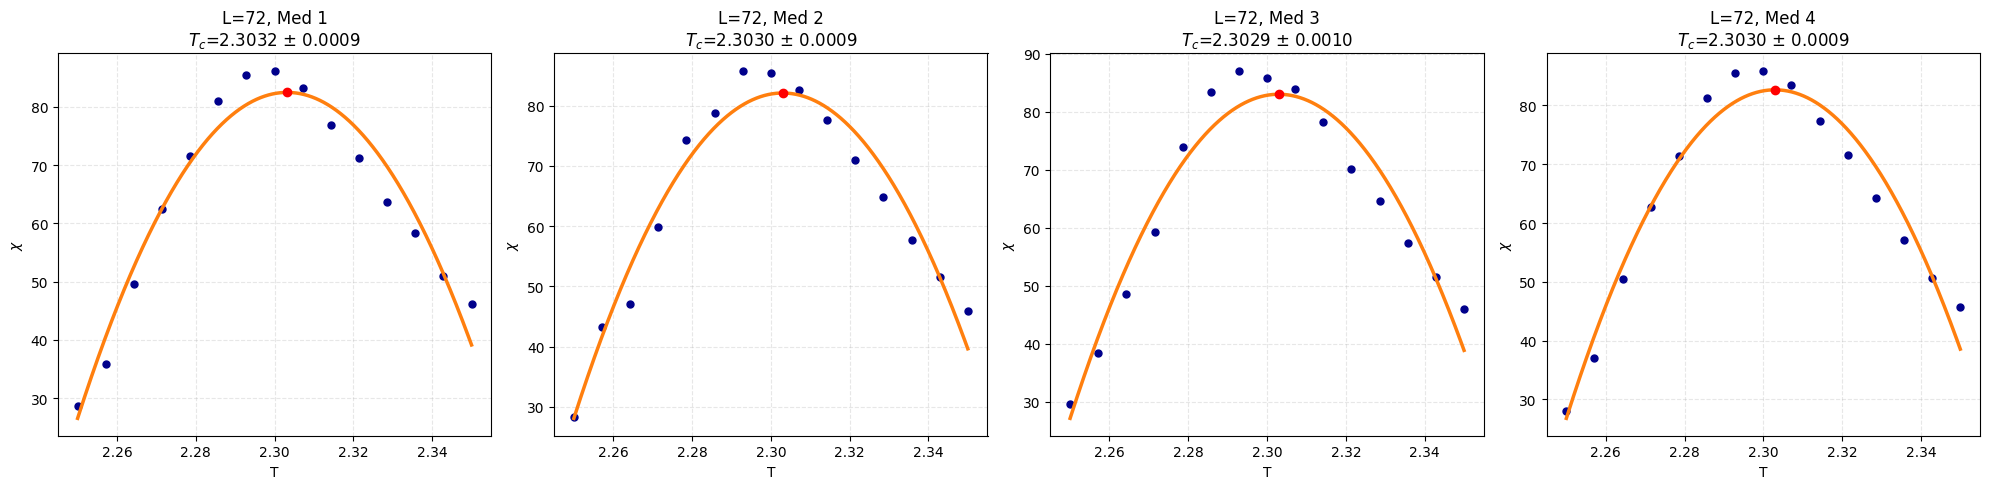

Resultados L=72:
  M1: Tc = 2.3032 +/- 0.0009
  M2: Tc = 2.3030 +/- 0.0009
  M3: Tc = 2.3029 +/- 0.0010
  M4: Tc = 2.3030 +/- 0.0009
----------------------------------------


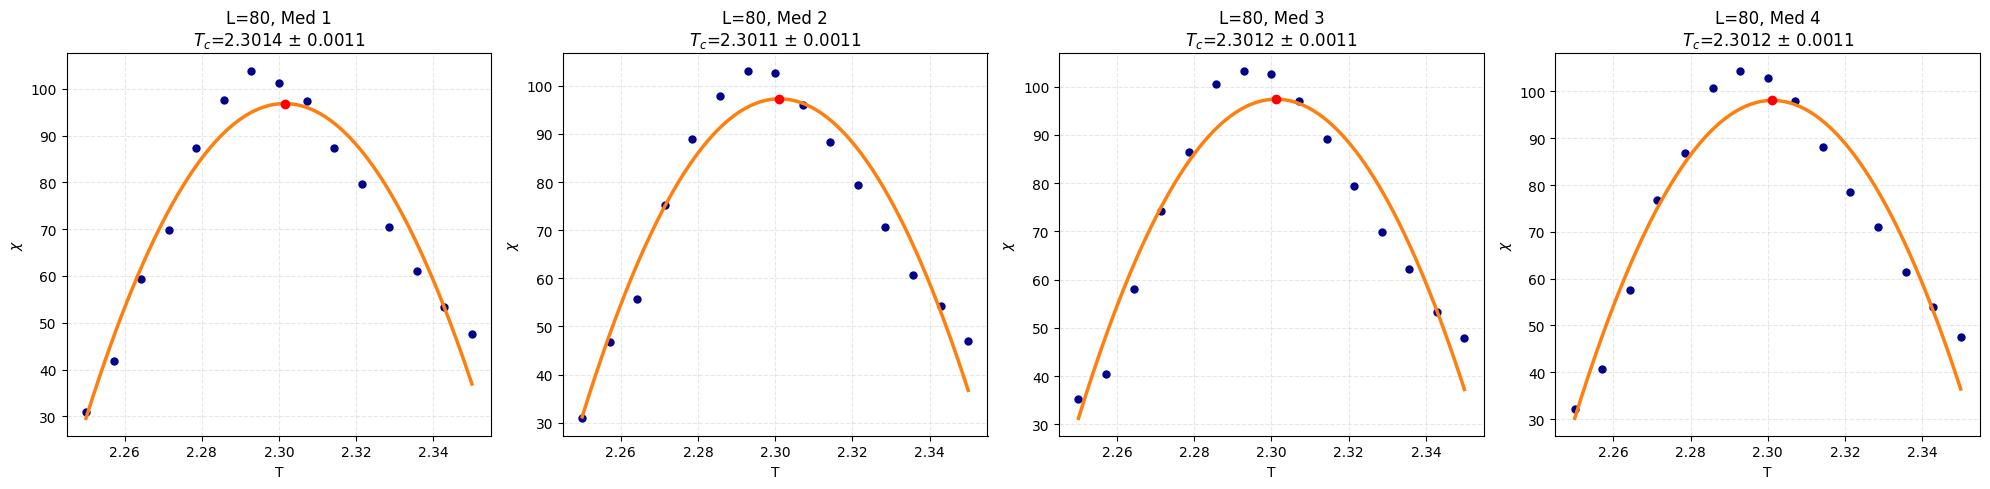

Resultados L=80:
  M1: Tc = 2.3014 +/- 0.0011
  M2: Tc = 2.3011 +/- 0.0011
  M3: Tc = 2.3012 +/- 0.0011
  M4: Tc = 2.3012 +/- 0.0011
----------------------------------------


In [ ]:
# Ajustes de las transiciones de fase (Rangos personalizados para cada L) nuevas simulaciones

# Ajuste cuadratico
# 1. Definición de la función
def cuadratica2(x, a, b, c):
    return a*(x-b)**2 + c

Ls = [32, 64, 72, 80]


# CONFIGURACIÓN DE RANGOS
config_rangos = {
    32: (2.22, 2.45),
    64: (2.25, 2.37),
    72: (2.25, 2.35),
    80: (2.25, 2.35)
}

def Ajuste(func, x, y, p0, sigma=None):
    return curve_fit(func, x, y, p0=p0, sigma=sigma)

for j in range(len(Ls)):
    L = Ls[j]

    T_m_list = []
    T_m_err_list = []

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs = axs.flatten()

    rango_T = config_rangos.get(L, (0, 10))
    t_min, t_max_val = rango_T

    for i in range(4):
        try:
            filename = os.path.join(DATA_DIR, f"L = {L} medicion {i+1}.csv")
            data = np.loadtxt(filename, delimiter=",", unpack=True, skiprows=1)
            temp_raw = data[0]
            chi_raw = data[1]

            # --- FILTRADO ---
            mask = (temp_raw >= t_min) & (temp_raw <= t_max_val)
            temp = temp_raw[mask]
            chi = chi_raw[mask]

            if len(temp) < 5:
                # Rellenamos con None o NaN para mantener el índice si falla
                T_m_list.append(None)
                T_m_err_list.append(None)
                continue

            # --- AJUSTE ---
            p0_guess = [A[j,i], Tm[j,i], C[j,i]]

            try:
                param, cov = Ajuste(cuadratica2, temp, chi, p0_guess, None)
                err = np.sqrt(np.diag(cov))
            except:
                T_m_list.append(None)
                T_m_err_list.append(None)
                continue

            # Curva
            t_plot = np.linspace(temp[0], temp[-1], 1000)
            ajuste_plot = cuadratica2(t_plot, *param)

            t_max_fit = param[1]
            chi_max_fit = cuadratica2(t_max_fit, *param)

            # Guardamos valores (convertidos a float de python para limpiar el print luego)
            T_m_list.append(float(t_max_fit))
            T_m_err_list.append(float(err[1]))

            # PLOT
            axs[i].set_title(f"L={L}, Med {i+1}\n$T_c$={t_max_fit:.4f} ± {err[1]:.4f}")
            axs[i].plot(temp, chi, 'o', c='darkblue', markersize=5, label='Datos')
            axs[i].plot(t_plot, ajuste_plot, '-', c='tab:orange', linewidth=2.5, label='Ajuste')
            axs[i].plot(t_max_fit, chi_max_fit, 'o', c='red', markersize=6)

            axs[i].set_xlabel('T')
            axs[i].set_ylabel(r'$\chi$')
            axs[i].grid(True, alpha=0.3, linestyle='--')

            margen = (temp[-1] - temp[0]) * 0.05
            axs[i].set_xlim(temp[0] - margen, temp[-1] + margen)

        except Exception as e:
            print(f"Error crítico en L={L} i={i}: {e}")

    plt.tight_layout()
    plt.show()


    # RESULTADOS

    print(f"Resultados L={L}:")
    for k in range(len(T_m_list)):
        val = T_m_list[k]
        err = T_m_err_list[k]

        if val is not None and err is not None:
            print(f"  M{k+1}: Tc = {val:.4f} +/- {err:.4f}")
        else:
            print(f"  M{k+1}: (Fallo en ajuste o pocos datos)")

    print("-" * 40)

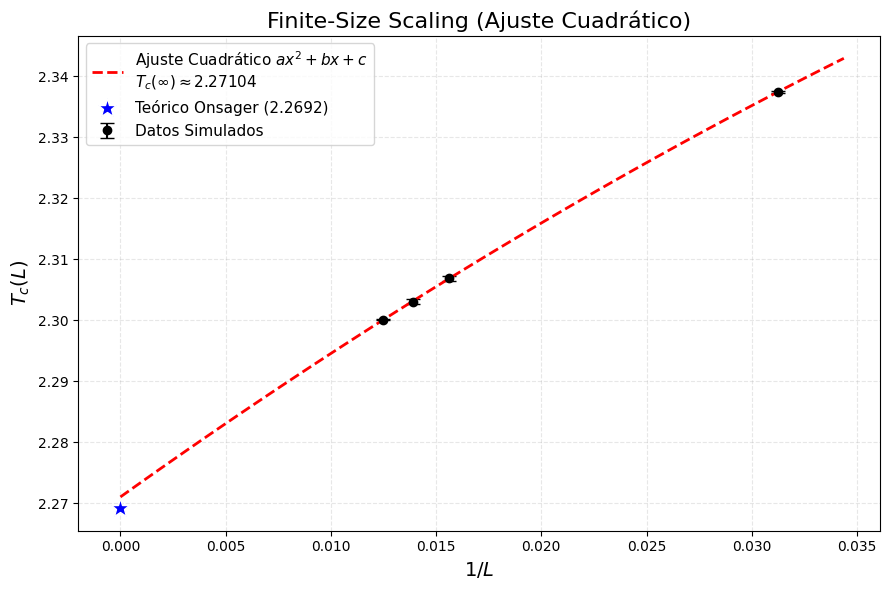

 RESULTADO FINAL (Polinomio Estándar)
--------------------------------------------------
  Parámetros:
    a (cuadrático): -10.6717 ± 7.8068
    b (lineal):     2.4584 ± 0.3417
    c (offset):     2.2710 ± 0.0031
--------------------------------------------------
  Tc Extrapolada (x=0): 2.27104
  Tc Teórica:           2.26919
  Desviación:           0.00185


In [ ]:
# Finite-size scaling (usando polinomio más estable)

Ls = np.array([32, 64, 72, 80])
Tcs = np.array([2.33744, 2.30688, 2.30304, 2.30010])
errores = np.array([0.00020, 0.00041, 0.00043, 0.00008])

# 1. Variable X (1/L)
inv_L = 1.0 / Ls

# Usamos polinomio estándar ax^2 + bx + c
# Esto es más estable numéricamente que a*(x-b)^2 + c
def ajuste_cuadratico(x, a, b, c):
    return a * x**2 + b * x + c

# 2. Estimación inicial (p0)
# a: curvatura (pequeña positiva)
# b: pendiente lineal (positiva, pues a mayor 1/L, mayor Tc)
# c: intercepto (Tc teórico aprox ~ 2.269)
p0_guess = [1.0, 2.0, 2.27]

try:
    popt, pcov = curve_fit(ajuste_cuadratico, inv_L, Tcs, p0=p0_guess,
                           sigma=errores, absolute_sigma=True, maxfev=5000)
except Exception as e:
    print(f"Error en el ajuste: {e}")
    popt = [0,0,0]
    pcov = np.zeros((3,3))

a_opt, b_opt, c_opt = popt
errores_param = np.sqrt(np.diag(pcov))

# El Tc infinito es simplemente el término independiente 'c' (donde x=0)
Tc_infinito_calc = c_opt

val_teorico = 2.0 / np.log(1.0 + np.sqrt(2.0))

# PLOT
plt.figure(figsize=(9, 6))

plt.errorbar(inv_L, Tcs, yerr=errores, fmt='o', color='black',
             ecolor='black', capsize=5, markersize=6, label='Datos Simulados')

x_plot = np.linspace(0, max(inv_L)*1.1, 100)
y_plot = ajuste_cuadratico(x_plot, *popt)

plt.plot(x_plot, y_plot, 'r--', linewidth=2,
         label=fr'Ajuste Cuadrático $ax^2 + bx + c$' + '\n' +
               fr'$T_c(\infty) \approx {Tc_infinito_calc:.5f}$')

plt.plot(0, val_teorico, 'b*', markersize=14, markeredgecolor='white',
         label=f'Teórico Onsager ({val_teorico:.4f})')

plt.xlabel(r'$1/L$', fontsize=14)
plt.ylabel(r'$T_c(L)$', fontsize=14)
plt.title('Finite-Size Scaling (Ajuste Cuadrático)', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xlim(left=-0.002)

plt.tight_layout()
plt.show()

desviacion = abs(Tc_infinito_calc - val_teorico)

print("="*50)
print(f" RESULTADO FINAL (Polinomio Estándar)")
print("-" * 50)
print(f"  Parámetros:")
print(f"    a (cuadrático): {a_opt:.4f} ± {errores_param[0]:.4f}")
print(f"    b (lineal):     {b_opt:.4f} ± {errores_param[1]:.4f}")
print(f"    c (offset):     {c_opt:.4f} ± {errores_param[2]:.4f}")
print("-" * 50)
print(f"  Tc Extrapolada (x=0): {Tc_infinito_calc:.5f}")
print(f"  Tc Teórica:           {val_teorico:.5f}")
print(f"  Desviación:           {desviacion:.5f}")
print("="*50)

El análisis de Finite-Size Scaling permitió estimar una temperatura crítica infinita de $T_c(\infty) = 2.2710 \pm 0.0031$. Este valor presenta una desviación de tan solo $0.08\%$ respecto al valor teórico de Onsager ($2.2692$), encontrándose este último dentro del margen de error experimental. Esto confirma la validez de la simulación y el correcto comportamiento de escala del sistema cerca de la transición de fase.

# Redes hexagonales

En estos casos estudiaremos las redes hexagonales.
Matematicamente la geometría de la red no es lo que importa sino respetar la topología, es decir, respetar los numeros de vecinos que tiene cada nodo $(i,j)$. Esto es conveniente pues numpy solo nos deja hacer matrices cuadradas, donde cada "nodo" tiene exactamente 4 vecinos, arriba, abajo, izquierda, derecha; por lo que para simular la red hexagonal debemos "apagar" uno de los vecinos y reorganizar al resto.

Una manera de visualizar como hacerlo es tomando una red hexagonal con lineas horizontales y diagonales, estirarlo verticalmente y notar como las lineas diagonales pasan a ser verticales, mientras las horizontales quedan igual pero alternadas (tal cual una pared de ladrillos).

En esta nueva geometría de ladrillo (brick wall) todos los sitios $(i, j)$ tienen vecinos arriba y abajo $(i \pm 1, j)$. Mientras que la interacción horizontal se alterna, es decir, solo existe enlace lateral si la paridad de la posición $(i+j)$ cumple una condición específica. Tomaremos que la condición sea $i + j = par$. el

Dada una red de espines $S_{i,j}$ en una grilla rectangular de tamaño $L \times L$, el Hamiltoniano que describe la topología hexagonal será:

$H = -J \sum_{i,j} \left[ \underbrace{S_{i,j} S_{i+1,j}}_{\text{Vertical}} + \underbrace{\eta_{i,j} \cdot S_{i,j} S_{i, j+1}}_{\text{Horizontal Alternado}} \right]$

Donde:

*   $J$ es la constante de interacción (asumimos $J=1$).
*   $S_{i+1,j}$ representa la interacción con el vecino de abajo. (El término vertical cubre 2 de los 3 vecinos de cada espín).


*   $\eta_{i,j}$ es un factor de selección (0 o 1) que "apaga" o "enciende" el enlace horizontal para recuperar la conectividad $z=3$.


$\eta_{i,j}$ es el factor que al imponer la condición de paridad, funciona de la siguiente manera.

$\eta_{i,j} =
\begin{cases}
1 & \text{si } (i+j) \text{ es par} \\
0 & \text{si } (i+j) \text{ es impar}
\end{cases}$

Esto significa que solo sumamos la interacción horizontal $S_{i,j} S_{i, j+1}$ en los sitios "pares"

## Defino las funciones

In [ ]:
@njit
def h_hex(S):
    '''
    Calcula la energía de la red Hexagonal (Brick Wall).
    Cada espín tiene 3 vecinos (2 verticales, 1 horizontal).
    '''
    L = S.shape[0]
    E = 0.0
    for i in range(L):
        for j in range(L):
            S_ij = S[i, j]

            # 1. Vecino Abajo (Siempre existe)
            # Sumamos siempre hacia abajo para cubrir todas las conexiones verticales
            vecino_down = S[(i + 1) % L, j]
            E += -S_ij * vecino_down

            # 2. Vecino Derecha (Alternado)
            # En la red hexagonal, los enlaces horizontales no son continuos.
            # # El vecino lateral depende de si la fila es par o impar
            # que tienen un enlace horizontal entre sí.
            if (i + j) % 2 == 0:
                vecino_right = S[i, (j + 1) % L]
                E += -S_ij * vecino_right

    return E

@njit
def metropolis_hex_chi(S, prob):
    """
    Realiza un barrido completo (L*L intentos) para la red HEXAGONAL.
    Solo devuelve el cambio de Magnetización (dM). Ignora la Energía global.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    total_dM = 0
    # No inicializamos total_dE porque no la vamos a usar

    for _ in range(L2):
        i, j = divmod(np.random.randint(0, L2), L)

        # 1. Identificar vecinos
        up   = S[(i - 1) % L, j]
        down = S[(i + 1) % L, j]

        if (i + j) % 2 == 0:
            side = S[i, (j + 1) % L] # Derecha
        else:
            side = S[i, (j - 1) % L] # Izquierda

        vecinos = up + down + side

        # 2. Calcular dE solo para la decisión
        dE = 2 * S[i, j] * vecinos

        # 3. Regla de Metrópolis (dE = 2 o 6)
        accept = False
        if dE <= 0:
            accept = True
        elif dE == 2:
            if np.random.random() < prob[0]: accept = True
        elif dE == 6:
            if np.random.random() < prob[1]: accept = True

        # 4. Si se acepta, solo actualizamos Magnetización
        if accept:
            # El cambio de magnetización es -2 * spin_viejo
            dm_flip = -2 * S[i, j]

            S[i, j] = -S[i, j]
            total_dM += dm_flip
            # No sumamos total_dE

    return S, total_dM

@njit
def metropolisN_hex_chi(S, prob, npasos):
    """
    Simulación Hexagonal solo para Magnetización/Susceptibilidad.
    No calcula energía.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    # Solo guardamos magnetización para optimizar
    m = np.zeros(npasos)

    # Magnetización inicial
    current_M = np.sum(S)
    m[0] = current_M


    for n in range(1, npasos):
        dM_total_step = 0

        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)

            # vecinos hex
            up   = S[(i - 1) % L, j]
            down = S[(i + 1) % L, j]

            if (i + j) % 2 == 0:
                side = S[i, (j + 1) % L] # Derecha
            else:
                side = S[i, (j - 1) % L] # Izquierda

            vecinos = up + down + side

            de = 2 * S[i, j] * vecinos
            accept = False
            if de <= 0:
                accept = True
            elif de == 2:
                if np.random.random() < prob[0]: accept = True
            elif de == 6:
                if np.random.random() < prob[1]: accept = True

            if accept:
                S[i, j] = -S[i, j]

                dM_total_step += 2 * S[i, j]

        current_M += dM_total_step
        m[n] = current_M

    # Normalización
    m = m / L2

    # devuelve S, magnetización media y varianza
    return S, np.mean(np.abs(m)), np.var(np.abs(m))



@njit
def metropolis_hex_cv(S, prob):
    """
    Un paso de Monte Carlo (L*L intentos) para Hexagonal.
    Solo devuelve el cambio de Energía (dE). Ignora Magnetización.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    total_dE = 0

    for _ in range(L2):
        i, j = divmod(np.random.randint(0, L2), L)

        # 1. Vecinos Hexagonales
        up   = S[(i - 1) % L, j]
        down = S[(i + 1) % L, j]

        if (i + j) % 2 == 0:
            side = S[i, (j + 1) % L] # Derecha
        else:
            side = S[i, (j - 1) % L] # Izquierda

        vecinos = up + down + side

        # 2. Calcular dE
        dE = 2 * S[i, j] * vecinos

        # 3. Regla de aceptación
        accept = False
        if dE <= 0:
            accept = True
        elif dE == 2:
            if np.random.random() < prob[0]: accept = True
        elif dE == 6:
            if np.random.random() < prob[1]: accept = True

        # 4. Actualizar
        if accept:
            S[i, j] = -S[i, j]
            total_dE += dE # Acumulamos el cambio de energía

    return S, total_dE

@njit
def metropolisN_hex_cv(S, prob, npasos):
    """
    Simulación Hexagonal optimizada SOLO para Energía/Calor Específico.
    No calcula magnetización.
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    # Solo guardamos energía
    e = np.zeros(npasos)

    # Energía inicial (Requiere que h_hex esté definida en tu entorno)
    current_E = h_hex(S)
    e[0] = current_E

    for n in range(1, npasos):
        dE_total_step = 0

        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)

            # Vecinos
            up   = S[(i - 1) % L, j]
            down = S[(i + 1) % L, j]
            if (i + j) % 2 == 0:
                side = S[i, (j + 1) % L]
            else:
                side = S[i, (j - 1) % L]

            vecinos = up + down + side

            # Diferencial de Energía
            de = 2 * S[i, j] * vecinos

            # Aceptación
            accept = False
            if de <= 0:
                accept = True
            elif de == 2:
                if np.random.random() < prob[0]: accept = True
            elif de == 6:
                if np.random.random() < prob[1]: accept = True

            if accept:
                S[i, j] = -S[i, j]
                dE_total_step += de # Sumamos el cambio de energía

        current_E += dE_total_step
        e[n] = current_E

    # Normalización por espín
    e = e / L2

    # Retornamos: S, Energía Media, Varianza de Energía (para Cv)
    return S, np.mean(e), np.var(e)

def parabola_pico(x, a, b, c):
    return a * (x - b)**2 + c

## Test de funciones

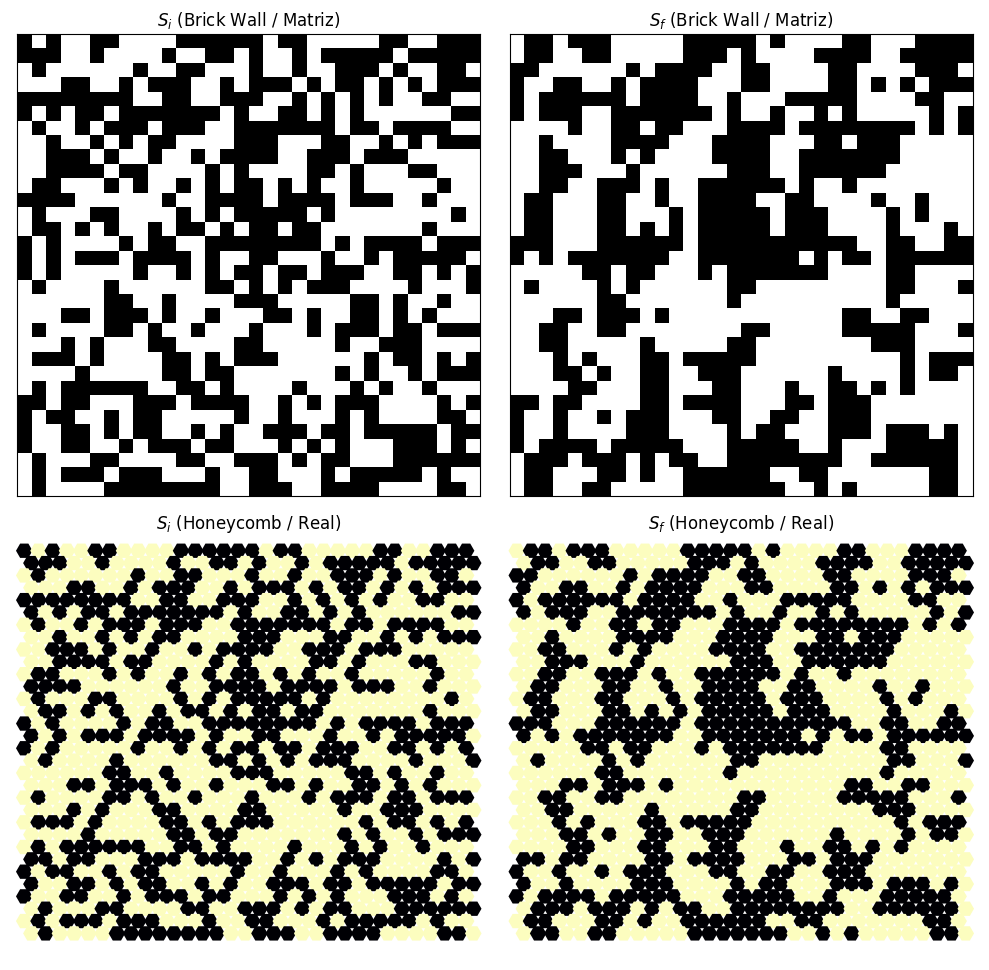

---
ESTADO INICIAL
Energía total: -52.00
Magnetización total: 32.00
---
ESTADO FINAL
Energía total: -652.00
Magnetización total: 68.00
---
CAMBIOS
dM del paso: 36


In [ ]:
# Test metropolis_hex_chi Hexagonal

L = 32
L2 = L * L

# Temperatura baja para ver ordenamiento local
beta = 1/1.0

# 1. Probabilidades para Hexagonal (dE = 2 y 6)
prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

# Estado Inicial
Si = 2 * np.random.randint(2, size = (L, L)) - 1

# 2. Evolución (1 paso)
Sf, dm = metropolis_hex_chi(Si, prob)

# --- GRÁFICOS (2x2) ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10)) # Figura más grande

# Fila 1: Representación "Brick Wall" (Matricial)
graficar_red(Si, ax=axs[0, 0])
axs[0, 0].set_title("$S_i$ (Brick Wall / Matriz)")
graficar_red(Sf, ax=axs[0, 1])
axs[0, 1].set_title("$S_f$ (Brick Wall / Matriz)")

# Fila 2: Representación "Honeycomb" (Real)
graficar_hexagonal(Si, ax=axs[1, 0], title="$S_i$ (Honeycomb / Real)")
graficar_hexagonal(Sf, ax=axs[1, 1], title="$S_f$ (Honeycomb / Real)")

plt.tight_layout()
plt.show()

# --- DATOS NUMÉRICOS ---
print('---\nESTADO INICIAL')
print(f'Energía total: {h_hex(Si):.2f}')
print(f'Magnetización total: {np.sum(Si):.2f}')

print('---\nESTADO FINAL')
print(f'Energía total: {h_hex(Sf):.2f}')
print(f'Magnetización total: {np.sum(Sf):.2f}')

print('---\nCAMBIOS')
print(f'dM del paso: {dm}')

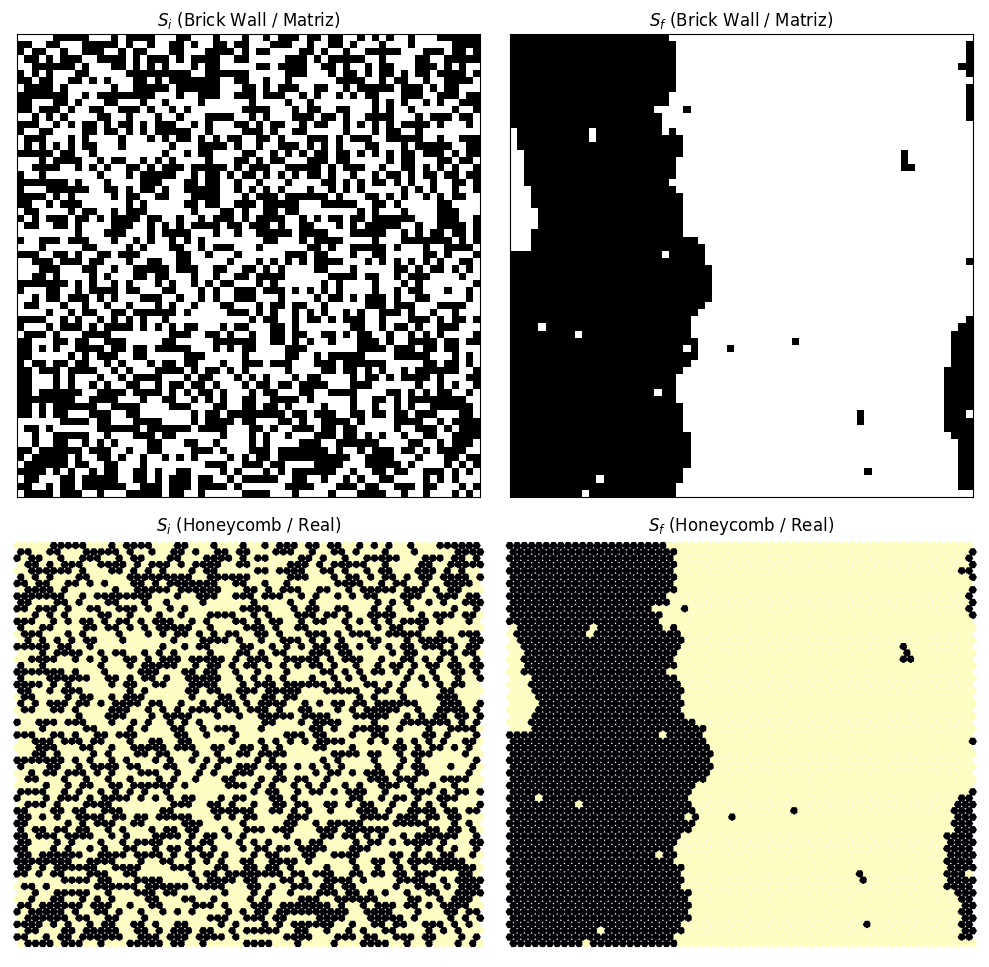

---
ESTADO INICIAL
Energía por partícula: -0.00
Magnetización instantánea: -0.00
---
ESTADO FINAL
Energía por partícula: -1.43
Magnetización instantánea: 0.22
---
ESTADÍSTICA DE LA SIMULACIÓN
Magnetización Media (<|m|>) : 0.1823
Varianza de Magnetización   : 0.00328
Susceptibilidad estimada (χ): 13.45


In [ ]:
#  Test metropolisN_hex_chi

L = 64
L2 = L * L

# Temperatura de prueba (Tc hexagonal ~ 1.52)
# Usamos T=1.0 para asegurar fase ordenada
beta = 1/1.0

# 1. Probabilidades Hexagonales (dE = 2 y 6)
prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

npasos = 2000

Si = 2 * np.random.randint(2, size = (L, L)) - 1

# 2.Llamamos a la función que ahora devuelve 3 cosas
# Sf = Estado Final
# m_mean = Magnetización Promedio durante la simulación
# varm = Varianza (para la susceptibilidad)
Sf, m_mean, varm = metropolisN_hex_chi(Si, prob, npasos)

# --- GRÁFICOS (2x2) ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Fila 1: Representación "Brick Wall" (Matricial)
graficar_red(Si, ax=axs[0, 0])
axs[0, 0].set_title("$S_i$ (Brick Wall / Matriz)")
graficar_red(Sf, ax=axs[0, 1])
axs[0, 1].set_title("$S_f$ (Brick Wall / Matriz)")

# Fila 2: Representación "Honeycomb" (Real)
graficar_hexagonal(Si, ax=axs[1, 0], title="$S_i$ (Honeycomb / Real)")
graficar_hexagonal(Sf, ax=axs[1, 1], title="$S_f$ (Honeycomb / Real)")

plt.tight_layout()
plt.show()

# --- ESTADÍSTICAS ---
# Nota: Usamos h_hex para calcular energía puntual (aunque la simulación no la guardó)
print('---\nESTADO INICIAL')
print(f'Energía por partícula: {h_hex(Si)/L2:.2f}')
print(f'Magnetización instantánea: {np.sum(Si)/L2:.2f}')

print('---\nESTADO FINAL')
print(f'Energía por partícula: {h_hex(Sf)/L2:.2f}')
print(f'Magnetización instantánea: {np.sum(Sf)/L2:.2f}')

print('---\nESTADÍSTICA DE LA SIMULACIÓN')
print(f'Magnetización Media (<|m|>) : {m_mean:.4f}')
print(f'Varianza de Magnetización   : {varm:.5f}')

chi = beta * L2 * varm

# Usamos fr'...' para que \chi no de error
print(f'Susceptibilidad estimada (χ): {chi:.2f}')

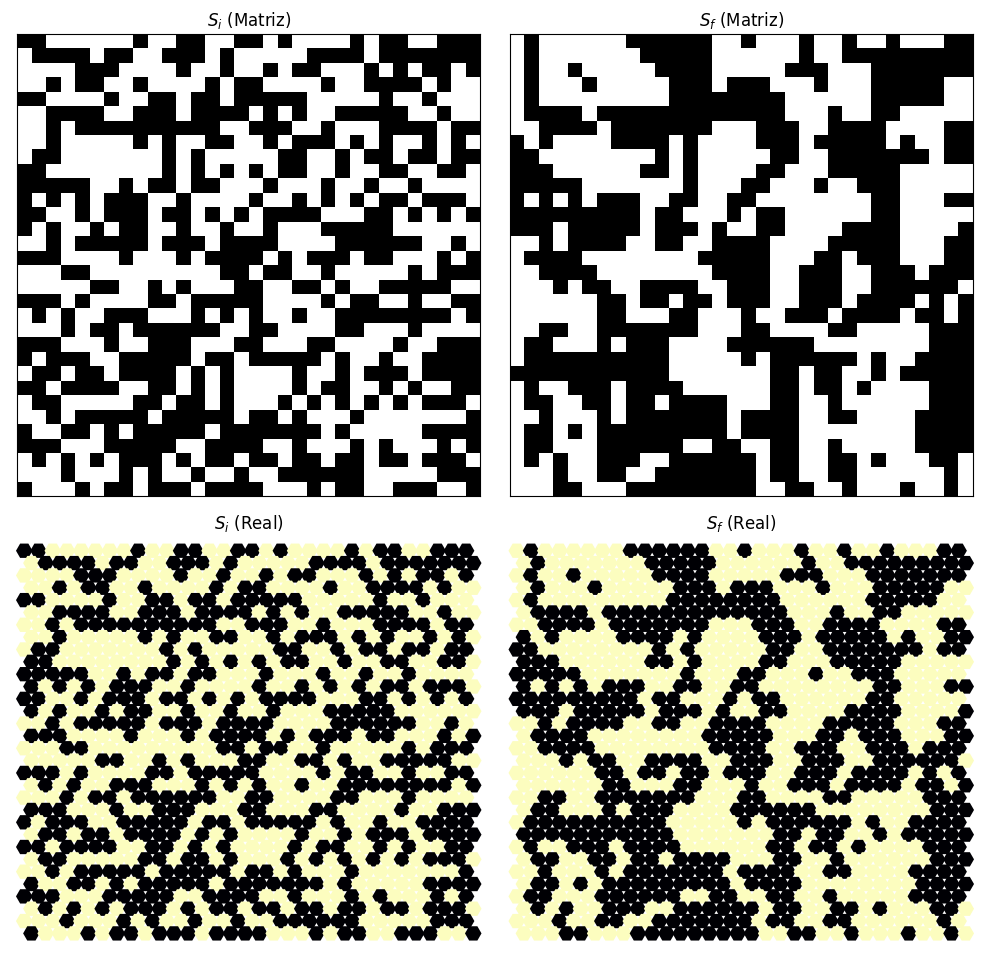

---
ESTADOS
Energía Inicial (Ei): 34.00
Energía Final   (Ef): -708.00

--- VERIFICACIÓN DE LA OPTIMIZACIÓN ---
dE retornado por metropolis_hex_cv: -742.00
Diferencia real (Ef - Ei)         : -742.00
 ¡ÉXITO! El cálculo diferencial de energía coincide con el real.


In [ ]:
# Test metropolis_hex_cv (Energía / Calor Específico)

L = 32
L2 = L * L

# Temperatura baja para ver ordenamiento
beta = 1/1.0

# 1. Probabilidades Hexagonales
prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

# Estado Inicial
Si = 2 * np.random.randint(2, size = (L, L)) - 1

# 2. Evolución (1 paso) usando la función de Energía
# Esta función devuelve el estado nuevo y el dE acumulado
Sf, de = metropolis_hex_cv(Si, prob)

# --- GRÁFICOS (2x2) ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Fila 1: Brick Wall
graficar_red(Si, ax=axs[0, 0])
axs[0, 0].set_title("$S_i$ (Matriz)")
graficar_red(Sf, ax=axs[0, 1])
axs[0, 1].set_title("$S_f$ (Matriz)")

# Fila 2: Hexagonal Real
graficar_hexagonal(Si, ax=axs[1, 0], title="$S_i$ (Real)")
graficar_hexagonal(Sf, ax=axs[1, 1], title="$S_f$ (Real)")

plt.tight_layout()
plt.show()

# --- VALIDACIÓN NUMÉRICA ---
# Calculamos la energía real antes y después usando la función h_hex
Ei = h_hex(Si)
Ef = h_hex(Sf)
diff_real = Ef - Ei

print('---\nESTADOS')
print(f'Energía Inicial (Ei): {Ei:.2f}')
print(f'Energía Final   (Ef): {Ef:.2f}')

print('\n--- VERIFICACIÓN DE LA OPTIMIZACIÓN ---')
print(f'dE retornado por metropolis_hex_cv: {de:.2f}')
print(f'Diferencia real (Ef - Ei)         : {diff_real:.2f}')

if abs(de - diff_real) < 1e-5:
    print(" El cálculo diferencial de energía coincide con el real.")
else:
    print(" Hay una discrepancia en el cálculo de energía.")

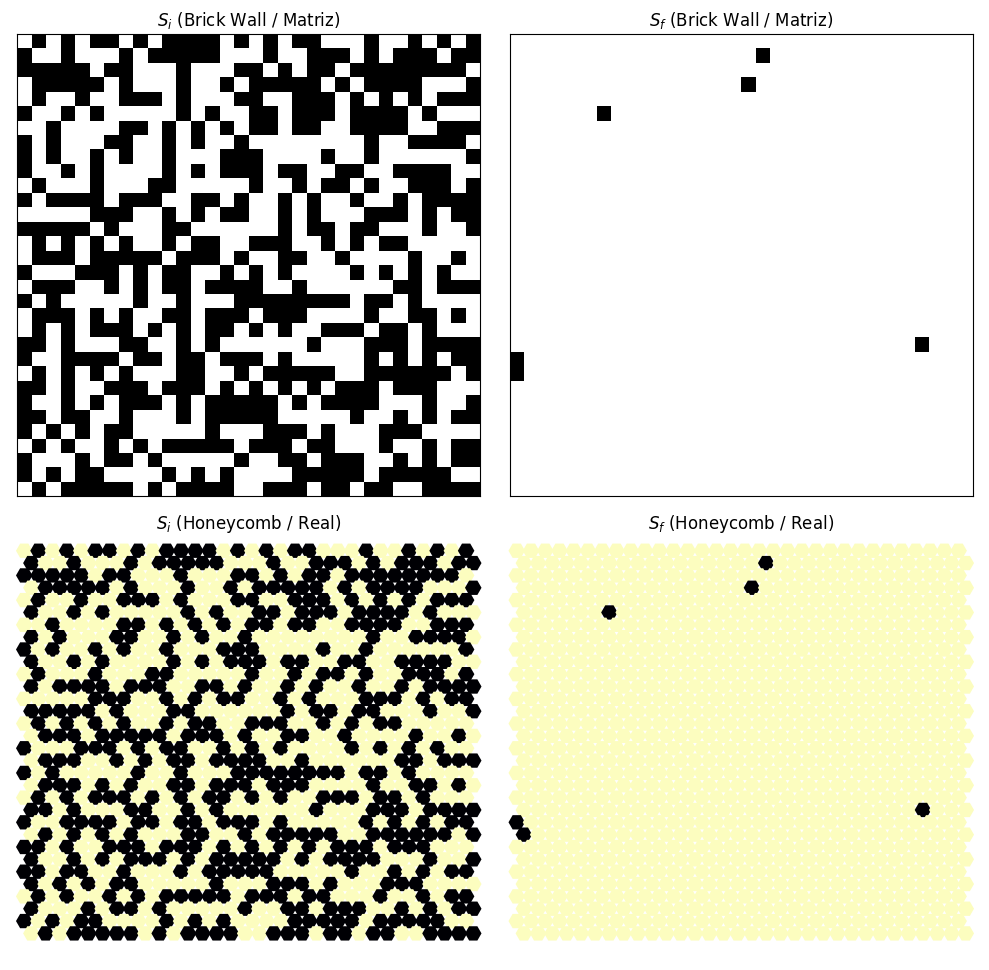

---
ESTADO INICIAL
Energía por partícula: 0.08
Magnetización por partícula: -0.03
---
ESTADO FINAL
Energía por partícula: -1.47
Magnetización por partícula: 0.99
---
ESTADÍSTICA DE LA SIMULACIÓN (Energía)
Energía Media (<e>)       : -1.4621
Varianza de Energía       : 0.00488
Calor Específico est. (Cv): 4.99


In [ ]:
#  Test metropolisN_hex_cv

L = 32  # L=32 para visualización rápida
L2 = L * L

# Temperatura baja (T=1.0) para ver ordenamiento
beta = 1/1.0

# Probabilidades Hexagonales (dE = 2 y 6)
prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

npasos = 2000

Si = 2 * np.random.randint(2, size = (L, L)) - 1

# 2. Llamamos a la función para Cv
Sf, e_mean, vare = metropolisN_hex_cv(Si, prob, npasos)

# --- GRÁFICOS (2x2) ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Fila 1: Representación "Brick Wall" (Matricial)
graficar_red(Si, ax=axs[0, 0])
axs[0, 0].set_title("$S_i$ (Brick Wall / Matriz)")
graficar_red(Sf, ax=axs[0, 1])
axs[0, 1].set_title("$S_f$ (Brick Wall / Matriz)")

# Fila 2: Representación "Honeycomb" (Real)
graficar_hexagonal(Si, ax=axs[1, 0], title="$S_i$ (Honeycomb / Real)")
graficar_hexagonal(Sf, ax=axs[1, 1], title="$S_f$ (Honeycomb / Real)")

plt.tight_layout()
plt.show()

# --- ESTADÍSTICAS ---
print('---\nESTADO INICIAL')
print(f'Energía por partícula: {h_hex(Si)/L2:.2f}')
print(f'Magnetización por partícula: {np.sum(Si)/L2:.2f}')

print('---\nESTADO FINAL')
print(f'Energía por partícula: {h_hex(Sf)/L2:.2f}')
print(f'Magnetización por partícula: {np.sum(Sf)/L2:.2f}')

print('---\nESTADÍSTICA DE LA SIMULACIÓN (Energía)')
print(f'Energía Media (<e>)       : {e_mean:.4f}')
print(f'Varianza de Energía       : {vare:.5f}')

# Cálculo de Calor Específico
# Cv = beta^2 * N * Var(e)
cv = (beta**2) * L2 * vare
print(f'Calor Específico est. (Cv): {cv:.2f}')

## Termalización

Función termalización y test

In [ ]:
@njit
def metropolisTermo_hex(S, prob, nequilibrio):
    """
    Aplica Metrópolis para termalizar la red hex.
    (3 vecinos, dE=2,6).
    """
    S = S.copy()
    L  = S.shape[0]
    L2 = L * L

    for n in range(nequilibrio):
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)

            # vecinos hex
            up   = S[(i - 1) % L, j]
            down = S[(i + 1) % L, j]

            if (i + j) % 2 == 0:
                side = S[i, (j + 1) % L] # derecha
            else:
                side = S[i, (j - 1) % L] # izquierda

            vecinos = up + down + side

            # diferencia de energía
            de = 2 * S[i, j] * vecinos

            accept = False
            if de <= 0:
                accept = True
            elif de == 2:
                if np.random.random() < prob[0]: accept = True
            elif de == 6:
                if np.random.random() < prob[1]: accept = True

            if accept:
                S[i,j] = -S[i,j]

    return S

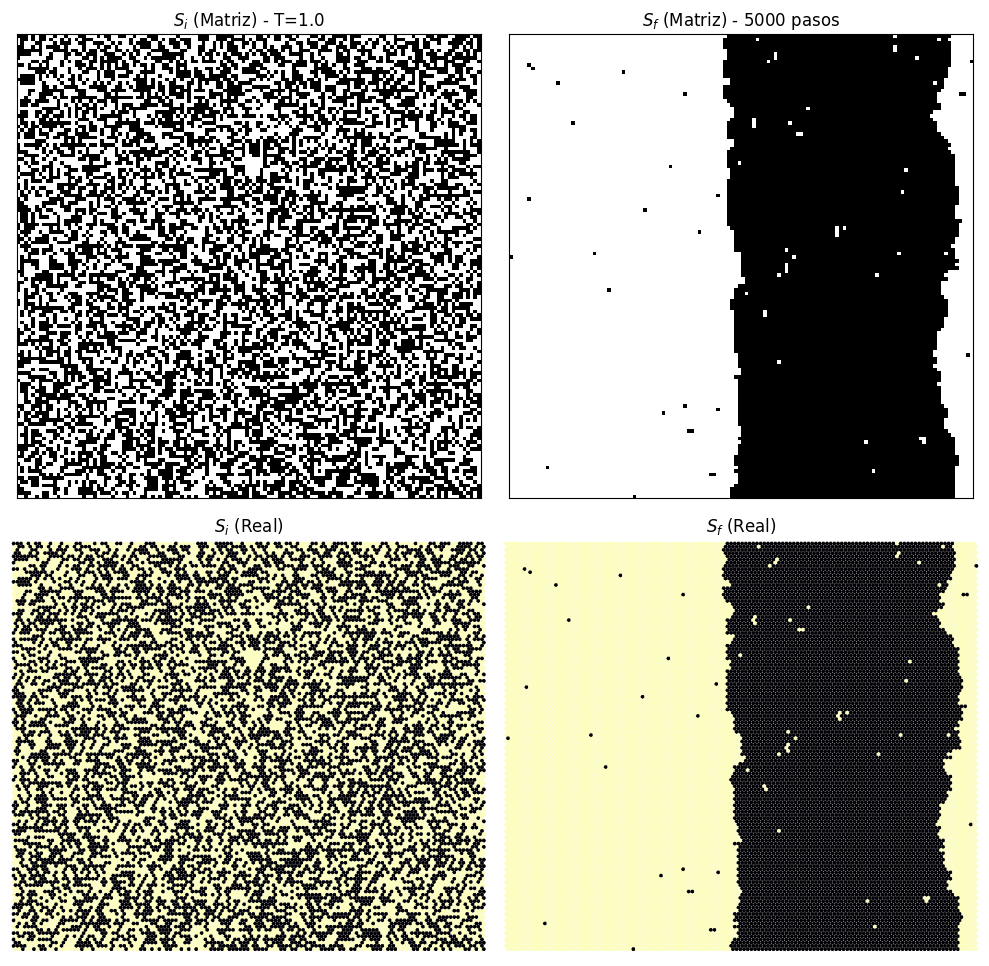

In [ ]:
# Test metropolisTermo Hexagonal:

L = 128
L2 = L * L
nequilibrio = 5000 #

# Tc_hex ~ 1.52. Usamos T=1.0 para fase ordenada
beta = 1/1.0

# Probabilidades Hexagonales (dE = 2 y 6)
prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

# Estado inicial aleatorio
Si = 2 * np.random.randint(2, size = (L, L)) - 1

# Termalización
Sf = metropolisTermo_hex(Si, prob, nequilibrio)

# --- GRÁFICOS  ---
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Fila 1: Representación "Brick Wall" (Matricial)
graficar_red(Si, ax=axs[0, 0])
axs[0, 0].set_title(f"$S_i$ (Matriz) - T={1/beta}")
graficar_red(Sf, ax=axs[0, 1])
axs[0, 1].set_title(f"$S_f$ (Matriz) - {nequilibrio} pasos")

# Fila 2: Representación "Hex" (Real)
graficar_hexagonal(Si, ax=axs[1, 0], title="$S_i$ (Real)")
graficar_hexagonal(Sf, ax=axs[1, 1], title="$S_f$ (Real)")

plt.tight_layout()
plt.show()

In [ ]:
# Termalización de la magnetización Hexagonal (solo susceptibilidad)
# Para generar nuevas simulaciones decomentar esta celda

"""


L_lista = [32, 64, 128]
nequilibrio = 20000

# Rango de temperaturas (Tc hexagonal ~ 1.52)
temperaturas = [1.0, 1.2, 1.4, 1.5, 1.55, 1.6, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0, 3.5, 4.0]

colores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))

# diccionario para resultados
ms = {L: {} for L in L_lista}

print("Iniciando termalización de magnetización (Hexagonal)...")

for L in L_lista:
    L2 = L * L

    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):
        beta = 1/T

        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])

        S = 2 * np.random.randint(2, size = (L, L)) - 1

        m_evo = np.zeros(nequilibrio)
        current_M = np.sum(S)
        m_evo[0] = current_M

        for n in range(1, nequilibrio):
            # Recordemos que esta función NO devuelve dE, solo S y dm
            S, dm = metropolis_hex_chi(S, prob)

            current_M += dm
            m_evo[n] = current_M

        # Guardamos normalizado por espín al final de todo
        ms[L][T] = m_evo / L2

clear_output()

# Gráficos
for L in L_lista:
    plt.figure(figsize=(12, 6))
    plt.title(f'Termalización de Magnetización Hexagonal para L = {L}')

    for i, T in enumerate(temperaturas):
        # Graficamos valor absoluto para evitar errores
        plt.plot(np.abs(ms[L][T]), label=f'{T:.1f}', c=colores[i], zorder=-i, lw=0.8)

    plt.xlabel('Pasos Monte Carlo')
    plt.ylabel('|Magnetización| por espín')
    # Marcamos Tc teórica hexagonal para referencia
    plt.axhline(y=0, color='k', lw=0.5)

    plt.legend(title="$T$", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()


    """

'\n\n\nL_lista = [32, 64, 128]\nnequilibrio = 20000\n\n# Rango de temperaturas (Tc hexagonal ~ 1.52)\ntemperaturas = [1.0, 1.2, 1.4, 1.5, 1.55, 1.6, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0, 3.5, 4.0]\n\ncolores = plt.cm.magma(np.linspace(0, 1, len(temperaturas)))\n\n# diccionario para resultados\nms = {L: {} for L in L_lista}\n\nprint("Iniciando termalización de magnetización (Hexagonal)...")\n\nfor L in L_lista:\n    L2 = L * L\n\n    for T in tqdm(temperaturas, desc=f"Simulando L={L}"):\n        beta = 1/T\n\n        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])\n\n        S = 2 * np.random.randint(2, size = (L, L)) - 1\n\n        m_evo = np.zeros(nequilibrio)\n        current_M = np.sum(S)\n        m_evo[0] = current_M\n\n        for n in range(1, nequilibrio):\n            # Recordemos que esta función NO devuelve dE, solo S y dm\n            S, dm = metropolis_hex_chi(S, prob)\n\n            current_M += dm\n            m_evo[n] = current_M\n\n        # Guardamos normalizado por es

Recuperando gráficos de Magnetización Hexagonal...


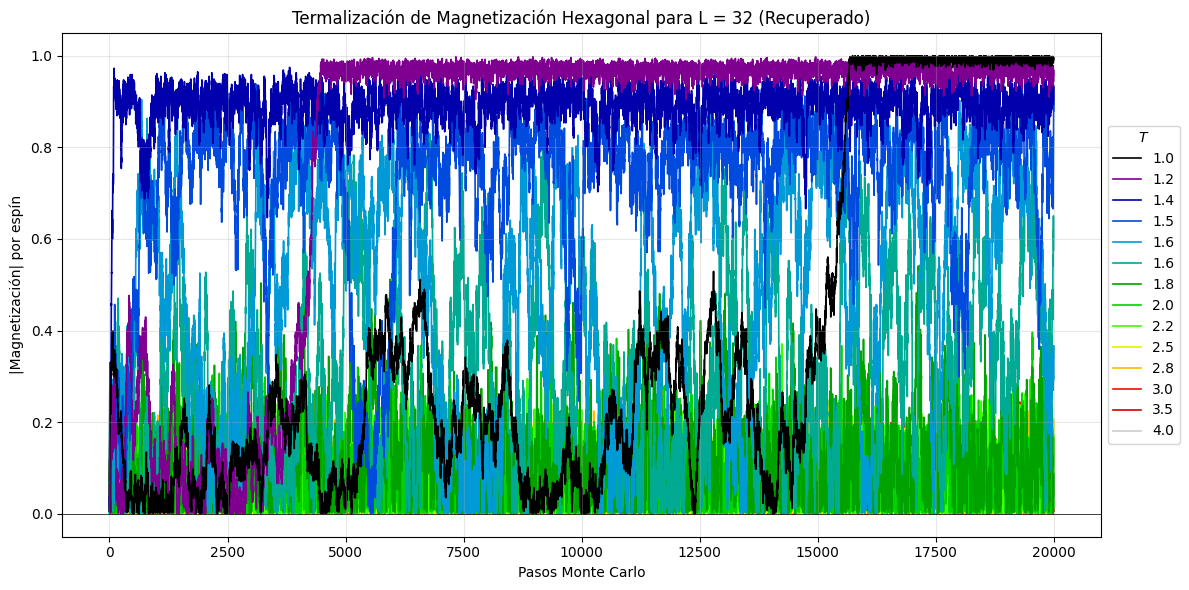

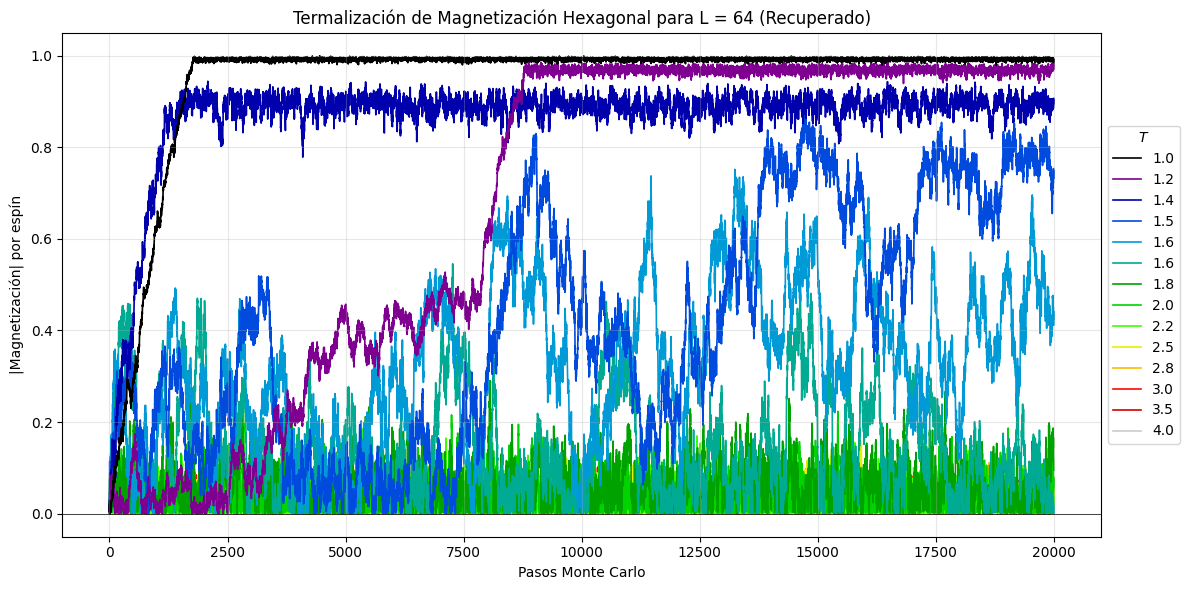

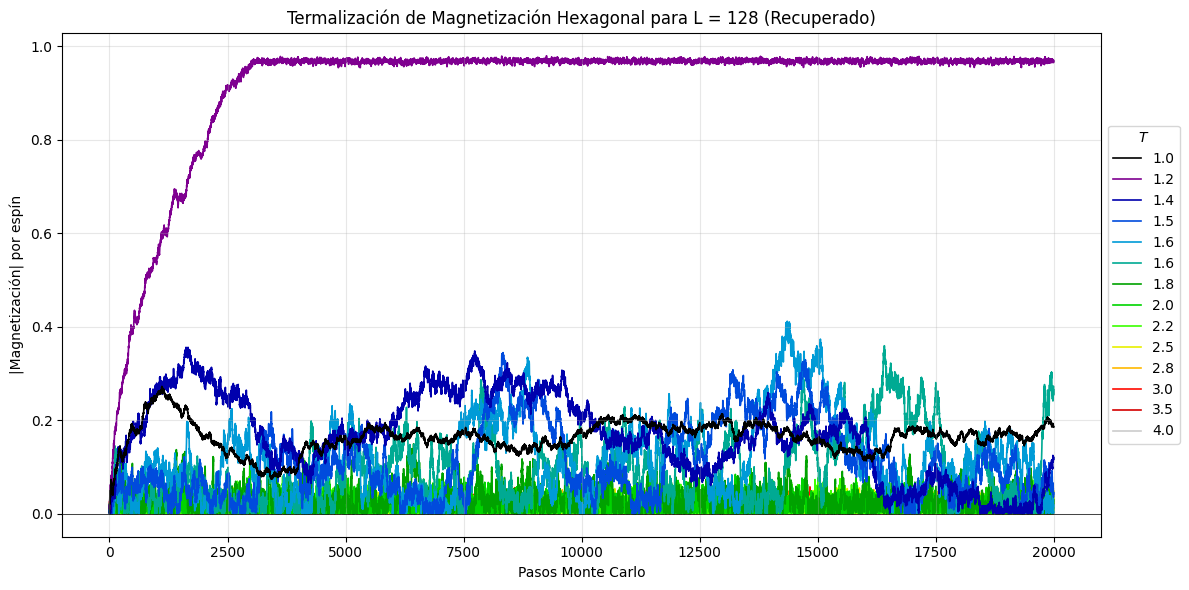

In [ ]:

# Carga y Gráficos de Magnetización Hexagonal

L_lista = [32, 64, 128]
temperaturas = [1.0, 1.2, 1.4, 1.5, 1.55, 1.6, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0, 3.5, 4.0]


colores = plt.cm.nipy_spectral(np.linspace(0, 1, len(temperaturas)))

print("Recuperando gráficos de Magnetización Hexagonal...")

for L in L_lista:
    nombre_archivo = f"termalizacion_magnetizacion_hex_L{L}.npz"
    path_completo = os.path.join(DATA_DIR, nombre_archivo)
    try:
        data = np.load(path_completo)

        plt.figure(figsize=(12, 6))
        plt.title(f'Termalización de Magnetización Hexagonal para L = {L} ')

        for i, T in enumerate(temperaturas):
            clave = f"T_{T:.2f}"

            if clave in data:
                curve = data[clave]
                # Aumenté ligeramente el lw (grosor) a 1.2 para mejor visibilidad
                plt.plot(np.abs(curve), label=f'{T:.1f}', c=colores[i], zorder=-i, lw=1.2)
            else:
                print(f"Falta dato T={T} en {path_completo}")

        plt.xlabel('Pasos Monte Carlo')
        plt.ylabel('|Magnetización| por espín')
        plt.axhline(y=0, color='k', lw=0.5)

        # Esto mueve la leyenda afuera para que no tape los datos
        plt.legend(title="$T$", loc='center left', bbox_to_anchor=(1, 0.5))
        plt.tight_layout()
        plt.grid(True, alpha=0.3)
        plt.show()

    except FileNotFoundError:
        print(f"ERROR: Falta el archivo '{path_completo}'. Subir a la carpeta.")

Tenemos 3 conclusiones respecto a los gráficos obtenidos en la termalización

1.   Podemos observar dos fases, al igual que las redes cuadradas,  ferromagnética $T < T_C$  y paramagnética $T > T_c$. En el primer caso el sistema parte de un estado desordenado hasta alcanzar una magnetización alta $M ≈ 1$, ordenando los espines y minimizando la energía del sistema. se nota claramente con $T = 1$.
En el segundo caso la agitación termina domina sobre la interacción ferromagnética y la magnetización fluctua alrededor de cero, sin estabilizarse.
2.   La influencia del tamaño de las redes: En primer lugar notamos menos fluctuaciones para los casos ferromagnéticos cuanto más crece el tamaño de la red. Es decir, hay mas estabilidad. Cerca de la temperatura crítica $T_c ≈ 1.52$ existen muchas fluctuaciones, las cuales son mas ruidosas y rapidas en el caso de L= 32, mientras que en el caso de L = 128 son más lentas.
3.  Por último notamos que la $T_c ≈ 1.52$ a diferencia de la red cuadrada.



## Transición de fase hexagonal

In [ ]:
# Simulacion de transicion de fase para redes hexagonales
# Para generar nuevas simulaciones descomentar la celda

"""

Ls = [32, 64]

# para guardar
nmedias = {}
chis = {}

# configuración Temperaturas (Tc Hexagonal ~ 1.52)
Tcentro = 1.52
X = np.linspace(-1.0, 1.0, 55) # barrido centrado
temperaturas = np.sign(X) * (X**2) + Tcentro
temperaturas = temperaturas[temperaturas > 0.6]
betas = 1 / temperaturas

# configuración de Pasos
factor = 2500
# lejos de Tc
nequilibrio_lejos = 2 * factor
npromedio_lejos   = 40 * factor
# cerca de Tc (aumentamos precisión)
nequilibrio_cerca = 5 * factor
npromedio_cerca   = 200 * factor

colores = plt.cm.magma(np.linspace(0, 0.8, len(Ls)))

print("Iniciando barrido Hexagonal...")

for L in Ls:
    L2 = L * L
    S = np.ones((L, L))

    m_res = np.zeros_like(betas)
    chi_res = np.zeros_like(betas)

    for i in tqdm(range(len(betas)), desc=f"Simulando L={L}"):
        beta = betas[i]
        T_act = temperaturas[i]


        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])


        if abs(T_act - Tcentro) < 0.25:
            neq, nprom = nequilibrio_cerca, npromedio_cerca
        else:
            neq, nprom = nequilibrio_lejos, npromedio_lejos

        # 1. Termalización
        S = metropolisTermo_hex(S, prob, neq)

        # 2. Medición
        S, m_mean, m_var_norm = metropolisN_hex_chi(S, prob, nprom)

        m_res[i] = m_mean

        chi_res[i] = beta * L2 * m_var_norm

    nmedias[L] = m_res
    chis[L]    = chi_res

# gráficos
fig = plt.figure(figsize=(12, 5))
plt.suptitle('Transición de Fase - Red Hexagonal')

# magnetización
plt.subplot(1, 2, 1)
for i, L in enumerate(Ls):
    plt.plot(temperaturas, nmedias[L], '.', c=colores[i], ms=5, label=f'L={L}')
plt.ylabel('Magnetización')
plt.xlabel('T'); plt.grid(alpha=0.3); plt.legend()

# susceptibilidad
plt.subplot(1, 2, 2)
for i, L in enumerate(Ls):
    plt.plot(temperaturas, chis[L], '.', c=colores[i], lw=0.5, ms=5)
plt.ylabel(r'Susceptibilidad ($\chi$)')
plt.xlabel('T'); plt.axvline(x=1.519, c='k', ls='--', alpha=0.3); plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()
"""

<>:77: SyntaxWarning: invalid escape sequence '\c'
<>:77: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipython-input-3796518509.py:77: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel(r'Susceptibilidad ($\chi$)')


'\n\nLs = [32, 64]\n\n# para guardar\nnmedias = {}\nchis = {}\n\n# configuración Temperaturas (Tc Hexagonal ~ 1.52)\nTcentro = 1.52\nX = np.linspace(-1.0, 1.0, 55) # barrido centrado\ntemperaturas = np.sign(X) * (X**2) + Tcentro\ntemperaturas = temperaturas[temperaturas > 0.6]\nbetas = 1 / temperaturas\n\n# configuración de Pasos\nfactor = 2500\n# lejos de Tc\nnequilibrio_lejos = 2 * factor\nnpromedio_lejos   = 40 * factor\n# cerca de Tc (aumentamos precisión)\nnequilibrio_cerca = 5 * factor\nnpromedio_cerca   = 200 * factor\n\ncolores = plt.cm.magma(np.linspace(0, 0.8, len(Ls)))\n\nprint("Iniciando barrido Hexagonal...")\n\nfor L in Ls:\n    L2 = L * L\n    S = np.ones((L, L))\n\n    m_res = np.zeros_like(betas)\n    chi_res = np.zeros_like(betas)\n\n    for i in tqdm(range(len(betas)), desc=f"Simulando L={L}"):\n        beta = betas[i]\n        T_act = temperaturas[i]\n\n\n        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])\n\n\n        if abs(T_act - Tcentro) < 0.25:\n  

Intentando cargar 'datos_ising_hex_energias.npz'...
-> Datos cargados correctamente.
-> Temperaturas: 53 puntos.
-> Longitudes encontradas: [32, 64]


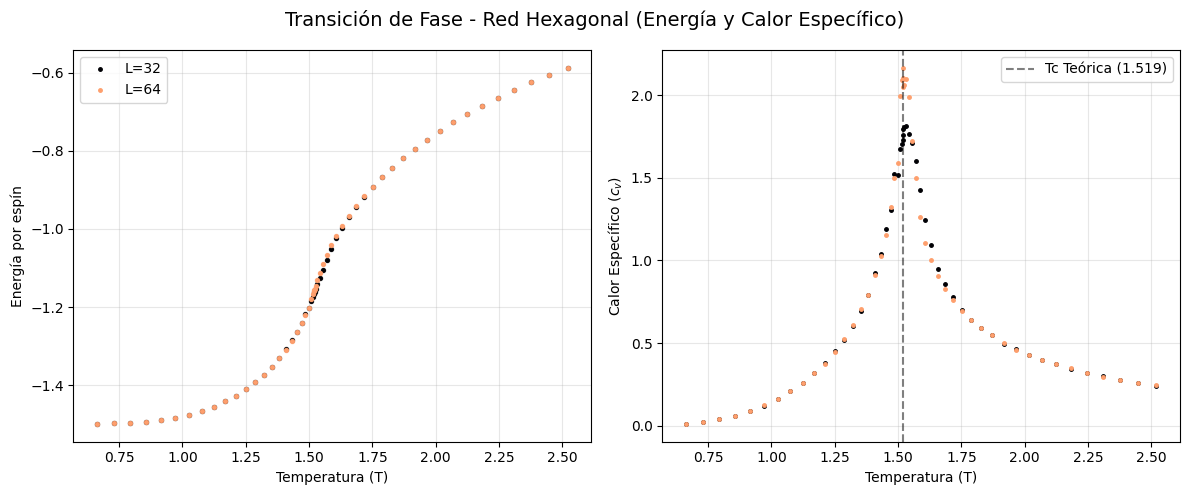

In [ ]:
# Carga y Gráficos de Energía y Cv Hexagonal

archivo_entrada = 'datos_ising_hex_energias.npz'

print(f"Cargando '{archivo_entrada}'...")

path_completo = os.path.join(DATA_DIR, archivo_entrada)

try:
    # 1. Cargar datos
    data = np.load(path_completo)

    # Recuperar eje X (Temperaturas)
    if 'temperaturas' in data.files:
        temperaturas = data['temperaturas']
    else:
        raise KeyError("No se encontró el array de temperaturas en el archivo.")

    # Detectar qué Ls hay en el archivo
    Ls_encontrados = sorted([int(k.split('e_L')[1]) for k in data.files if k.startswith('e_L')])

    print(f"-> Datos cargados correctamente.")
    print(f"-> Temperaturas: {len(temperaturas)} puntos.")
    print(f"-> Longitudes encontradas: {Ls_encontrados}")

    # 2. Configuración de Gráficos
    colores = plt.cm.magma(np.linspace(0, 0.8, len(Ls_encontrados)))
    fig = plt.figure(figsize=(12, 5))
    plt.suptitle('Transición de Fase - Red Hexagonal (Energía y Calor Específico)', fontsize=14)

    # --- Gráfico 1: Energía ---
    ax1 = plt.subplot(1, 2, 1)
    for i, L in enumerate(Ls_encontrados):
        energia = data[f'e_L{L}']
        # Puntos
        ax1.plot(temperaturas, energia, '.', c=colores[i], ms=5, label=f'L={L}')
        # Línea suave de fondo (cambié '.' por '-' para que conecte visualmente)
        ax1.plot(temperaturas, energia, '-', c=colores[i], lw=0.5, alpha=0.5)

    ax1.set_ylabel('Energía por espín')
    ax1.set_xlabel('Temperatura (T)')
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # --- Gráfico 2: Calor Específico ---
    ax2 = plt.subplot(1, 2, 2)

    for i, L in enumerate(Ls_encontrados):
        cv = data[f'cv_L{L}']
        ax2.plot(temperaturas, cv, '.', c=colores[i], lw=0.5, ms=5)
        ax2.plot(temperaturas, cv, '-', c=colores[i], lw=0.5, alpha=0.3)

    ax2.set_ylabel('Calor Específico ($c_v$)')
    ax2.set_xlabel('Temperatura (T)')

    # Marcamos la Tc teórica hexagonal para referencia
    ax2.axvline(x=1.519, c='k', ls='--', alpha=0.5, label='Tc Teórica (1.519)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"\n❌ ERROR: No se encontró el archivo '{archivo_entrada}' en la carpeta data.")
    print(f"Ruta buscada: {path_completo}")
except Exception as e:
    print(f"\n❌ Ocurrió un error al leer los datos: {e}")

Intentando cargar 'datos_ising_hexagonal_L32_L64_fase.npz'...
-> Datos cargados correctamente.
-> Temperaturas: 53 puntos.
-> Longitudes encontradas: [32, 64]


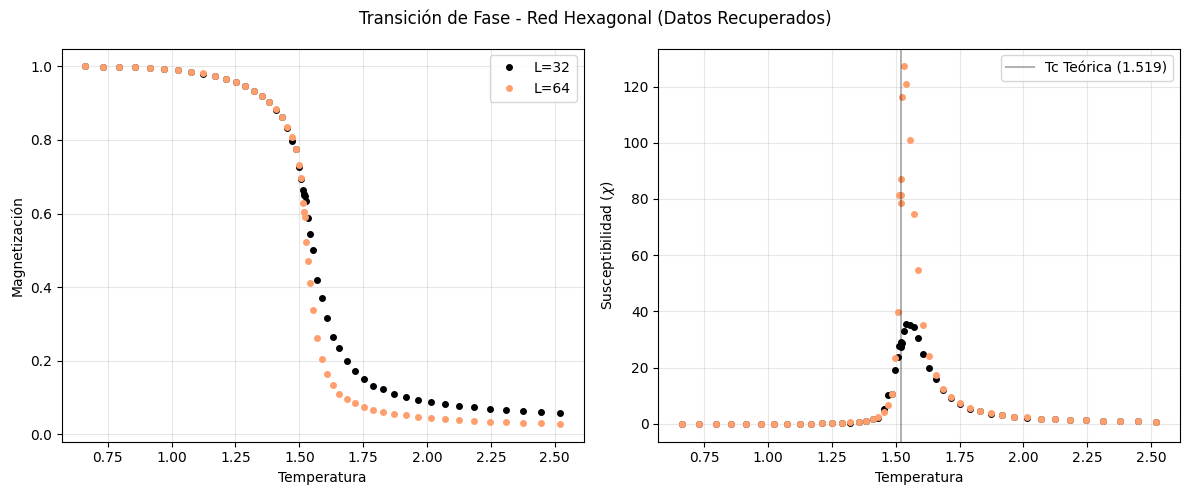

In [ ]:
# Carga y Gráficos de Magnetización y Susceptibilidad (Ising Hexagonal)


archivo_entrada = 'datos_ising_hexagonal_L32_L64_fase.npz'

print(f"Intentando cargar '{archivo_entrada}'...")
path_completo = os.path.join(DATA_DIR, archivo_entrada)
try:
    data = np.load(path_completo)

    temperaturas = data['temperaturas']

    # Extraemos los L disponibles buscando las claves que empiecen con 'm_L'
    Ls_encontrados = [int(k.split('_L')[1]) for k in data.files if k.startswith('m_L')]
    Ls_encontrados.sort()

    print(f"-> Datos cargados correctamente.")
    print(f"-> Temperaturas: {len(temperaturas)} puntos.")
    print(f"-> Longitudes encontradas: {Ls_encontrados}")

    # Colores para distinguir cada L
    colores = plt.cm.magma(np.linspace(0, 0.8, len(Ls_encontrados)))

    fig = plt.figure(figsize=(12, 5))
    plt.suptitle('Transición de Fase - Red Hexagonal (Datos Recuperados)')

    # --- 1. Magnetización ---
    ax1 = plt.subplot(1, 2, 1)
    for i, L in enumerate(Ls_encontrados):
        mag = data[f'm_L{L}']


        ax1.plot(temperaturas, mag, 'o', c=colores[i], ms=4, label=f'L={L}')


    ax1.set_ylabel('Magnetización')
    ax1.set_xlabel('Temperatura')
    ax1.grid(alpha=0.3)
    ax1.legend()

    # --- 2. Susceptibilidad ---
    ax2 = plt.subplot(1, 2, 2)
    for i, L in enumerate(Ls_encontrados):
        chi = data[f'chi_L{L}']

        # Puntos
        ax2.plot(temperaturas, chi, 'o', c=colores[i], ms=4)


    ax2.set_ylabel(r'Susceptibilidad ($\chi$)')
    ax2.set_xlabel('Temperatura')

    # Marcamos la Tc teórica hexagonal
    ax2.axvline(x=1.519, c='k', alpha=0.3, label='Tc Teórica (1.519)')
    ax2.grid(alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"\nERROR: No se encontró el archivo '{archivo_entrada}'.")
    print("Por favor, súbelo a la carpeta de archivos de Colab (ícono de carpeta a la izquierda).")
except KeyError as e:
    print(f"\nERROR: El archivo existe pero le faltan datos o claves. Detalle: {e}")

Conclusiones:

1.   Magnétización vs temperatura:

*   Tal y como se mencionó antes a baja Temperatura ($T < 1.5$) el sistema está en la fase ferromagnética. La magnetización es cercana a 1, lo que indica que casi todos los espines están alineados (ordenados).
*   Por otro lado a altas Temperaturas ($T > 1.6$) el sistema entra en la fase paramagnética. La magnetización cae a 0. El desorden térmico domina sobre la interacción de intercambio y los espines apuntan en direcciones aleatorias.

*    Se observa una caída más abrupta para L = 64. Si L -> $∞$ la caída sería una discontinuidad en la derivada.


2.   Susceptibilidad vs temperatura

*   La susceptibilidad magnética presenta un pico muy pronunciado justo en la transición.
*   La altura del pico crece con el tamaño de la red. Esto confirma que en una red infinita, la susceptibilidad divergiría a infinito en $T_c$.

*   La línea punteada vertical marca la $T_c$ teórica para la red hexagonal ($\approx 1.519$). notamos una gran coincidencia entre los datos simulados y los resultados de la teoría.







Cargando simulación: datos_ising_hex_energias.npz...

--- Analizando L = 32 ---

--- Analizando L = 64 ---


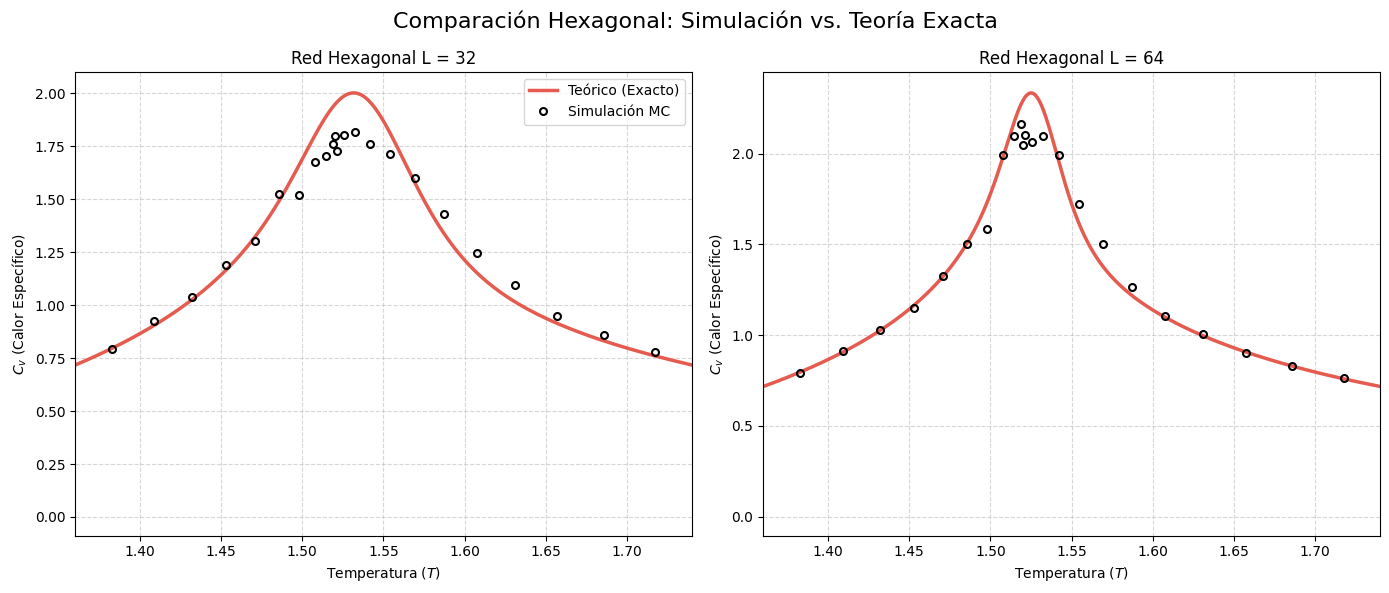

In [ ]:
#  Comparación ajustada al Rango Teórico


#  1. CARGAR SIMULACIÓN
archivo_simulacion = 'datos_ising_hex_energias.npz'
print(f"Cargando simulación: {archivo_simulacion}...")
path_completo = os.path.join(DATA_DIR, archivo_simulacion)
try:
    data_sim = np.load(path_completo)
    T_sim = data_sim['temperaturas']
    cv_sim = {
        32: data_sim['cv_L32'],
        64: data_sim['cv_L64']
    }
except FileNotFoundError:
    print("❌ Error: Falta el archivo .npz de la simulación.")

#  2. CONFIGURACIÓN
archivos_teoricos = {
    32: "c_32x32.csv",
    64: "c_64x64.csv"
}

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.suptitle("Comparación Hexagonal: Simulación vs. Teoría Exacta", fontsize=16)

Ls = [32, 64]

for i, L in enumerate(Ls):
    ax = axs[i]
    filename_teo = archivos_teoricos[L]

    print(f"\n--- Analizando L = {L} ---")

    try:
        # Cargar Teoría
        df_teo = pd.read_csv(os.path.join(DATA_DIR, filename_teo), header=None)
        T_teo = df_teo.iloc[:, 0].values
        Cv_teo = df_teo.iloc[:, 1].values

        # Ordenar
        idx_sort = np.argsort(T_teo)
        T_teo = T_teo[idx_sort]
        Cv_teo = Cv_teo[idx_sort]

        # GRAFICAR TEORÍA
        ax.plot(T_teo, Cv_teo, '-', color='#E55B4F', lw=2.5, label='Teórico (Exacto)')

        # Ajustamos la vista al rango de la teoría
        ax.set_xlim(min(T_teo), max(T_teo))

    except Exception as e:
        print(f"❌ Error: {e}")
        stats_text = "Error"

    # GRAFICAR SIMULACIÓN
    ax.plot(T_sim, cv_sim[L], 'o',
            color='black',
            markerfacecolor='none',
            markeredgewidth=1.5,
            markersize=5,
            label='Simulación MC')

    ax.set_title(f"Red Hexagonal L = {L}")
    ax.set_xlabel("Temperatura ($T$)")
    ax.set_ylabel("$C_v$ (Calor Específico)")
    ax.grid(True, linestyle='--', alpha=0.5)



    if i == 0: ax.legend()

plt.tight_layout()
plt.show()

Conclusiones: Concordancia entre los datos simulados y la solución teórica exacta para redes finitas.

Se observa claramente el comportamiento esperado por la teoría de finite-size scaling. Al pasar de $L=32$ a $L=64$, la altura máxima del calor específico aumenta notablemente (de $\approx 1.8$ a $\approx 2.3$). Esto es consistente con la divergencia logarítmica del calor específico en el límite termodinámico.

Además la curva para $L=64$ es más estrecha alrededor de la temperatura crítica ($T_c \approx 1.52$), indicando que al aumentar el sistema nos acercamos a la singularidad matemática de la transición de fase.

**Nota**: El motivo del $R^2$ negativo ($\approx -0.04$) se debe a la diferencia de dominios de temperatura entre los datos simulados y los datos teoricos.

## Ajustes

In [ ]:
#  Medición Tc(L = 6) hexagonal

"""

L_objetivo = 6        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones
# ---------------------------

# --- FUNCIONES DE SIMULACIÓN (HEXAGONAL) ---
@njit
def metropolisTermo_hex(S, prob, nequilibrio):
    S = S.copy(); L = S.shape[0]; L2 = L * L
    for n in range(nequilibrio):
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)
            up, down = S[(i - 1) % L, j], S[(i + 1) % L, j]
            side = S[i, (j + 1) % L] if (i + j) % 2 == 0 else S[i, (j - 1) % L]
            de = 2 * S[i, j] * (up + down + side)
            if de <= 0 or (de == 2 and np.random.random() < prob[0]) or (de == 6 and np.random.random() < prob[1]):
                S[i, j] = -S[i, j]
    return S

@njit
def metropolisN_hex_chi(S, prob, npasos):
    S = S.copy(); L = S.shape[0]; L2 = L * L
    m = np.zeros(npasos); current_M = np.sum(S); m[0] = current_M
    for n in range(1, npasos):
        dM_total = 0
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)
            up, down = S[(i - 1) % L, j], S[(i + 1) % L, j]
            side = S[i, (j + 1) % L] if (i + j) % 2 == 0 else S[i, (j - 1) % L]
            de = 2 * S[i, j] * (up + down + side)
            if de <= 0 or (de == 2 and np.random.random() < prob[0]) or (de == 6 and np.random.random() < prob[1]):
                S[i, j] = -S[i, j]
                dM_total += 2 * S[i, j]
        current_M += dM_total
        m[n] = current_M
    m = m / L2
    return S, np.mean(np.abs(m)), np.var(np.abs(m))

# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")


    """

<>:120: SyntaxWarning: invalid escape sequence '\p'
<>:120: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-4223519554.py:120: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")


'\n\nL_objetivo = 6        # <--- CAMBIA ESTO (16, 32, 64...)\nN_mediciones = 4       # Cantidad de repeticiones\n# ---------------------------\n\n# --- FUNCIONES DE SIMULACIÓN (HEXAGONAL) ---\n@njit\ndef metropolisTermo_hex(S, prob, nequilibrio):\n    S = S.copy(); L = S.shape[0]; L2 = L * L\n    for n in range(nequilibrio):\n        for _ in range(L2):\n            i, j = divmod(np.random.randint(0, L2), L)\n            up, down = S[(i - 1) % L, j], S[(i + 1) % L, j]\n            side = S[i, (j + 1) % L] if (i + j) % 2 == 0 else S[i, (j - 1) % L]\n            de = 2 * S[i, j] * (up + down + side)\n            if de <= 0 or (de == 2 and np.random.random() < prob[0]) or (de == 6 and np.random.random() < prob[1]):\n                S[i, j] = -S[i, j]\n    return S\n\n@njit\ndef metropolisN_hex_chi(S, prob, npasos):\n    S = S.copy(); L = S.shape[0]; L2 = L * L\n    m = np.zeros(npasos); current_M = np.sum(S); m[0] = current_M\n    for n in range(1, npasos):\n        dM_total = 0\n       

Intentando cargar 'mediciones_completas_hex_L6.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


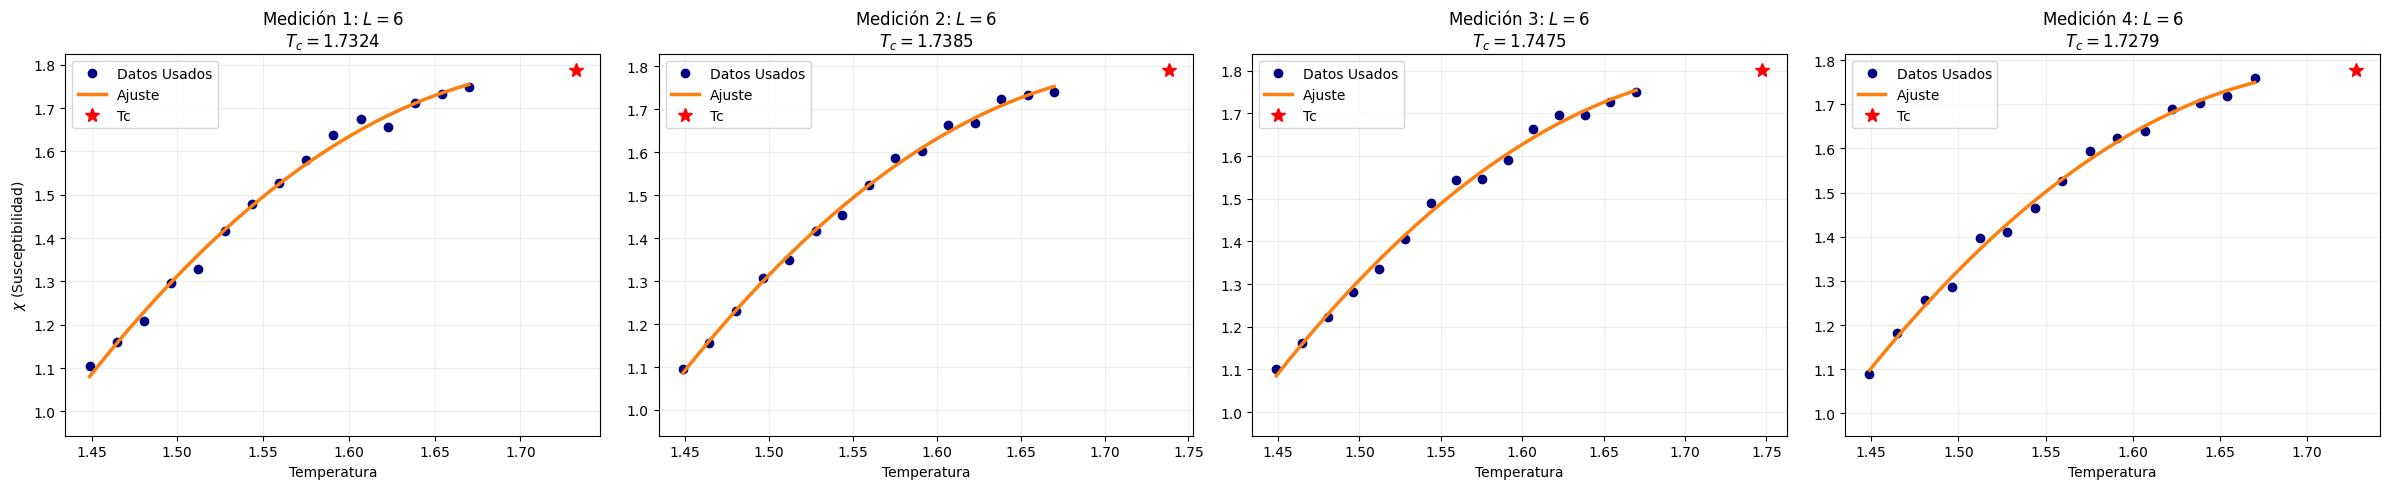


 RESULTADOS RECUPERADOS L=6
Tc individuales: [1.73241, 1.73852, 1.74751, 1.72786]
Tc PROMEDIO:      1.73657
Error (StdDev):   0.00736


In [ ]:
# Carga y Análisis de Datos L = 6


L_analizar = 6


nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Intentando cargar '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recuperados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']
        params   = data[f'ajuste_params_{idx}']

        tc_detectada = params[1]
        tcs_recuperados.append(tc_detectada)

        ax = axs[i]


        umbral = np.max(chi_data) * 0.6
        mask = chi_data > umbral

        x_datos = temps[mask]
        y_datos = chi_data[mask]


        ax.plot(x_datos, y_datos, 'o', color='navy', label='Datos Usados')


        if len(x_datos) > 0:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params)

            y_fit[y_fit < 0] = np.nan
            ax.plot(x_fit, y_fit, '-', color='tab:orange', lw=2.5, label='Ajuste')


        ax.plot(tc_detectada, params[2], 'r*', markersize=10, zorder=5, label='Tc')


        ax.set_title(fr"Medición {idx}: $L={L_analizar}$" + "\n" + fr"$T_c = {tc_detectada:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral*0.9)

        if i == 0: ax.set_ylabel(r'$\chi$ (Susceptibilidad)')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Resultados
    print("\n" + "="*40)
    print(f" RESULTADOS RECUPERADOS L={L_analizar}")
    print("="*40)
    tc_formateados = ", ".join([f"{t:.5f}" for t in tcs_recuperados])
    print(f"Tc individuales: [{tc_formateados}]")
    print(f"Tc PROMEDIO:      {np.mean(tcs_recuperados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recuperados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

In [ ]:
#  Medición Tc(L = 10) hexagonal

"""

L_objetivo = 10        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones
# ---------------------------

# --- FUNCIONES DE SIMULACIÓN (HEXAGONAL) ---
@njit
def metropolisTermo_hex(S, prob, nequilibrio):
    S = S.copy(); L = S.shape[0]; L2 = L * L
    for n in range(nequilibrio):
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)
            up, down = S[(i - 1) % L, j], S[(i + 1) % L, j]
            side = S[i, (j + 1) % L] if (i + j) % 2 == 0 else S[i, (j - 1) % L]
            de = 2 * S[i, j] * (up + down + side)
            if de <= 0 or (de == 2 and np.random.random() < prob[0]) or (de == 6 and np.random.random() < prob[1]):
                S[i, j] = -S[i, j]
    return S

@njit
def metropolisN_hex_chi(S, prob, npasos):
    S = S.copy(); L = S.shape[0]; L2 = L * L
    m = np.zeros(npasos); current_M = np.sum(S); m[0] = current_M
    for n in range(1, npasos):
        dM_total = 0
        for _ in range(L2):
            i, j = divmod(np.random.randint(0, L2), L)
            up, down = S[(i - 1) % L, j], S[(i + 1) % L, j]
            side = S[i, (j + 1) % L] if (i + j) % 2 == 0 else S[i, (j - 1) % L]
            de = 2 * S[i, j] * (up + down + side)
            if de <= 0 or (de == 2 and np.random.random() < prob[0]) or (de == 6 and np.random.random() < prob[1]):
                S[i, j] = -S[i, j]
                dM_total += 2 * S[i, j]
        current_M += dM_total
        m[n] = current_M
    m = m / L2
    return S, np.mean(np.abs(m)), np.var(np.abs(m))

# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")


    """

Intentando cargar 'mediciones_completas_hex_L10.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


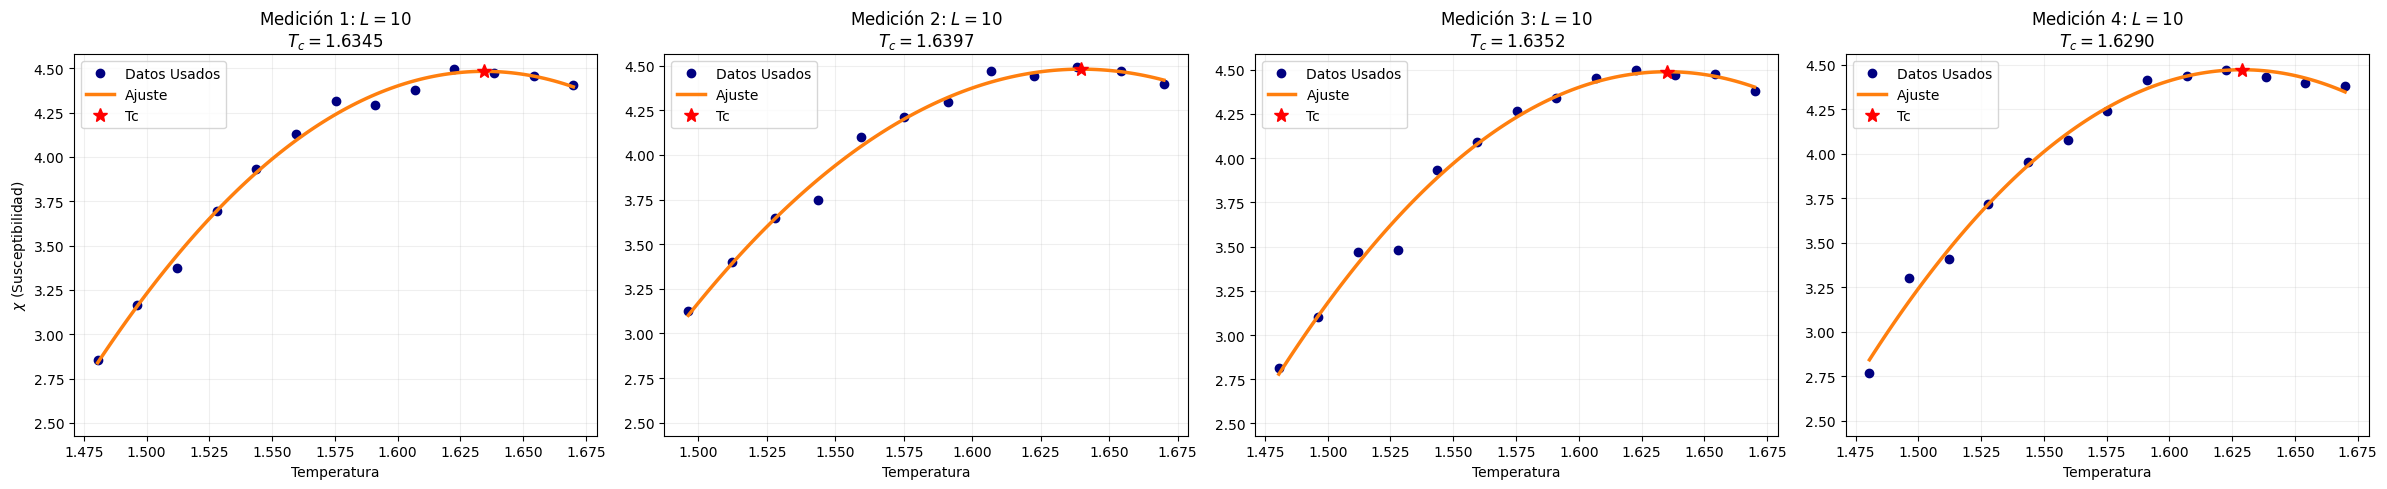


 RESULTADOS RECUPERADOS L=10
Tc individuales: [1.63446, 1.63973, 1.63518, 1.62896]
Tc PROMEDIO:      1.63458
Error (StdDev):   0.00383


In [ ]:
# Carga y Análisis de Datos L = 10


L_analizar = 10


nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Intentando cargar '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recuperados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']
        params   = data[f'ajuste_params_{idx}']

        tc_detectada = params[1]
        tcs_recuperados.append(tc_detectada)

        ax = axs[i]


        umbral = np.max(chi_data) * 0.6
        mask = chi_data > umbral

        x_datos = temps[mask]
        y_datos = chi_data[mask]


        ax.plot(x_datos, y_datos, 'o', color='navy', label='Datos Usados')


        if len(x_datos) > 0:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params)

            y_fit[y_fit < 0] = np.nan
            ax.plot(x_fit, y_fit, '-', color='tab:orange', lw=2.5, label='Ajuste')


        ax.plot(tc_detectada, params[2], 'r*', markersize=10, zorder=5, label='Tc')


        ax.set_title(fr"Medición {idx}: $L={L_analizar}$" + "\n" + fr"$T_c = {tc_detectada:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral*0.9)

        if i == 0: ax.set_ylabel(r'$\chi$ (Susceptibilidad)')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # Resultados
    print("\n" + "="*40)
    print(f" RESULTADOS RECUPERADOS L={L_analizar}")
    print("="*40)
    tc_formateados = ", ".join([f"{t:.5f}" for t in tcs_recuperados])
    print(f"Tc individuales: [{tc_formateados}]")
    print(f"Tc PROMEDIO:      {np.mean(tcs_recuperados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recuperados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Medición Tc(L = 32) hexagonal
"""


# --- PARÁMETROS A ELEGIR ---
L_objetivo = 32        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones


# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")

"""

<>:95: SyntaxWarning: invalid escape sequence '\p'
<>:95: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-655470115.py:95: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")


'\n\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom scipy.optimize import curve_fit\nfrom tqdm.auto import tqdm\nfrom google.colab import files\nfrom numba import njit\n\n# --- PARÁMETROS A ELEGIR ---\nL_objetivo = 32        # <--- CAMBIA ESTO (16, 32, 64...)\nN_mediciones = 4       # Cantidad de repeticiones\n\n\n# --- CONFIGURACIÓN ---\nfactor = 2500\nnequilibrio = 5 * factor\nnpromedio   = 200 * factor\n\n# Zoom en la zona crítica\nancho = 0.15 if L_objetivo < 64 else 0.08\nTcentro = 1.52\ntemps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)\n\n# Estructura para guardar TODO\ndatos_completos = {\n    \'temperaturas\': temps\n}\n\nresultados_Tc = []\nresultados_err = []\n\n# --- BUCLE DE MEDICIONES ---\nfig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))\nif N_mediciones == 1: axs = [axs]\n\nprint(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")\n\nfor i in range(N_mediciones):\n    print(f"  -> Medición {i+1}...")\n    chis = []\n\n    # Simulació

Intentando cargar 'mediciones_completas_hex_L32.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


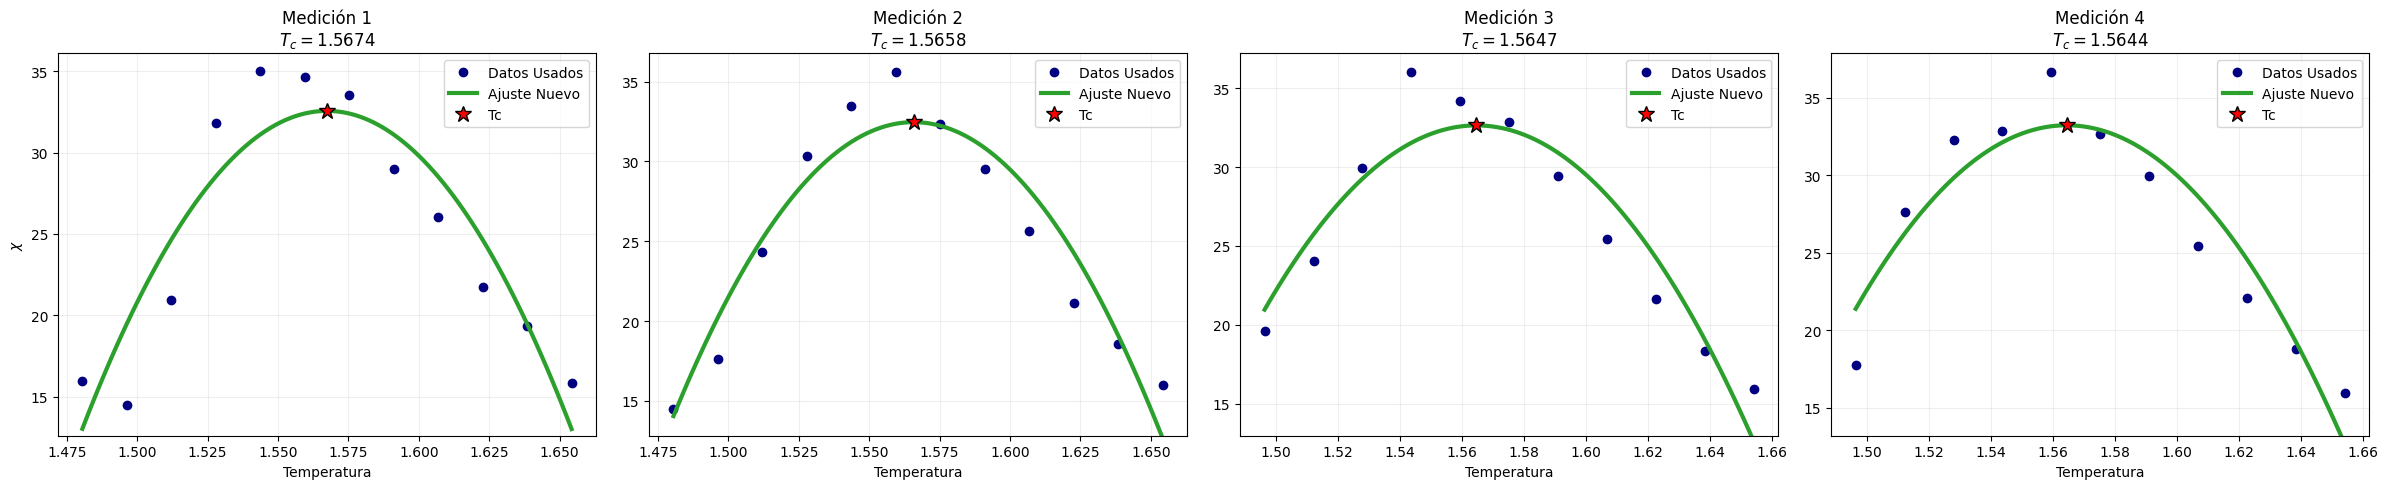


 RESULTADOS RE-CALCULADOS (Umbral 0.4)
Tc PROMEDIO:      1.56555
Error (StdDev):   0.00116


In [ ]:
# Carga y Análisis de Datos, Re-ajustes de Tc(L = 32

L_analizar = 32

nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Intentando cargar '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recalculados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]


    NUEVO_UMBRAL = 0.4

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']


        umbral_val = np.max(chi_data) * NUEVO_UMBRAL
        mask = chi_data > umbral_val

        x_datos = temps[mask]
        y_datos = chi_data[mask]

        ax = axs[i]


        params_viejos = data[f'ajuste_params_{idx}']
        p0 = [-1000, params_viejos[1], np.max(y_datos)]

        try:
            popt, _ = curve_fit(parabola, x_datos, y_datos, p0=p0, maxfev=10000)
            tc_nuevo = popt[1]
            params_finales = popt
            color_linea = 'tab:green'
        except:
            print(f"Ajuste falló en {idx}, usando viejo.")
            params_finales = params_viejos
            tc_nuevo = params_viejos[1]
            color_linea = 'tab:orange'

        tcs_recalculados.append(tc_nuevo)

        # 3. GRAFICAR
        # Puntos
        ax.plot(x_datos, y_datos, 'o', color='navy', markersize=6, label='Datos Usados')


        if len(x_datos) > 1:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params_finales)


            y_fit[y_fit < 0] = np.nan

            ax.plot(x_fit, y_fit, '-', color=color_linea, lw=3, label='Ajuste Nuevo')

        # Marca del Tc
        ax.plot(tc_nuevo, params_finales[2], 'r*', markersize=12, markeredgecolor='k', zorder=10, label='Tc')

        # Decoración
        ax.set_title(fr"Medición {idx}" + "\n" + fr"$T_c = {tc_nuevo:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral_val * 0.9)

        if i == 0: ax.set_ylabel(r'$\chi$')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()


    print("\n" + "="*40)
    print(f" RESULTADOS RE-CALCULADOS (Umbral {NUEVO_UMBRAL})")
    print("="*40)
    print(f"Tc PROMEDIO:      {np.mean(tcs_recalculados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recalculados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Medición Tc(L = 40) hexagonal
# Para generar nuevas simulaciones descomentar la celda
"""

# --- PARÁMETROS A ELEGIR ---
L_objetivo = 40        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones


# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")

"""

Intentando cargar 'mediciones_completas_hex_L40.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


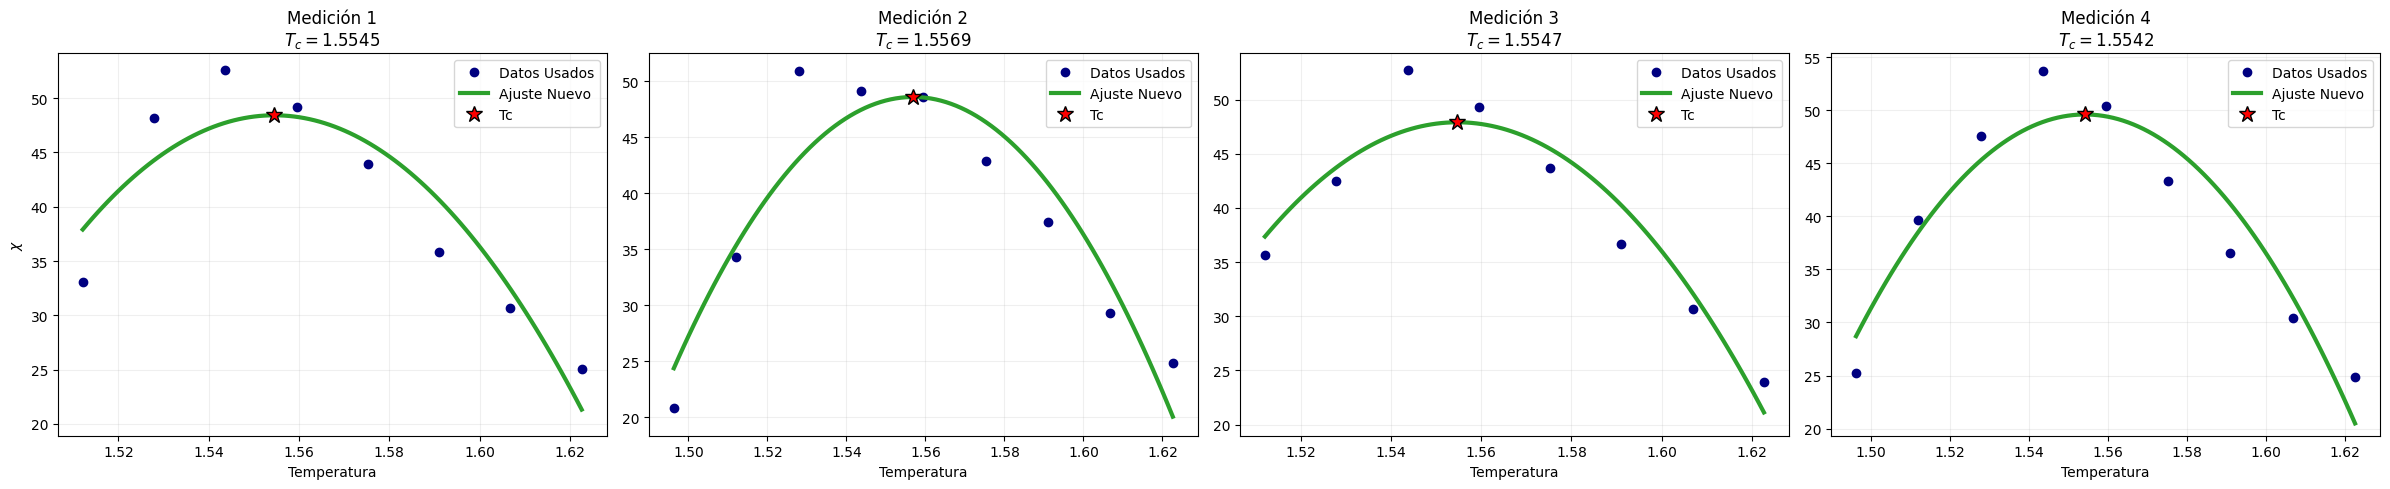


 RESULTADOS RE-CALCULADOS (Umbral 0.4)
Tc PROMEDIO:      1.55510
Error (StdDev):   0.00104


In [ ]:
# Carga y Análisis de Datos, Re-ajustes de Tc(L = 40)

L_analizar = 40


nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Intentando cargar '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recalculados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]


    NUEVO_UMBRAL = 0.4

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']


        umbral_val = np.max(chi_data) * NUEVO_UMBRAL
        mask = chi_data > umbral_val

        x_datos = temps[mask]
        y_datos = chi_data[mask]

        ax = axs[i]


        params_viejos = data[f'ajuste_params_{idx}']
        p0 = [-1000, params_viejos[1], np.max(y_datos)]

        try:
            popt, _ = curve_fit(parabola, x_datos, y_datos, p0=p0, maxfev=10000)
            tc_nuevo = popt[1]
            params_finales = popt
            color_linea = 'tab:green'
        except:
            print(f"Ajuste falló en {idx}, usando viejo.")
            params_finales = params_viejos
            tc_nuevo = params_viejos[1]
            color_linea = 'tab:orange'

        tcs_recalculados.append(tc_nuevo)


        ax.plot(x_datos, y_datos, 'o', color='navy', markersize=6, label='Datos Usados')


        if len(x_datos) > 1:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params_finales)


            y_fit[y_fit < 0] = np.nan

            ax.plot(x_fit, y_fit, '-', color=color_linea, lw=3, label='Ajuste Nuevo')


        ax.plot(tc_nuevo, params_finales[2], 'r*', markersize=12, markeredgecolor='k', zorder=10, label='Tc')


        ax.set_title(fr"Medición {idx}" + "\n" + fr"$T_c = {tc_nuevo:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral_val * 0.9)

        if i == 0: ax.set_ylabel(r'$\chi$')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()


    print("\n" + "="*40)
    print(f" RESULTADOS RE-CALCULADOS (Umbral {NUEVO_UMBRAL})")
    print("="*40)
    print(f"Tc PROMEDIO:      {np.mean(tcs_recalculados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recalculados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

In [ ]:
# Medición Tc(L = 46) hexagonal
# Para generar nuevas simulaciones descomentar la celda
"""


# --- PARÁMETROS A ELEGIR ---
L_objetivo = 46        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones


# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")

"""

Intentando cargar 'mediciones_completas_hex_L46.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


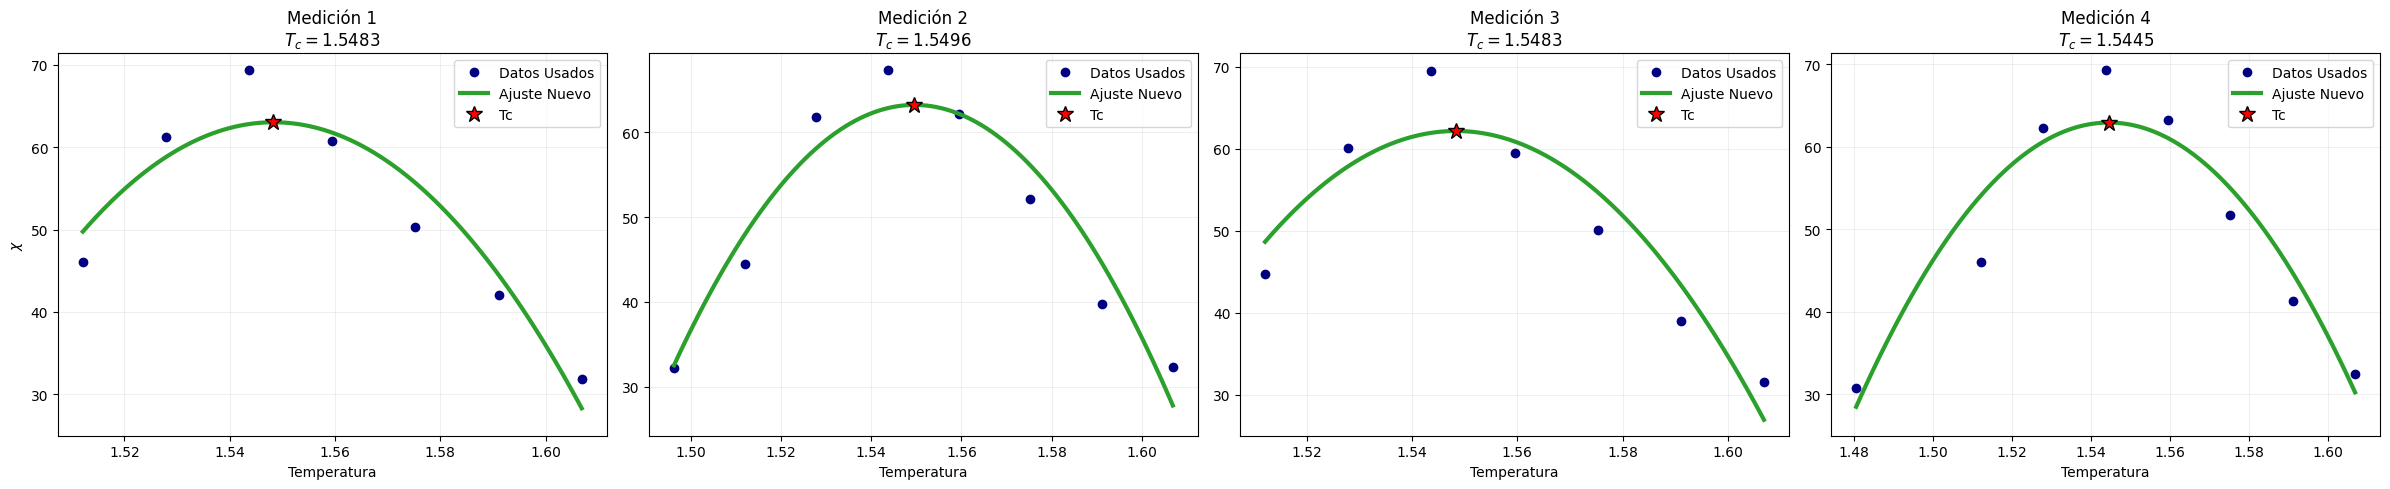


 RESULTADOS RE-CALCULADOS (Umbral 0.4)
Tc PROMEDIO:      1.54769
Error (StdDev):   0.00191


In [ ]:
# Carga y Análisis de Datos, Re-ajustes de Tc(L = 46)

L_analizar = 46


nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Intentando cargar '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recalculados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]


    NUEVO_UMBRAL = 0.4

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']


        umbral_val = np.max(chi_data) * NUEVO_UMBRAL
        mask = chi_data > umbral_val

        x_datos = temps[mask]
        y_datos = chi_data[mask]

        ax = axs[i]


        params_viejos = data[f'ajuste_params_{idx}']
        p0 = [-1000, params_viejos[1], np.max(y_datos)] #

        try:
            popt, _ = curve_fit(parabola, x_datos, y_datos, p0=p0, maxfev=10000)
            tc_nuevo = popt[1]
            params_finales = popt
            color_linea = 'tab:green'
        except:
            print(f"Ajuste falló en {idx}, usando viejo.")
            params_finales = params_viejos
            tc_nuevo = params_viejos[1]
            color_linea = 'tab:orange'

        tcs_recalculados.append(tc_nuevo)


        ax.plot(x_datos, y_datos, 'o', color='navy', markersize=6, label='Datos Usados')


        if len(x_datos) > 1:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params_finales)


            y_fit[y_fit < 0] = np.nan

            ax.plot(x_fit, y_fit, '-', color=color_linea, lw=3, label='Ajuste Nuevo')

        ax.plot(tc_nuevo, params_finales[2], 'r*', markersize=12, markeredgecolor='k', zorder=10, label='Tc')


        ax.set_title(fr"Medición {idx}" + "\n" + fr"$T_c = {tc_nuevo:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral_val * 0.9)

        if i == 0: ax.set_ylabel(r'$\chi$')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()

    # --- RESULTADOS NUEVOS ---
    print("\n" + "="*40)
    print(f" RESULTADOS RE-CALCULADOS (Umbral {NUEVO_UMBRAL})")
    print("="*40)
    print(f"Tc PROMEDIO:      {np.mean(tcs_recalculados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recalculados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

In [ ]:
#  Medición Tc(L = 64) hexagonal
# Para generar nuevas simulaciones descomentar la celda
"""
# --- PARÁMETROS A ELEGIR ---
L_objetivo = 64        # <--- CAMBIA ESTO (16, 32, 64...)
N_mediciones = 4       # Cantidad de repeticiones


# --- CONFIGURACIÓN ---
factor = 2500
nequilibrio = 5 * factor
npromedio   = 200 * factor

# Zoom en la zona crítica
ancho = 0.15 if L_objetivo < 64 else 0.08
Tcentro = 1.52
temps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)

# Estructura para guardar TODO
datos_completos = {
    'temperaturas': temps
}

resultados_Tc = []
resultados_err = []

# --- BUCLE DE MEDICIONES ---
fig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))
if N_mediciones == 1: axs = [axs]

print(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")

for i in range(N_mediciones):
    print(f"  -> Medición {i+1}...")
    chis = []

    # Simulación
    L2 = L_objetivo * L_objetivo
    S = np.ones((L_objetivo, L_objetivo))

    for T in tqdm(temps, leave=False):
        beta = 1/T
        prob = np.array([np.exp(-2 * beta), np.exp(-6 * beta)])
        S = metropolisTermo_hex(S, prob, nequilibrio)
        S, _, var_m = metropolisN_hex_chi(S, prob, npromedio)
        chis.append(beta * L2 * var_m)

    chis = np.array(chis)

    # GUARDAMOS LA CURVA DE ESTA MEDICIÓN
    datos_completos[f'chi_medicion_{i+1}'] = chis

    # --- AJUSTE DE PARÁBOLA ---
    # Ajustamos a*(x-b)^2 + c.  Donde 'b' es la Tc y 'c' la altura.
    def parabola(x, a, b, c): return a * (x - b)**2 + c

    idx_max = np.argmax(chis)
    p0 = [-1000, temps[idx_max], np.max(chis)]

    try:
        umbral = np.max(chis) * 0.6 # Usamos el 40% superior del pico
        mask = chis > umbral

        popt, pcov = curve_fit(parabola, temps[mask], chis[mask], p0=p0, maxfev=10000)
        perr = np.sqrt(np.diag(pcov))

        tc_medido = popt[1]
        err_tc = perr[1]

        resultados_Tc.append(tc_medido)
        resultados_err.append(err_tc)

        # GUARDAMOS LOS PARÁMETROS DEL AJUSTE
        datos_completos[f'ajuste_params_{i+1}'] = popt  # [a, b, c]
        datos_completos[f'ajuste_errores_{i+1}'] = perr # Errores de [a, b, c]

        # Imprimir info del ajuste en pantalla
        print(f"     [Ajuste {i+1}] Tc = {tc_medido:.5f} +/- {err_tc:.5f}")

        # Graficar
        ax = axs[i]
        ax.plot(temps, chis, 'o', color='navy', label='Datos Simulados')
        x_fit = np.linspace(min(temps), max(temps), 100)
        ax.plot(x_fit, parabola(x_fit, *popt), '-', color='tab:orange', lw=2, label='Ajuste Parábola')
        ax.plot(tc_medido, popt[2], 'ro', label='Tc Detectada')

        ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")
        ax.set_xlabel('T'); ax.set_ylabel('$\chi$')
        ax.grid(True, alpha=0.3)
        if i == 0: ax.legend()

    except Exception as e:
        print(f"Error ajuste {i+1}: {e}")

plt.tight_layout()
plt.show()

# --- RESULTADOS FINALES Y GUARDADO ---
print("\n" + "="*40)
print(f" RESULTADOS FINALES L={L_objetivo}")
print("="*40)
print(f"Tc individuales: {resultados_Tc}")
print(f"Tc PROMEDIO:     {np.mean(resultados_Tc):.5f}")
print(f"Error (StdDev):  {np.std(resultados_Tc):.5f}")
print("="*40)

# Guardar archivo
nombre_archivo = f"mediciones_completas_hex_L{L_objetivo}.npz"
print(f"\nGuardando TODO en {nombre_archivo}...")
np.savez(nombre_archivo, **datos_completos)

try:
    files.download(nombre_archivo)
except:
    print("Descarga manual requerida.")


    """

<>:86: SyntaxWarning: invalid escape sequence '\p'
<>:86: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-241292708.py:86: SyntaxWarning: invalid escape sequence '\p'
  ax.set_title(f"Medición {i+1}\n$T_c = {tc_medido:.4f} \pm {err_tc:.4f}$")


'\n# --- PARÁMETROS A ELEGIR ---\nL_objetivo = 64        # <--- CAMBIA ESTO (16, 32, 64...)\nN_mediciones = 4       # Cantidad de repeticiones\n\n\n# --- CONFIGURACIÓN ---\nfactor = 2500\nnequilibrio = 5 * factor\nnpromedio   = 200 * factor\n\n# Zoom en la zona crítica\nancho = 0.15 if L_objetivo < 64 else 0.08\nTcentro = 1.52\ntemps = np.linspace(Tcentro - ancho, Tcentro + ancho, 20)\n\n# Estructura para guardar TODO\ndatos_completos = {\n    \'temperaturas\': temps\n}\n\nresultados_Tc = []\nresultados_err = []\n\n# --- BUCLE DE MEDICIONES ---\nfig, axs = plt.subplots(1, N_mediciones, figsize=(22, 5))\nif N_mediciones == 1: axs = [axs]\n\nprint(f"Iniciando {N_mediciones} mediciones para L={L_objetivo}...")\n\nfor i in range(N_mediciones):\n    print(f"  -> Medición {i+1}...")\n    chis = []\n\n    # Simulación\n    L2 = L_objetivo * L_objetivo\n    S = np.ones((L_objetivo, L_objetivo))\n\n    for T in tqdm(temps, leave=False):\n        beta = 1/T\n        prob = np.array([np.exp(-2 * 

Intentando cargar 'mediciones_completas_hex_L64.npz'...
-> Archivo cargado. Se encontraron 4 mediciones.


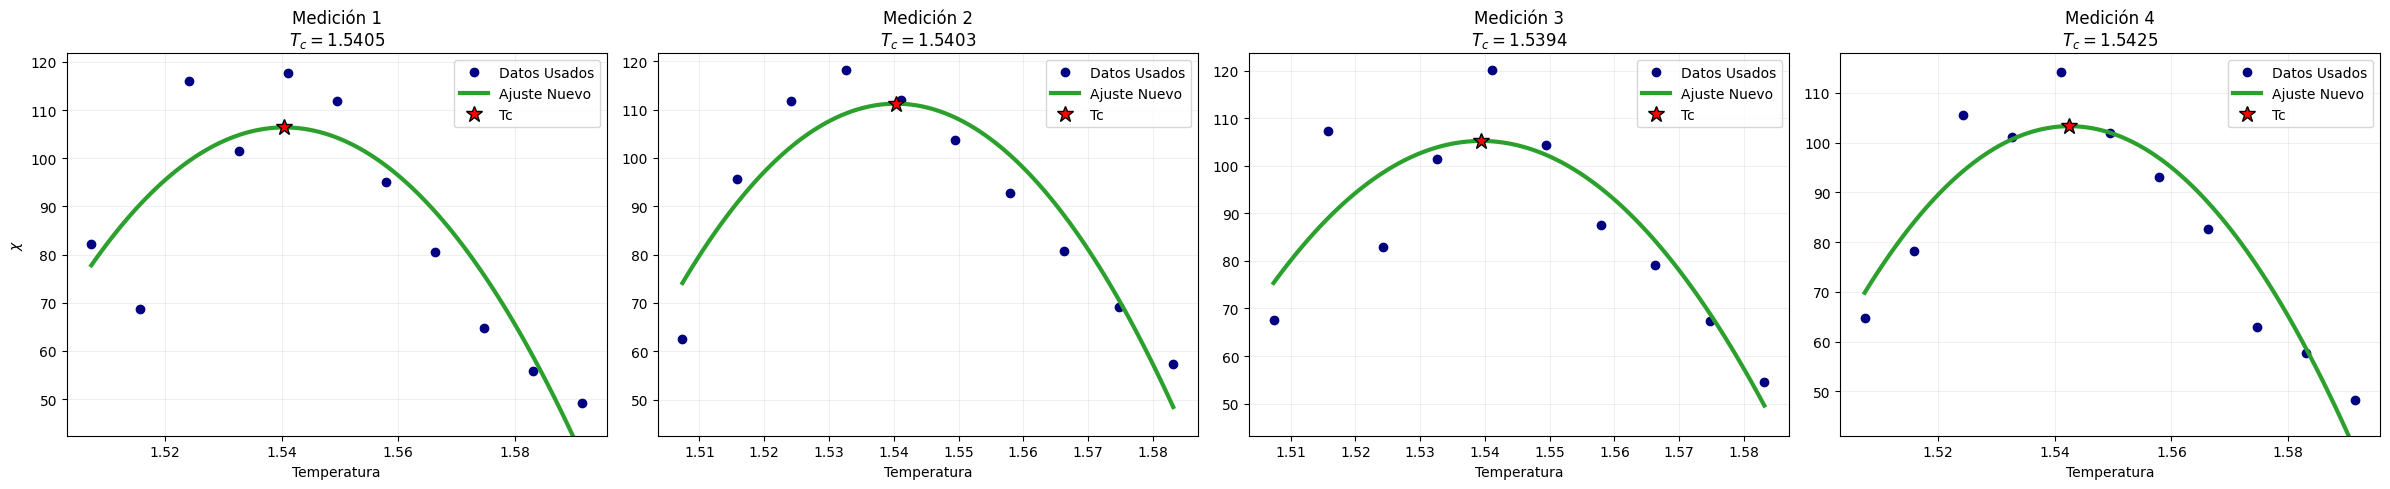


 RESULTADOS RE-CALCULADOS (Umbral 0.4)
Tc PROMEDIO:      1.54068
Error (StdDev):   0.00113


In [ ]:
# Carga y Análisis de Datos, Re-ajustes de Tc(L = 64)

L_analizar = 64


nombre_archivo = f"mediciones_completas_hex_L{L_analizar}.npz"
print(f"Cargando '{nombre_archivo}'...")
path_completo = os.path.join(DATA_DIR, nombre_archivo)
try:
    data = np.load(path_completo)
    keys = data.files
    temps = data['temperaturas']
    n_mediciones = sum(1 for k in keys if k.startswith('chi_medicion_'))
    print(f"-> Archivo cargado. Se encontraron {n_mediciones} mediciones.")

    def parabola(x, a, b, c):
        return a * (x - b)**2 + c

    tcs_recalculados = []

    fig, axs = plt.subplots(1, n_mediciones, figsize=(6 * n_mediciones, 5))
    if n_mediciones == 1: axs = [axs]


    NUEVO_UMBRAL = 0.4

    for i in range(n_mediciones):
        idx = i + 1
        chi_data = data[f'chi_medicion_{idx}']


        umbral_val = np.max(chi_data) * NUEVO_UMBRAL
        mask = chi_data > umbral_val

        x_datos = temps[mask]
        y_datos = chi_data[mask]

        ax = axs[i]


        params_viejos = data[f'ajuste_params_{idx}']
        p0 = [-1000, params_viejos[1], np.max(y_datos)]

        try:
            popt, _ = curve_fit(parabola, x_datos, y_datos, p0=p0, maxfev=10000)
            tc_nuevo = popt[1]
            params_finales = popt
            color_linea = 'tab:green'
        except:
            print(f"Ajuste falló en {idx}, usando viejo.")
            params_finales = params_viejos
            tc_nuevo = params_viejos[1]
            color_linea = 'tab:orange'

        tcs_recalculados.append(tc_nuevo)


        ax.plot(x_datos, y_datos, 'o', color='navy', markersize=6, label='Datos Usados')


        if len(x_datos) > 1:
            x_fit = np.linspace(min(x_datos), max(x_datos), 100)
            y_fit = parabola(x_fit, *params_finales)


            y_fit[y_fit < 0] = np.nan

            ax.plot(x_fit, y_fit, '-', color=color_linea, lw=3, label='Ajuste Nuevo')


        ax.plot(tc_nuevo, params_finales[2], 'r*', markersize=12, markeredgecolor='k', zorder=10, label='Tc')


        ax.set_title(fr"Medición {idx}" + "\n" + fr"$T_c = {tc_nuevo:.4f}$")
        ax.set_xlabel('Temperatura')


        ax.set_ylim(bottom=umbral_val * 0.9)

        if i == 0: ax.set_ylabel(r'$\chi$')
        ax.grid(True, alpha=0.2)
        ax.legend()

    plt.tight_layout()
    plt.show()

    print("\n" + "="*40)
    print(f" RESULTADOS RE-CALCULADOS (Umbral {NUEVO_UMBRAL})")
    print("="*40)
    print(f"Tc PROMEDIO:      {np.mean(tcs_recalculados):.5f}")
    print(f"Error (StdDev):   {np.std(tcs_recalculados):.5f}")
    print("="*40)

except Exception as e:
    print(f"Error: {e}")

Conclusión:

Notamos una clara dependencia del $T_c$ con el tamaño del sistema para las simulaciones realizadas ($L=6, 18, 32, 64$). Para la red más pequeña ($L=6$), la temperatura crítica aparente es alta ($T_c \approx 1.736$), indicando que en sistemas pequeños el orden se rompe a temperaturas mayores. A medida que $L$ aumenta, el pico de susceptibilidad se desplaza hacia temperaturas más bajas ($T_c \approx 1.588$ para $L=18$ y $T_c \approx 1.537$ para $L=64$), acercándose progresivamente al valor teórico esperado.

El motivo de este comportamiento se debe a las condiciones de contorno periodicas impuestas en nuestro sistema. Las fronteras auto-estabilizan el sistema, por lo que es necesaria más energía para romper el orden.

## Aproximación lineal

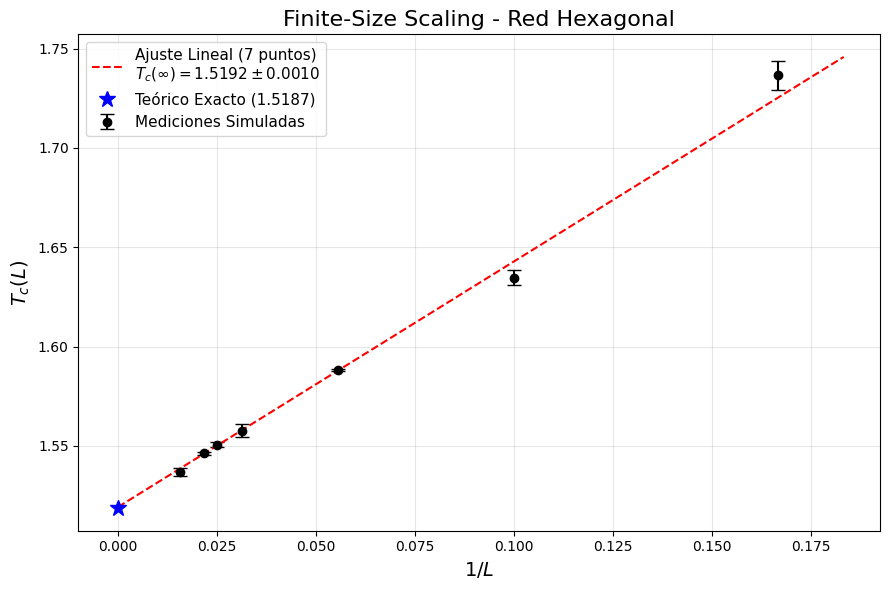

RESULTADO FINAL (Extrapolado a L -> inf):
Tc (Simulada)  = 1.51924 +/- 0.00104
Tc (Teórica)   = 1.51866
----------------------------------------
Desviación absoluta: 0.00058
Error relativo:      0.04%


In [ ]:
# Ajuste Final Finite-Size Scaling (Red Hexagonal), pre corrección


# Datos medidos
Ls = np.array([6, 10, 18, 32, 40, 46, 64])
Tcs = np.array([1.73657, 1.63458,1.58798, 1.55770, 1.55063, 1.54621,1.53706])
errores = np.array([0.00736, 0.00383, 0.00051, 0.00320, 0.00139, 0.00083,0.00204])

# Variable X para el ajuste (1/L)
inv_L = 1 / Ls

# Función lineal: Tc(L) = Tc_inf + a * (1/L)
def ajuste_lineal(x, tc_inf, a):
    return tc_inf + a * x

# Ajuste ponderado por los errores
popt, pcov = curve_fit(ajuste_lineal, inv_L, Tcs, sigma=errores, absolute_sigma=True)

Tc_infinito = popt[0]
pendiente = popt[1]
error_Tc = np.sqrt(np.diag(pcov))[0]

# GRÁFICO
plt.figure(figsize=(9, 6))

# Puntos con barras de error
plt.errorbar(inv_L, Tcs, yerr=errores, fmt='o', color='black', capsize=5, label='Mediciones Simuladas')

# Recta de ajuste
x_line = np.linspace(0, max(inv_L)*1.1, 100)

plt.plot(x_line, ajuste_lineal(x_line, *popt), 'r--',
         label=fr'Ajuste Lineal ({len(Ls)} puntos)' + '\n' + fr'$T_c(\infty)={Tc_infinito:.4f} \pm {error_Tc:.4f}$')

# Punto teórico para comparar (1.519)
valor_teorico = 1.51866 # Definimos la variable antes para usarla
plt.plot(0, valor_teorico, 'b*', ms=12, label=f'Teórico Exacto ({valor_teorico:.4f})')


plt.xlabel(r'$1/L$', fontsize=14)
plt.ylabel(r'$T_c(L)$', fontsize=14)
plt.title('Finite-Size Scaling - Red Hexagonal', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(left=-0.01)

plt.tight_layout()
plt.show()

# RESULTADOS NUMÉRICOS
desviacion = abs(Tc_infinito - valor_teorico)
error_relativo = (desviacion / valor_teorico) * 100

print("="*40)
print(f"RESULTADO FINAL (Extrapolado a L -> inf):")
print(f"Tc (Simulada)  = {Tc_infinito:.5f} +/- {error_Tc:.5f}")
print(f"Tc (Teórica)   = {valor_teorico:.5f}")
print("-" * 40)
print(f"Desviación absoluta: {desviacion:.5f}")
print(f"Error relativo:      {error_relativo:.2f}%")
print("="*40)

Conclusiones:



1.   Se observa una relación lineal entre $T_c$ y $1/L$, por lo que el sistema obedece la siguiente relación
$$T_\textrm{c}(L)=T_\textrm{c}+\frac{a}{L},$$
con $a = 1$.
2.   Observamos que la temperatura crítica teorica correspondiente a red infinita (el límite termodínamico), se corresponde en gran medida con nuestro resultado derivado del ajuste y de las diferentes simulaciones.
3.   La pendiente positiva de la recta confirma las conclusiones discutidas antes respecto de la temperatura crítica y el tamaño de las redes.
4.   Finalmente y con este resultado podemos concluir que la topología utilizada es apropiada para la simulación de la red hexagonal.


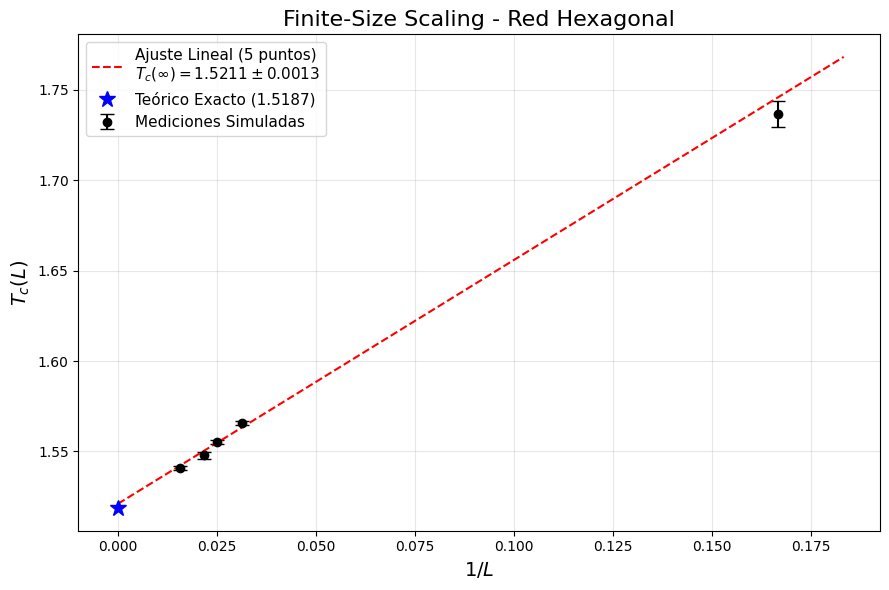

RESULTADO FINAL (Extrapolado a L -> inf):
Tc (Simulada)  = 1.52110 +/- 0.00129
Tc (Teórica)   = 1.51866
----------------------------------------
Desviación absoluta: 0.00244
Error relativo:      0.16%


In [ ]:
Ls = np.array([6,   32, 40, 46, 64])
Tcs = np.array([1.73657,  1.56555, 1.55510, 1.54789,1.54068])
errores = np.array([0.00736,   0.00116, 0.00104, 0.00191,0.00113])

# Variable X para el ajuste (1/L)
inv_L = 1 / Ls

# Función lineal: Tc(L) = Tc_inf + a * (1/L)
def ajuste_lineal(x, tc_inf, a):
    return tc_inf + a * x

# Ajuste ponderado por los errores
popt, pcov = curve_fit(ajuste_lineal, inv_L, Tcs, sigma=errores, absolute_sigma=True)

Tc_infinito = popt[0]
pendiente = popt[1]
error_Tc = np.sqrt(np.diag(pcov))[0]

#  GRÁFICO
plt.figure(figsize=(9, 6))

# Puntos con barras de error
plt.errorbar(inv_L, Tcs, yerr=errores, fmt='o', color='black', capsize=5, label='Mediciones Simuladas')

# Recta de ajuste
x_line = np.linspace(0, max(inv_L)*1.1, 100)

plt.plot(x_line, ajuste_lineal(x_line, *popt), 'r--',
         label=fr'Ajuste Lineal ({len(Ls)} puntos)' + '\n' + fr'$T_c(\infty)={Tc_infinito:.4f} \pm {error_Tc:.4f}$')

# Punto teórico para comparar (1.519)
valor_teorico = 1.51866 # Definimos la variable antes para usarla
plt.plot(0, valor_teorico, 'b*', ms=12, label=f'Teórico Exacto ({valor_teorico:.4f})')

plt.xlabel(r'$1/L$', fontsize=14)
plt.ylabel(r'$T_c(L)$', fontsize=14)
plt.title('Finite-Size Scaling - Red Hexagonal', fontsize=16)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim(left=-0.01)

plt.tight_layout()
plt.show()

# RESULTADOS
desviacion = abs(Tc_infinito - valor_teorico)
error_relativo = (desviacion / valor_teorico) * 100

print("="*40)
print(f"RESULTADO FINAL (Extrapolado a L -> inf):")
print(f"Tc (Simulada)  = {Tc_infinito:.5f} +/- {error_Tc:.5f}")
print(f"Tc (Teórica)   = {valor_teorico:.5f}")
print("-" * 40)
print(f"Desviación absoluta: {desviacion:.5f}")
print(f"Error relativo:      {error_relativo:.2f}%")
print("="*40)

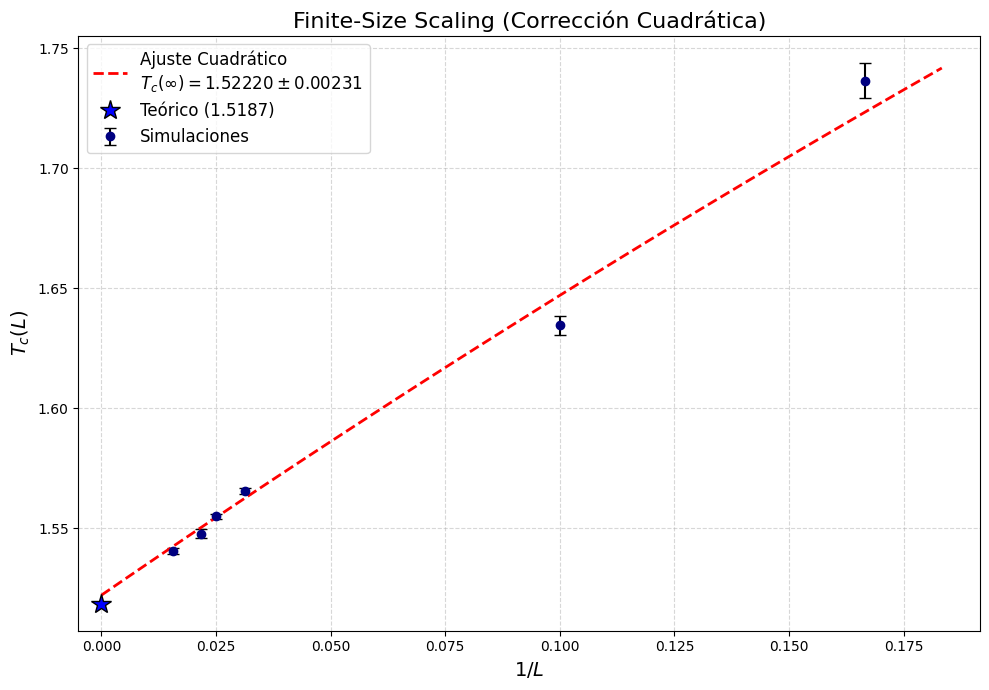


 RESULTADOS SCALING CUADRÁTICO
Tc Extrapolado:   1.52220 +/- 0.00231
Tc Teórico:       1.51866
--------------------------------------------------
Coeficiente Lineal (a):      1.3099
Coeficiente Cuadrático (b):  -0.6117
--------------------------------------------------
Desviación abs:   0.00354
Error relativo:   0.23%


In [ ]:
# 1. DATOS
Ls = np.array([6, 10,  32, 40, 46, 64])
Tcs = np.array([1.73657, 1.63458,  1.56555, 1.55510, 1.54789, 1.54068])
errores = np.array([0.00736, 0.00383,  0.00116, 0.00104, 0.00191, 0.00113])

inv_L = 1 / Ls

# 2. DEFINICIÓN DEL AJUSTE CUADRÁTICO
# Tc(L) = Tc_inf + a*(1/L) + b*(1/L)^2
def ajuste_cuadratico(x, tc_inf, a, b):
    return tc_inf + a * x + b * (x**2)

# Ajuste ponderado
# p0 ayuda a que converja mejor (arrancamos asumiendo que es casi lineal)
popt, pcov = curve_fit(ajuste_cuadratico, inv_L, Tcs, sigma=errores, absolute_sigma=True, p0=[1.5187, 1.2, 0.8])

Tc_infinito = popt[0]
a_param = popt[1]
b_param = popt[2]
error_Tc = np.sqrt(np.diag(pcov))[0]

# 3. GRÁFICO
plt.figure(figsize=(10, 7))

# Puntos Simulados
plt.errorbar(inv_L, Tcs, yerr=errores, fmt='o', color='navy',
             ecolor='black', capsize=4, markersize=6,
             label='Simulaciones')

# Curva de Ajuste (Parábola)
x_line = np.linspace(0, max(inv_L)*1.1, 100)
y_line = ajuste_cuadratico(x_line, *popt)

plt.plot(x_line, y_line, 'r--', lw=2,
         label=fr'Ajuste Cuadrático' + '\n' + fr'$T_c(\infty)={Tc_infinito:.5f} \pm {error_Tc:.5f}$')

# Valor Teórico
valor_teorico = 1.51866
plt.plot(0, valor_teorico, 'b*', markersize=15, markeredgecolor='k', zorder=10,
         label=fr'Teórico ({valor_teorico:.4f})')

plt.xlabel(r'$1/L$', fontsize=14)
plt.ylabel(r'$T_c(L)$', fontsize=14)
plt.title(r'Finite-Size Scaling (Corrección Cuadrática)', fontsize=16)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(left=-0.005, right=max(inv_L)*1.15)

plt.tight_layout()
plt.show()

# 4. RESULTADOS
desviacion = abs(Tc_infinito - valor_teorico)
error_relativo = (desviacion / valor_teorico) * 100

print("\n" + "="*50)
print(f" RESULTADOS SCALING CUADRÁTICO")
print("="*50)
print(f"Tc Extrapolado:   {Tc_infinito:.5f} +/- {error_Tc:.5f}")
print(f"Tc Teórico:       {valor_teorico:.5f}")
print("-" * 50)
print(f"Coeficiente Lineal (a):      {a_param:.4f}")
print(f"Coeficiente Cuadrático (b):  {b_param:.4f}")
print("-" * 50)
print(f"Desviación abs:   {desviacion:.5f}")
print(f"Error relativo:   {error_relativo:.2f}%")
print("="*50)

Aclaración: El ajuste previamente presentado utilizaba muy pocos puntos de las redes L = 32, 40, 46, 64. Por lo que se decidió hacer otros ajustes que tomaran en cuenta algunos puntos más de la simulación (no solo los 6/7 datos más cercanos al pico).


Observamos que el ajuste lineal fue el que arrojó un error más pequeño comparado al ajuste cuadrático, dado que el primero arroja un $T_c = 1.5211 ± 0.0013$ , mientras el último arroja un $T_c = 1.52220 ± 0.0023$ . A pesar de ello logramos confirmar la naturaleza del comprotamiento inversamente proporcional de la  $T_C$ respecto de $L$.

Finalmente:

1.   La pendiente positiva de la recta en el caso lineal confirma las conclusiones discutidas antes respecto de la temperatura crítica y el tamaño de las redes.
2.   Con este resultado podemos concluir que la topología utilizada es apropiada para la simulación de la red hexagonal.